<a href="https://colab.research.google.com/github/marco-siino/gpt_energy_cost_optimization/blob/main/Mistral7B_Energy_Cost_Optimization_MSiino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download model and libraries.

Installing dependencies. You might need to tweak the CMAKE_ARGS for the `llama-cpp-python` pip package.

In [1]:
# GPU llama-cpp-python; Starting from version llama-cpp-python==0.1.79, it supports GGUF
!CMAKE_ARGS="-DLLAMA_CUBLAS=on " pip install 'llama-cpp-python>=0.1.79' --force-reinstall --upgrade --no-cache-dir
# For download the models
!pip install huggingface_hub
!pip install datasets
!pip install py7zr

from datasets import load_dataset
from datetime import datetime, timedelta
from huggingface_hub import hf_hub_download
from py7zr import unpack_7zarchive
import matplotlib.pyplot as plt
import json
import re
import datasets
import random
import numpy as np
import tqdm.notebook as tqdm
import tensorflow as tf
import os
import requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 41.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 154.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 158.5 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.64-cp310-cp310-linux_x86_64.whl size=39385784 sha256=ff9af3944d5b7ffd0419d3b1efda78ad0072205c9fe4ee7d50d2574bc8d57cfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-90pm2g52/wheels/4a/69/6b/2fb423c0e39b66cc7f9b84ea837dbdc1eee8ea5f624e3eaeb6
Successfully built llama-cpp-python
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
   

Downloading an instruction-finetuned Mistral model.

In [2]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

# This config has been tested on an RTX 3080 (VRAM of 16GB).
# you might need to tweak with respect to your hardware.
from llama_cpp import Llama
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=4, #16, # CPU cores
    n_batch=800, #8000, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=8192, # Context window
    logits_all=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

# Get the dataset.

In [3]:
def download_and_extract(url, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        # Save the downloaded file
        filename = os.path.join(output_dir, "archive.7z")
        with open(filename, "wb") as f:
            f.write(response.content)

        # Extract the contents of the archive
        with open(filename, 'rb') as f:
            unpack_7zarchive(f, output_dir)

        print("Extraction completed.")
    else:
        print("Failed to download the file.")

# Example usage:
url = "https://pureportal.strath.ac.uk/files/52873459/Processed_Data_CSV.7z"
output_directory = "extracted_contents"
download_and_extract(url, output_directory)

Extraction completed.


# Dataset structure.
Each CSV file corresponds to a House. For each house there are always 9 appliances. The corresponding description of each appliance is reported below.

House 1

0.Aggregate, 1.Fridge, 2.Chest Freezer, 3.Upright Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Computer Site, 8.Television Site, 9.Electric Heater
	!NOTES
		0. October 2014, numerous light bulbs changed to LEDs.
		7.a Desktop Computer
		7.b Computer Monitor

House 2

0.Aggregate, 1.Fridge-Freezer, 2.Washing Machine, 3.Dishwasher, 4.Television,
5.Microwave, 6.Toaster, 7.Hi-Fi, 8.Kettle, 9.Oven Extractor Fan
	!NOTES

House 3

0.Aggregate, 1.Toaster, 2.Fridge-Freezer, 3.Freezer, 4.Tumble Dryer,
5.Dishwasher, 6.Washing Machine, 7.Television, 8.Microwave, 9.Kettle
	!NOTES

House 4

0.Aggregate, 1.Fridge, 2.Freezer, 3.Fridge-Freezer, 4.Washing Machine (1),
5.Washing Machine (2), 6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		6.a Desktop Computer
		6.b Computer Monitor
		6.c Scanner
		6.d Printer
		6.e Router
		6. Change in signature 01/02/2015
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7. Change in signature 19/12/2014

House 5

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Combination Microwave, 8.Kettle, 9.Toaster
	!NOTES
		2. Dehumidifier added on 21/11/2014
		5.a Desktop Computer
		5.b Computer Monitor
		5.c Printer
		5.d Speakers
		5. Change in signature 27/01/2015
		6.a Television w/DVD Player
		6.b Set-top Box
		6.c Games Console

House 6

0.Aggregate, 1.Freezer (Utility Room), 2.Washing Machine, 3.Dishwasher, 4.MJY Computer,
5.Television Site, 6.Microwave, 7.Kettle, 8.Toaster, 9.PGM Computer
	!NOTES
		4.a Desktop Computer
		4.b Computer Monitor
		4.c Computer Monitor
		4.d Printer
		5.a Television
		5.b Set-top Box
		5.c PC
		5.d DVD Player
		9.a Desktop Computer
		9.b Computer Monitor
		9.c Printer
		9.d Shredder

House 7

0.Aggregate, 1.Fridge, 2.Freezer (Garage), 3.Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Toaster, 9.Kettle
	!NOTES
		3. Change in signature 24/11/13
		6. Change in signature 20/05/14
		7.a Television
		7.b Speakers
		7.c Telephone

House 8

0.Aggregate, 1.Fridge, 2.Freezer, 3.Dryer, 4.Washing Machine,
5.Toaster, 6.Computer, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		1. Change in Fridge Nov 6th
		5.a Toaster
		5.b DAB Radio
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7.d Sound Bar

House 9

0.Aggregate, 1.Fridge-Freezer, 2.Washer Dryer, 3.Washing Machine, 4.Dishwasher,
5.Television Site, 6.Microwave, 7.Kettle, 8.Hi-Fi, 9.Electric Heater
	!NOTES
		5.a Television
		5.b Sky Box
		5.c DVD Player

House 10

0.Aggregate, 1.Magimix (Blender), 2.Freezer, 3.Chest Freezer (In Garage), 4.Fridge-Freezer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Microwave, 9. Kenwood KMix
	!NOTES
		1. Changed from Fridge to Blender on 17/06/2014
		2. Changed from Freezer to Toaster on 25/06/2014.
		3. Post April 2015, included a second Freezer (both located in Garage)
		4. Changed from Whirlpool ART 500-9/G/1 to AEG SKZ71800F0 March 2015 (Both Fridge-Freezer)
		7.a. TV
		7.b. DVD Player
		7.c. Set-top Box
		7.d. Router
		7.e. Network storage External power supply
		7.f. Laptop external power supply

House 11

0.Aggregate, 1.Fridge, 2.Fridge-Freezer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Microwave, 7.Kettle, 8.Router, 9.Hi-Fi
	!NOTES
		0. Aggregate is affected by Solar Panels.
		4. Possible dishwasher replacement

House 12

0.Aggregate, 1.Fridge-Freezer, 2.Television Site(Lounge), 3.Microwave, 4.Kettle,
5.Toaster, 6.Television Site(Bedroom), 7.Not Used, 8.Not Used, 9.Not Used
	!NOTES

House 13

0.Aggregate, 1.Television Site, 2.Unknown, 3.Washing Machine, 4.Dishwasher,
5.Tumble Dryer, 6.Television Site, 7.Computer Site, 8.Microwave, 9.Kettle
	!NOTES
		1.a Television
		1.b Xbox
		1.c Wii
		2. Has a device attached which was not recorded.
		5. Signature changes with no mention of devices attached.
		6.a Television
		6.b Computer
		6.c Current Cost
		7.a Laptop Dock
		7.b Camera System (July-Aug 2014)

House 15

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle , 9.Toaster
	!NOTES
		5.a Desktop Computer
		5.b Printer
		6.a Television
		6.b Xbox
		6.c Set-top Box

House 16

0.Aggregate, 1.Fridge-Freezer (1), 2.Fridge-Freezer (2), 3.Electric Heater (1)?,
4.Electric Heater (2), 5.Washing Machine, 6.Dishwasher, 7.Computer Site,
8.Television Site, 9.Dehumidifier/Heater
	!NOTES
		8.a Television
		8.b DVD/Blue-ray Player
		8.c Wii
		8.d Speakers

House 17

0.Aggregate, 1.Freezer (Garage), 2.Fridge-Freezer, 3.Tumble Dryer (Garage), 4.Washing Machine,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle, 9.Plug Site (Bedroom)
	!NOTES
		1. Was replaced 1 month before recording stopped with smaller capacity Freezer.
		2. Was replaced mid May 2015.
		5.a Desktop
		5.b Computer Monitor
		5.c Computer Monitor
		5.d Printer
		8.a Kettle
		8.b Toaster & Misc (Occasionally plugged in)
		9.a Television
		9.b Laptop
		9.c Hair Dryer
		9.d Phone Charger

House 18

0.Aggregate, 1.Fridge(garage), 2.Freezer(garage), 3.Fridge-Freezer,
4.Washer Dryer(garage), 5.Washing Machine, 6.Dishwasher, 7.Desktop Computer,
8.Television Site, 9.Microwave
	!NOTES
		8.a Television
		8.b DVD Player
		8.c Sky Box
		8.d Speakers
		8.e Lamp
		8.f HiFi

House 19

0.Aggregate, 1.Fridge & Freezer, 2.Washing Machine, 3.Television Site, 4.Microwave,
5.Kettle, 6.Toaster, 7.Bread-maker, 8.Lamp (80Watts), 9.Hi-Fi
	!NOTES
		1. This plug has a fridge AND a freezer attached on the same IAM
		3.a Television
		3.b DVD Player

House 20

0.Aggregate, 1.Fridge, 2.Freezer, 3.Tumble Dryer, 4.Washing Machine, 5.Dishwasher,
6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES

House 21

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine,
4.Dishwasher, 5.Food Mixer, 6.Television, 7.Kettle/Toaster, 8.Vivarium, 9.Pond Pump
	!NOTES
		House 21 Aggregate is affected by Solar Panels.

# Make a dictionary for House 1. (Ex. Key-Value -> Fridge-Appliance1)

In [4]:
appliances = [
    "Fridge", "Chest Freezer", "Upright Freezer", "Tumble Dryer",
    "Washing Machine", "Dishwasher", "Computer Site", "Television Site",
    "Electric Heater"
]

appliances_dict = {f"Appliance{i+1}": appliance for i, appliance in enumerate(appliances)}


In [5]:
print(appliances_dict)

{'Appliance1': 'Fridge', 'Appliance2': 'Chest Freezer', 'Appliance3': 'Upright Freezer', 'Appliance4': 'Tumble Dryer', 'Appliance5': 'Washing Machine', 'Appliance6': 'Dishwasher', 'Appliance7': 'Computer Site', 'Appliance8': 'Television Site', 'Appliance9': 'Electric Heater'}


# Make the dataframe from the dataset.

In [6]:
import pandas as pd

def read_csv_to_dataframe(csv_file):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file)
    return df

# Example usage:
dataframe = read_csv_to_dataframe("extracted_contents/House_1.csv")
print(dataframe)


                        Time        Unix  Aggregate  Appliance1  Appliance2  \
0        2013-10-09 13:06:17  1381323977        523          74           0   
1        2013-10-09 13:06:31  1381323991        526          75           0   
2        2013-10-09 13:06:46  1381324006        540          74           0   
3        2013-10-09 13:07:01  1381324021        532          74           0   
4        2013-10-09 13:07:15  1381324035        540          74           0   
...                      ...         ...        ...         ...         ...   
6960003  2015-07-10 11:56:05  1436529365        187           0          45   
6960004  2015-07-10 11:56:12  1436529372        185           0          45   
6960005  2015-07-10 11:56:18  1436529378        181           0          45   
6960006  2015-07-10 11:56:25  1436529385        186           0          45   
6960007  2015-07-10 11:56:32  1436529392        182           0          45   

         Appliance3  Appliance4  Appliance5  Applia

# With the next cell it is possible to see the working load of a fridge. The pattern is quite regular.

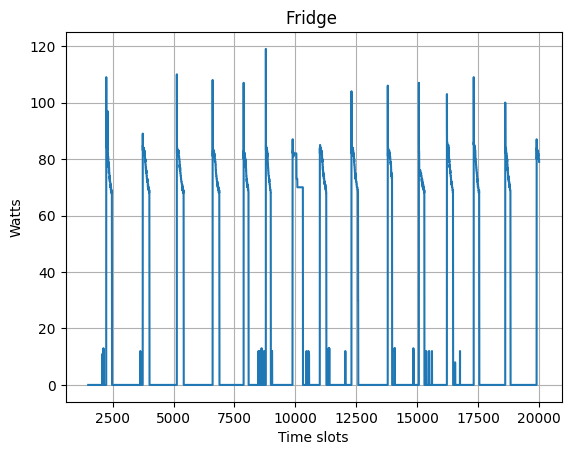

In [ ]:
import matplotlib.pyplot as plt

# Plot all the values in 'Column1'
dataframe['Appliance1'][1500:20000].plot()

# Add labels and title
plt.xlabel('Time slots')
plt.ylabel('Watts')
plt.title('Fridge ')
plt.grid("True")

# Show the plot
plt.show()

# Store the average consumptions of each appliance in the house.

In [7]:
def calculate_avg_appliance_consumption(appliance):

  # Find the maximum and minimum non-zero values
  max_non_zero = dataframe[appliance][dataframe[appliance] != 0].max()
  min_non_zero = dataframe[appliance][dataframe[appliance] != 0].min()

  # Filter the DataFrame to include only values between the maximum and minimum
  filtered_values = dataframe[(dataframe[appliance] > min_non_zero) & (dataframe[appliance] < max_non_zero)][appliance]

  # Calculate the average of the filtered values
  average_between_non_zero = filtered_values.mean()

  return average_between_non_zero

In [8]:
# Save the average consumption of any device in a list.
avg_appliances_consumptions = {}

for i in range(1, len(appliances_dict)+1):
  avg_appliances_consumptions[appliances_dict["Appliance"+str(i)]]=calculate_avg_appliance_consumption("Appliance"+str(i))
  #avg_appliances_consumptions.append((appliances_dict["Appliance"+str(i)],calculate_avg_appliance_consumption("Appliance"+str(i))))

print(avg_appliances_consumptions)


{'Fridge': 75.79845793092484, 'Chest Freezer': 48.08923243274837, 'Upright Freezer': 72.21469605959662, 'Tumble Dryer': 472.6271729522687, 'Washing Machine': 513.3838271002094, 'Dishwasher': 1379.0888017181703, 'Computer Site': 29.738480373322528, 'Television Site': 31.700847769012388, 'Electric Heater': 1007.2853867493128}


# Sostituisco ora tutti i valori in watts presenti con ON e OFF.

In [9]:
discretized_dataframe = dataframe
for i in range(1,len(appliances_dict)+1):
  discretized_dataframe["Appliance"+str(i)] = np.where(dataframe["Appliance"+str(i)] != 0, 'ON', 'OFF')

In [10]:
print(discretized_dataframe)

                        Time        Unix  Aggregate Appliance1 Appliance2  \
0        2013-10-09 13:06:17  1381323977        523         ON        OFF   
1        2013-10-09 13:06:31  1381323991        526         ON        OFF   
2        2013-10-09 13:06:46  1381324006        540         ON        OFF   
3        2013-10-09 13:07:01  1381324021        532         ON        OFF   
4        2013-10-09 13:07:15  1381324035        540         ON        OFF   
...                      ...         ...        ...        ...        ...   
6960003  2015-07-10 11:56:05  1436529365        187        OFF         ON   
6960004  2015-07-10 11:56:12  1436529372        185        OFF         ON   
6960005  2015-07-10 11:56:18  1436529378        181        OFF         ON   
6960006  2015-07-10 11:56:25  1436529385        186        OFF         ON   
6960007  2015-07-10 11:56:32  1436529392        182        OFF         ON   

        Appliance3 Appliance4 Appliance5 Appliance6 Appliance7 Appliance8  

# La cella seguente contiene la funzione che riceve in input il giorno e l'appliance e in output restituisce tutti gli intervalli di funzionamento, ovvero orari (inizio e fine) di ON.

In [11]:
def get_daily_appliance_operating_times(df,day,appliance):
  df['timestamp'] = pd.to_datetime(df['Time'])
  day_to_filter = day

  # Parse the input date string into a datetime object
  date_obj = datetime.strptime(day, '%Y-%m-%d')
  # Get the day of the week (e.g., "Monday")
  day_of_week = date_obj.strftime('%A')  # Return the day name directly

  # Filter rows related to the specific day
  filtered_df = df[df['timestamp'].dt.date == pd.to_datetime(day_to_filter).date()]
  filtered_df.reset_index(drop=True, inplace=True)

  if filtered_df.empty:
    prompt= "The day you have selected is not in the dataset."

  else:
    # Now manage the case of the appliance either ON or OFF all day long.
    if (filtered_df[appliance] == 'ON').all():
      # Case of an appliance always ON during the current day.
      prompt += "From: 00:00:00 To: 23:59:59\n"+"\n***\n\n"
      return prompt
    if (filtered_df[appliance] == 'OFF').all():
      # Case of an appliance always OFF during the current day.
      prompt = "During the day: " +day+" ("+ day_of_week+"), the "+appliances_dict[appliance] +" was never ON.\n"+"\n***\n\n"
      return prompt

    prompt = "During the day: " +day+" ("+ day_of_week+"), the "+appliances_dict[appliance] +" was ON at these times:\n"

    closed_interval = True

    # Iterate over the DataFrame
    for i in range(0, len(filtered_df)):
      if i==0:
        if filtered_df[appliance][i] == 'ON':
          #The appliance is ON since the day before.
          prompt += "From: 00:00:00 "
          closed_interval = False
        continue

      if filtered_df[appliance][i - 1] == 'ON' and filtered_df[appliance][i] == 'OFF':
        prompt += "To: "+ datetime.strptime(filtered_df.loc[i,'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + "\n"
        closed_interval = True
        continue

      if filtered_df[appliance][i - 1] == 'OFF' and filtered_df[appliance][i] == 'ON':
        prompt += "From: "+ datetime.strptime(filtered_df.loc[i,'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " "
        closed_interval = False
        continue

    if closed_interval==False:
      prompt += "To: 23:59:59\n"

  prompt +="\n***\n\n"

  return prompt

In [12]:
print(get_daily_appliance_operating_times(dataframe,'2013-11-18','Appliance1'))

During the day: 2013-11-18 (Monday), the Fridge was ON at these times:
From: 00:00:00 To: 00:03:05
From: 01:46:08 To: 02:16:06
From: 04:07:06 To: 04:37:35
From: 06:35:37 To: 07:06:06
From: 07:17:22 To: 07:17:40
From: 07:21:35 To: 07:21:53
From: 07:23:19 To: 07:23:39
From: 07:47:05 To: 07:47:20
From: 08:29:22 To: 08:30:35
From: 08:47:43 To: 09:07:06
From: 11:04:19 To: 11:34:19
From: 12:10:50 To: 12:11:06
From: 13:19:35 To: 13:19:51
From: 13:34:06 To: 14:05:12
From: 16:05:20 To: 16:37:19
From: 16:44:54 To: 16:45:09
From: 16:45:35 To: 16:45:54
From: 18:29:10 To: 19:03:06
From: 19:05:38 To: 19:06:20
From: 19:32:35 To: 19:33:06
From: 19:34:19 To: 19:34:38
From: 19:37:35 To: 19:38:06
From: 20:10:35 To: 20:11:08
From: 20:12:35 To: 20:13:35
From: 20:17:06 To: 20:46:19
From: 22:28:40 To: 22:59:06

***




# Grazie al prossimo blocco di celle calcolo il costo totale per un giorno.

In [13]:
# La funzione in questa cella conta quante frazioni di ora ci sono in un intervallo.
def count_hours_in_range(interval_start, interval_end, range_start, range_end):
    interval_start = datetime.strptime(interval_start, "%H:%M:%S")
    interval_end = datetime.strptime(interval_end, "%H:%M:%S")
    range_start = datetime.strptime(range_start, "%H:%M:%S")
    range_end = datetime.strptime(range_end, "%H:%M:%S")

    # If the entire interval falls within the range
    if range_start <= interval_start and interval_end <= range_end:
        return (interval_end - interval_start).total_seconds() / 3600  # Convert seconds to hours
    # If the interval completely covers the range
    elif interval_start <= range_start and interval_end >= range_end:
        return (range_end - range_start).total_seconds() / 3600  # Convert seconds to hours
    # If the interval and the range partially overlap
    elif interval_start <= range_end and interval_end >= range_start:
        start = max(interval_start, range_start)
        end = min(interval_end, range_end)
        return (end - start).total_seconds() / 3600  # Convert seconds to hours
    # If there is no overlap
    else:
        return 0

# Example usage:
interval_start = "12:35:48"
interval_end = "14:38:33"
range_start = "08:00:00"
range_end = "19:00:00"

hours_counted = count_hours_in_range(interval_start, interval_end, range_start, range_end)
print("Hours counted within the range:", hours_counted)

Hours counted within the range: 2.0458333333333334


In [14]:
f1_cost= 0.07138
f23_cost= 0.06999

# La funzione riceve in input tutti gli intervalli e stampa il costo del singolo intervallo oltre a quello finale.
def calculate_daily_cost(input_string,day,appliance):
    global avg_appliances_consumptions
    total_cost = 0
    lines = input_string.split('\n')
    for line in lines:
        # Define the regular expression pattern to match words in the format xx:xx:xx
        pattern = r'\b\d{2}:\d{2}:\d{2}\b'

        # Find all occurrences of the pattern in the input string
        matches = re.findall(pattern, line)

        # Extract the first and second occurrences
        from_time = matches[0] if matches else None
        to_time = matches[1] if len(matches) > 1 else None

        try:
          if (from_time != None)  and (to_time!=None):

            # Count the hours in the range 00:00:00 - 08:00:00.
            first_range = count_hours_in_range(from_time,to_time,"00:00:00","08:00:00")

            # Count the hours in the range 08:00:00 - 19:00:00.
            second_range = count_hours_in_range(from_time,to_time,"08:00:00","19:00:00")

            # Count the hours in the range 19:00:00 - 23:59:00.
            third_range = count_hours_in_range(from_time,to_time,"19:00:00","23:59:00")

            # Avg consumption expressed in kw.
            avg_appliance_cons_norm = avg_appliances_consumptions[appliances_dict[appliance]]/100

            # Parse the input date string into a datetime object
            date_obj = datetime.strptime(day, '%Y-%m-%d')
            # Get the day of the week (0: Monday, 1: Tuesday, ..., 6: Sunday)
            day_of_week = date_obj.weekday() + 1  # Adding 1 to start from 1 instead of 0

            if day_of_week != 6 and day_of_week != 7:
              print("From Monday to Friday")
              print("f1 cost: ", f1_cost)
              print("f23 cost: ", f23_cost)
              interval_cost = ((first_range*f23_cost*avg_appliance_cons_norm)+
              (second_range*f1_cost*avg_appliance_cons_norm)+
              (third_range*f23_cost*avg_appliance_cons_norm))
            else:
              print("Saturday or Sunday")
              print("f23 cost: ", f23_cost)
              interval_cost = ((first_range*f23_cost*avg_appliance_cons_norm)+
              (second_range*f23_cost*avg_appliance_cons_norm)+
              (third_range*f23_cost*avg_appliance_cons_norm))

            print("avg_appliance_consumption in watts: ",avg_appliances_consumptions[appliances_dict[appliance]])
            print("First range hours: ",first_range)
            print("Second range hours: ",second_range)
            print("Third range hours: ",third_range)

            total_cost+=interval_cost

            print("Interval cost:", from_time, "To:", to_time, " is equal to:", interval_cost,"\n")
        except:
          continue
    print("Total daily cost for the appliance:", total_cost)
    return total_cost

In [15]:
day = '2014-01-20'
appliance = 'Appliance1'
operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
calculate_daily_cost(operating_times,day,appliance)

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.41638888888888886
Second range hours:  0
Third range hours:  0
Interval cost: 01:12:17 To: 01:37:16  is equal to: 0.02208998881057655 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.41638888888888886
Second range hours:  0
Third range hours:  0
Interval cost: 03:18:47 To: 03:43:46  is equal to: 0.02208998881057655 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.4127777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 05:32:29 To: 05:57:15  is equal to: 0.0218984145246943 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.0038888888888888888
Second range hours:  0
Third r

0.26228160563343184

In [16]:
def calculate_daily_cost_more_appliances(input_string,day):
  # Se trovo il nome di un appliance setto appliance, taglio agli asterischi e chiamo funzione per app singola.
  split_string = input_string.split("***")
  total_cost = 0
  for i in range(4,7):
    appliance = 'Appliance'+str(i)
    print('\n***\n\nStarting with '+appliances_dict[appliance])
    total_cost += calculate_daily_cost(split_string[i-4],day,appliance)

  print("\n* * * * *\nThe total daily cost for all the appliances considered is:", total_cost,"\n")
  return total_cost

In [17]:
def calculate_operating_times_multiple_apps(day):
  operating_times =''
  # From Tumble Dryer (4) to Washdisher (6).
  for i in range(4,7):
    appliance = 'Appliance'+str(i)
    operating_times += get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
  return operating_times

In [18]:
operating_times = calculate_operating_times_multiple_apps('2014-01-20')
print(operating_times)

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***




In [19]:
operating_times = calculate_operating_times_multiple_apps('2013-10-26')
print(operating_times)

During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***




# Few-shot prompt per interagire con Mistral. (First working)

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals within the most expensive slot (F1) INTRADAY (within the same day).
Do not remove any interval.
Do not change the duration of the intervals.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
The time slots to calculate electricity costs of an appliance are as follows:

F1 slot (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 slot (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

# Function to get the Mistral proposal.

In [20]:
def get_mistral_proposal(operating_times,day):
  global prompt
  local_prompt = prompt

  local_prompt+="""
[INST]
"""+calculate_operating_times_multiple_apps(day)+request+"""

ANSWER: [/INST]
"""
  #print(local_prompt)
  response = lcpp_llm(
                    prompt=local_prompt,
                    max_tokens = None,
                    temperature= 0.0,
                    top_p=0.
                    #logprobs=1,
                )
  answer = str(response["choices"][0]["text"]).strip().lower()
  #print(response)
  return answer

In [21]:
def one_day_simulation(day):
  operating_times = calculate_operating_times_multiple_apps(day)
  print(operating_times)
  # Calcolo e stampo il costo di un giorno X.
  actual_cost = calculate_daily_cost_more_appliances(operating_times,day)

  # Calcolo e stampo il costo del giorno X con la proposta Mistral.
  mistral_operating_times = get_mistral_proposal(operating_times,day)
  print(mistral_operating_times)
  mistral_cost = calculate_daily_cost_more_appliances(mistral_operating_times,day)

# Prove Simulazione per singoli giorni.

In [ ]:
day = '2013-10-28'
one_day_simulation(day)

During the day: 2013-10-28 (Monday), the Tumble Dryer was ON at these times:
From: 08:12:28 To: 08:19:28

***

During the day: 2013-10-28 (Monday), the Washing Machine was ON at these times:
From: 13:30:02 To: 14:03:29

***

During the day: 2013-10-28 (Monday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.11666666666666667
Third range hours:  0
Interval cost: 08:12:28 To: 08:19:28  is equal to: 0.0393588155395551 

Total daily cost for the appliance: 0.0393588155395551

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.5575
Third range hours:  0
Interval cost: 13:30:02 To: 14:03:29  is equal to: 0.20429775699965216 

Total daily cost for the appliance: 0.2042977569

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =      90.19 ms /   161 runs   (    0.56 ms per token,  1785.08 tokens per second)
llama_print_timings: prompt eval time =     602.75 ms /   262 tokens (    2.30 ms per token,   434.67 tokens per second)
llama_print_timings:        eval time =   19187.49 ms /   160 runs   (  119.92 ms per token,     8.34 tokens per second)
llama_print_timings:       total time =   21481.37 ms /   422 tokens


during the day: 2013-10-28 (monday), the tumble dryer it is better to be on at these times:
   from: 23:12:28 to: 23:19:28

   ***

   during the day: 2013-10-28 (monday), the washing machine it is better to be on at these times:
   from: 03:30:02 to: 04:03:29

   ***

   during the day: 2013-10-28 (monday), the dishwasher was never on.

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  0.11666666666666667
Interval cost: 23:12:28 To: 23:19:28  is equal to: 0.0385923718074175 

Total daily cost for the appliance: 0.0385923718074175

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.5575
Second range hours:  0
Third range hours:  0
Interval cost: 03:30:02 To: 04:03:29  is equal to: 0.20031941737749584 

Total d

In [ ]:
day = '2013-10-31'
one_day_simulation(day)

During the day: 2013-10-31 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2013-10-31 (Thursday), the Washing Machine was ON at these times:
From: 13:39:31 To: 14:13:02

***

During the day: 2013-10-31 (Thursday), the Dishwasher was ON at these times:
From: 04:29:14 To: 05:07:16
From: 05:07:47 To: 05:09:44
From: 05:09:59 To: 05:10:15
From: 05:10:28 To: 05:10:44
From: 05:10:58 To: 05:11:13
From: 05:11:17 To: 05:11:27
From: 05:11:30 To: 05:11:59
From: 05:12:28 To: 05:12:32
From: 05:13:13 To: 05:13:15

***



<s>
The time slots to calculate electricity costs of an appliance are as follows:

F1 slot (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 slot (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

[INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46


Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     224.27 ms /   365 runs   (    0.61 ms per token,  1627.48 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   46310.41 ms /   365 runs   (  126.88 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   48400.73 ms /   366 tokens


during the day: 2013-10-31 (thursday), the tumble dryer was never on.

***

during the day: 2013-10-31 (thursday), the washing machine it is better to be on at these times:
from: 21:39:31 to: 22:13:02

***

during the day: 2013-10-31 (thursday), the dishwasher it is better to be on at these times:
from: 04:29:14 to: 05:07:16
from: 05:07:47 to: 05:09:44
from: 05:09:59 to: 05:10:15
from: 05:10:28 to: 05:10:44
from: 05:10:58 to: 05:11:13
from: 05:11:17 to: 05:11:27
from: 05:11:30 to: 05:11:59
from: 05:12:28 to: 05:12:32
from: 05:13:13 to: 05:13:15

[note: the answer is the same as the given schedule, but with all the intervals shifted to the night hours.]


In [ ]:
day = '2014-01-01'
one_day_simulation(day)

During the day: 2014-01-01 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2014-01-01 (Wednesday), the Washing Machine was ON at these times:
From: 03:10:47 To: 03:11:00
From: 04:29:29 To: 05:07:14
From: 05:10:32 To: 05:11:01
From: 05:55:59 To: 05:56:14
From: 06:33:45 To: 06:33:47

***

During the day: 2014-01-01 (Wednesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.003611111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 03:10:47 To: 03:11:00  is equal to: 0.0012975348410101874 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.6291666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 04:29:29 To: 05:07:14  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     168.07 ms /   221 runs   (    0.76 ms per token,  1314.91 tokens per second)
llama_print_timings: prompt eval time =    4076.37 ms /  2103 tokens (    1.94 ms per token,   515.90 tokens per second)
llama_print_timings:        eval time =   29199.46 ms /   220 runs   (  132.72 ms per token,     7.53 tokens per second)
llama_print_timings:       total time =   42732.01 ms /  2323 tokens


during the day: 2014-01-01 (wednesday), the tumble dryer was never on.

***

during the day: 2014-01-01 (wednesday), the washing machine it is better to be on at these times:
from: 19:10:47 to: 19:11:00
from: 20:29:29 to: 21:07:14
from: 21:10:32 to: 21:11:01
from: 21:55:59 to: 21:56:14
from: 22:33:45 to: 22:33:47

***

during the day: 2014-01-01 (wednesday), the dishwasher was never on.

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.003611111111111111
Interval cost: 19:10:47 To: 19:11:00  is equal to: 0.0012975348410101874 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.6291666666666667
Interval cost: 20:29:29 To: 21

In [ ]:
day = '2014-01-02'
one_day_simulation(day)

During the day: 2014-01-02 (Thursday), the Tumble Dryer was ON at these times:
From: 13:30:02 To: 13:45:29

***

During the day: 2014-01-02 (Thursday), the Washing Machine was ON at these times:
From: 04:10:46 To: 04:44:59
From: 04:46:32 To: 04:46:46
From: 05:31:45 To: 05:31:59
From: 07:04:48 To: 07:04:59
From: 07:08:46 To: 07:09:00
From: 12:23:00 To: 12:57:14

***

During the day: 2014-01-02 (Thursday), the Dishwasher was ON at these times:
From: 02:18:34 To: 02:54:00
From: 02:54:02 To: 02:54:14
From: 02:54:45 To: 02:55:00
From: 02:55:14 To: 02:55:29

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2575
Third range hours:  0
Interval cost: 13:30:02 To: 13:45:29  is equal to: 0.08687052858373233 

Total daily cost for the appliance: 0.08687052858373233

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     218.06 ms /   368 runs   (    0.59 ms per token,  1687.63 tokens per second)
llama_print_timings: prompt eval time =     747.72 ms /   438 tokens (    1.71 ms per token,   585.78 tokens per second)
llama_print_timings:        eval time =   45686.25 ms /   367 runs   (  124.49 ms per token,     8.03 tokens per second)
llama_print_timings:       total time =   50001.77 ms /   805 tokens


during the day: 2014-01-02 (thursday), the tumble dryer it is better to be on at these times:
from: 23:30:02 to: 23:45:29

***

during the day: 2014-01-02 (thursday), the washing machine it is better to be on at these times:
from: 03:10:46 to: 03:44:59
from: 03:46:32 to: 03:46:46
from: 04:31:45 to: 04:31:59
from: 05:04:48 to: 05:04:59
from: 05:08:46 to: 05:09:00
from: 19:23:00 to: 19:57:14

***

during the day: 2014-01-02 (thursday), the dishwasher it is better to be on at these times:
from: 01:18:34 to: 01:54:00
from: 01:54:02 to: 01:54:14
from: 01:54:45 to: 01:55:00
from: 01:55:14 to: 01:55:29

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  0.2575
Interval cost: 23:30:02 To: 23:45:29  is equal to: 0.0851788777749429 

Total daily cost for the appliance: 0.0851788777749429

***

Starting with Washing Machine
From Monday to 

In [ ]:
day = '2014-01-03'
one_day_simulation(day)

During the day: 2014-01-03 (Friday), the Tumble Dryer was ON at these times:
From: 13:13:14 To: 13:28:45
From: 13:39:14 To: 13:56:17

***

During the day: 2014-01-03 (Friday), the Washing Machine was ON at these times:
From: 04:29:00 To: 05:02:15
From: 05:05:14 To: 05:05:33
From: 07:56:29 To: 07:56:30
From: 20:34:16 To: 20:34:18
From: 20:41:17 To: 20:41:32

***

During the day: 2014-01-03 (Friday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2586111111111111
Third range hours:  0
Interval cost: 13:13:14 To: 13:28:45  is equal to: 0.08724537444601381 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.2841666666666667
Third range hours:  0
Interval cost: 13:39:14 To: 13:56:17  is equal to: 0.0958668

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     148.68 ms /   247 runs   (    0.60 ms per token,  1661.25 tokens per second)
llama_print_timings: prompt eval time =    1456.64 ms /   344 tokens (    4.23 ms per token,   236.16 tokens per second)
llama_print_timings:        eval time =   31146.41 ms /   246 runs   (  126.61 ms per token,     7.90 tokens per second)
llama_print_timings:       total time =   35097.13 ms /   590 tokens


during the day: 2014-01-03 (friday), the tumble dryer it is better to be on at these times:
from: 01:13:14 to: 01:28:45
from: 01:39:14 to: 01:56:17

***

during the day: 2014-01-03 (friday), the washing machine it is better to be on at these times:
from: 18:29:00 to: 19:02:15
from: 19:05:14 to: 19:05:33
from: 23:56:29 to: 23:56:30
from: 23:41:17 to: 23:41:32

***

during the day: 2014-01-03 (friday), the dishwasher was never on.

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.2586111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 01:13:14 To: 01:28:45  is equal to: 0.0855464241731088 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.2841666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 01:39:14 To: 01:56:17  is equal to: 0.0939999913309

In [ ]:
day = '2014-01-04'
one_day_simulation(day)

During the day: 2014-01-04 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2014-01-04 (Saturday), the Washing Machine was ON at these times:
From: 04:25:45 To: 05:00:46
From: 05:03:47 To: 05:03:59
From: 06:31:29 To: 06:31:45
From: 06:35:33 To: 06:35:40
From: 07:55:15 To: 07:55:29

***

During the day: 2014-01-04 (Saturday), the Dishwasher was ON at these times:
From: 01:49:28 To: 02:26:01
From: 02:27:14 To: 02:27:29
From: 17:14:45 To: 17:14:59

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.5836111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 04:25:45 To: 05:00:46  is equal to: 0.20970159238172337 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0033333333333333335
Second range hours:  0
Third range h

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     172.82 ms /   293 runs   (    0.59 ms per token,  1695.42 tokens per second)
llama_print_timings: prompt eval time =    1047.81 ms /   367 tokens (    2.86 ms per token,   350.26 tokens per second)
llama_print_timings:        eval time =   36825.21 ms /   292 runs   (  126.11 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   40755.54 ms /   659 tokens


during the day: 2014-01-04 (saturday), the tumble dryer was never on.

***

during the day: 2014-01-04 (saturday), the washing machine it is better to be on at these times:
from: 19:25:45 to: 20:00:46
from: 20:03:47 to: 20:03:59
from: 08:31:29 to: 08:31:45
from: 08:35:33 to: 08:35:40
from: 10:55:15 to: 10:55:29

***

during the day: 2014-01-04 (saturday), the dishwasher it is better to be on at these times:
from: 18:49:28 to: 19:26:01
from: 19:27:14 to: 19:27:29
from: 13:14:45 to: 13:14:59

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.5836111111111111
Interval cost: 19:25:45 To: 20:00:46  is equal to: 0.20970159238172337 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third rang

In [ ]:
day = '2014-01-06'
one_day_simulation(day)

During the day: 2014-01-06 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-06 (Monday), the Washing Machine was ON at these times:
From: 22:38:46 To: 22:39:00

***

During the day: 2014-01-06 (Monday), the Dishwasher was ON at these times:
From: 02:29:33 To: 03:07:00
From: 03:07:15 To: 03:08:14
From: 03:08:29 To: 03:09:01
From: 03:09:02 To: 03:09:15

***



***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.0038888888888888888
Interval cost: 22:38:46 To: 22:39:00  is equal to: 0.0013973452133955865 

Total daily cost for the appliance: 0.0013973452133955865

***

Starting with Dishwasher
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  1379.0888017181703
First range hours:  0.624166666

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     165.99 ms /   274 runs   (    0.61 ms per token,  1650.71 tokens per second)
llama_print_timings: prompt eval time =    3293.73 ms /  2179 tokens (    1.51 ms per token,   661.56 tokens per second)
llama_print_timings:        eval time =   35120.40 ms /   273 runs   (  128.65 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =   47952.98 ms /  2452 tokens


during the day: 2014-01-06 (monday), the tumble dryer was never on.

***

during the day: 2014-01-06 (monday), the washing machine it is better to be on at these times:
from: 05:38:46 to: 05:39:00

***

during the day: 2014-01-06 (monday), the dishwasher it is better to be on at these times:
from: 02:29:33 to: 03:07:00
from: 03:07:15 to: 03:08:14
from: 03:08:29 to: 03:09:01
from: 03:09:02 to: 03:09:15

[note: the washing machine interval from 22:38:46 to 22:39:00 is already in the cheapest slot, so it does not need to be shifted.]

***

Starting with Tumble Dryer
Total daily cost for the appliance: 0

***

Starting with Washing Machine
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.0038888888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 05:38:46 To: 05:39:00  is equal to: 0.0013973452133955865 

Total daily cost for the appliance: 0.0013973452133955865

***

Starting with Di

In [ ]:
day = '2014-01-07'
one_day_simulation(day)

During the day: 2014-01-07 (Tuesday), the Tumble Dryer was ON at these times:
From: 18:19:17 To: 18:19:31
From: 20:44:28 To: 20:46:01

***

During the day: 2014-01-07 (Tuesday), the Washing Machine was ON at these times:
From: 01:40:46 To: 01:40:48
From: 02:36:59 To: 02:37:03
From: 03:18:46 To: 03:18:48
From: 04:34:01 To: 05:09:01
From: 05:12:00 To: 05:12:15
From: 05:24:00 To: 05:24:02
From: 05:59:59 To: 06:00:14
From: 06:19:34 To: 06:19:46
From: 06:51:19 To: 06:51:30
From: 06:59:51 To: 07:00:07
From: 11:49:15 To: 12:22:33
From: 23:45:46 To: 23:46:01

***

During the day: 2014-01-07 (Tuesday), the Dishwasher was never ON.

***



***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.0038888888888888888
Third range hours:  0
Interval cost: 18:19:17 To: 18:19:31  is equal to: 0.0013119605179851698 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.0

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2763.47 ms
llama_print_timings:      sample time =     245.56 ms /   408 runs   (    0.60 ms per token,  1661.52 tokens per second)
llama_print_timings: prompt eval time =    1026.03 ms /   519 tokens (    1.98 ms per token,   505.84 tokens per second)
llama_print_timings:        eval time =   52488.95 ms /   407 runs   (  128.97 ms per token,     7.75 tokens per second)
llama_print_timings:       total time =   57408.28 ms /   926 tokens


during the day: 2014-01-07 (tuesday), the tumble dryer it is better to be on at these times:
from: 00:19:17 to: 00:19:31
from: 02:44:28 to: 02:46:01

***

during the day: 2014-01-07 (tuesday), the washing machine it is better to be on at these times:
from: 03:40:46 to: 03:40:48
from: 04:36:59 to: 04:37:03
from: 05:18:46 to: 05:18:48
from: 06:04:01 to: 06:09:01
from: 06:12:00 to: 06:12:15
from: 06:24:00 to: 06:24:02
from: 06:59:59 to: 07:00:14
from: 07:19:34 to: 07:19:46
from: 08:51:19 to: 08:51:30
from: 22:59:51 to: 23:00:07
from: 23:45:46 to: 00:46:01

***

during the day: 2014-01-07 (tuesday), the dishwasher was never on.

***

Starting with Tumble Dryer
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0.0038888888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 00:19:17 To: 00:19:31  is equal to: 0.0012864123935805833 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999


# Function to calculate the results for one appliance and one period (week, month etc...).

In [23]:
# The following function returns two dictionaries (i.e., one for the actual costs and one for the mistral proposal's costs)
def start_simulation(interval_start,interval_end,appliance):
  actual_costs={}
  mistral_costs={}

  # Convert the input date strings to datetime objects
  start_date = datetime.strptime(interval_start, '%Y-%m-%d')
  end_date = datetime.strptime(interval_end, '%Y-%m-%d')

  # Define the timedelta to increment the date
  delta = timedelta(days=1)

  # Iterate over the range of dates
  current_date = start_date
  while current_date <= end_date:
    print("\n- - - - - - - ")
    day = current_date.strftime('%Y-%m-%d')
    operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
    print(operating_times)
    # Calcolo e stampo il costo di un giorno X.
    #print(calculate_daily_cost(operating_times,appliance,day))
    actual_cost = calculate_daily_cost(operating_times,day,appliance)

    # Calcolo e stampo il costo del giorno X con la proposta Mistral.
    mistral_operating_times = get_mistral_proposal(operating_times,day,appliance)
    print(mistral_operating_times)
    mistral_cost = calculate_daily_cost(mistral_operating_times,day,appliance)

    actual_costs[day]=actual_cost
    mistral_costs[day]=mistral_cost

    # Define the directory path
    folder_name = appliances_dict[appliance]
    file_name = appliances_dict[appliance]+"_"+day+".txt"
    directory_path = os.path.join(os.getcwd(), folder_name)

    # Create the directory if it doesn't exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Define the file path
    file_path = os.path.join(directory_path, file_name)

    with open(file_path, 'w') as f:
      # Write some content to the file
      f.write("\n- - - - - - -\n ")
      f.write(str(operating_times)+"\n")
      f.write("The total actual daily cost is:"+str(actual_cost)+"\n")
      f.write("Mistral operating times:\n"+str(mistral_operating_times)+"\n")
      f.write("The total Mistral daily cost is:"+str(mistral_cost)+"\n")
      f.write("Saved: "+str(actual_cost-mistral_cost))

    # Move to the next date
    current_date += delta

  return actual_costs,mistral_costs

# Function to calculate the results for more appliances and one period (week, month etc...).

In [22]:
# The following function returns two dictionaries (i.e., one for the actual costs and one for the mistral proposal's costs)
def start_simulation_more_appliances(interval_start,interval_end):
  actual_costs={}
  mistral_costs={}

  # Convert the input date strings to datetime objects
  start_date = datetime.strptime(interval_start, '%Y-%m-%d')
  end_date = datetime.strptime(interval_end, '%Y-%m-%d')

  # Define the timedelta to increment the date
  delta = timedelta(days=1)

  # Iterate over the range of dates
  current_date = start_date
  while current_date <= end_date:
    print("\n- - - - - - - ")
    day = current_date.strftime('%Y-%m-%d')
    operating_times = calculate_operating_times_multiple_apps(day)
    print(operating_times)
    # Calcolo e stampo il costo di un giorno X.
    #print(calculate_daily_cost(operating_times,appliance,day))
    #actual_cost = calculate_daily_cost_more_appliances(operating_times,day)

    # Calcolo e stampo il costo del giorno X con la proposta Mistral.
    mistral_operating_times = get_mistral_proposal(operating_times,day)
    print(mistral_operating_times)
    #mistral_cost = calculate_daily_cost_more_appliances(mistral_operating_times,day)

    #actual_costs[day]=actual_cost
    #mistral_costs[day]=mistral_cost

    # Define the directory path
    folder_name = 'multiple_appliances'
    file_name = 'multiple_appliances'+"_"+day+".txt"
    directory_path = os.path.join(os.getcwd(), folder_name)

    # Create the directory if it doesn't exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Define the file path
    file_path = os.path.join(directory_path, file_name)

    with open(file_path, 'w') as f:
      # Write some content to the file
      f.write("\n- - - - - - -\n ")
      f.write(str(operating_times)+"\n")
      #f.write("The total actual daily cost is:"+str(actual_cost)+"\n")
      f.write("Mistral operating times:\n"+str(mistral_operating_times)+"\n")
      #f.write("The total Mistral daily cost is:"+str(mistral_cost)+"\n")
      #f.write("Saved: "+str(actual_cost-mistral_cost))

    # Move to the next date
    current_date += delta

  return actual_costs,mistral_costs

# Simulation for a full period with 3 appliances.

## Experimental prompt #1

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals falling within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Do not delete appliance usage intervals.
Do not change the duration of the appliances usage time slots.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals falling within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Do not delete appliance usage intervals.
Do not change the duration of the appliances usage time slots.
Do not shift intervals already in the cheapest slots.
Do not propose to use more appliances at the same time.
Avoid explanations.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2014-01-01','2014-01-03')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2014-01-01 (Wednesday), the Washing Machine was ON at these times:
From: 03:10:47 To: 03:11:00
From: 04:29:29 To: 05:07:14
From: 05:10:32 To: 05:11:01
From: 05:55:59 To: 05:56:14
From: 06:33:45 To: 06:33:47

***

During the day: 2014-01-01 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     236.67 ms /   208 runs   (    1.14 ms per token,   878.88 tokens per second)
llama_print_timings: prompt eval time =    5813.10 ms /  2371 tokens (    2.45 ms per token,   407.87 tokens per second)
llama_print_timings:        eval time =   30774.87 ms /   207 runs   (  148.67 ms per token,     6.73 tokens per second)
llama_print_timings:       total time =   50955.26 ms /  2578 tokens


during the day: 2014-01-01 (wednesday), the washing machine it is better to be on at these times:
from: 19:10:47 to: 20:11:00
from: 20:29:29 to: 21:07:14
from: 21:10:32 to: 21:11:01
from: 21:55:59 to: 21:56:14
from: 22:33:45 to: 22:33:47

***

during the day: 2014-01-01 (wednesday), the dishwasher was never on.

(no change for the dishwasher as it was not used during the most expensive slot)

- - - - - - - 
During the day: 2014-01-02 (Thursday), the Tumble Dryer was ON at these times:
From: 13:30:02 To: 13:45:29

***

During the day: 2014-01-02 (Thursday), the Washing Machine was ON at these times:
From: 04:10:46 To: 04:44:59
From: 04:46:32 To: 04:46:46
From: 05:31:45 To: 05:31:59
From: 07:04:48 To: 07:04:59
From: 07:08:46 To: 07:09:00
From: 12:23:00 To: 12:57:14

***

During the day: 2014-01-02 (Thursday), the Dishwasher was ON at these times:
From: 02:18:34 To: 02:54:00
From: 02:54:02 To: 02:54:14
From: 02:54:45 To: 02:55:00
From: 02:55:14 To: 02:55:29

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     244.34 ms /   345 runs   (    0.71 ms per token,  1411.94 tokens per second)
llama_print_timings: prompt eval time =    1604.72 ms /   458 tokens (    3.50 ms per token,   285.41 tokens per second)
llama_print_timings:        eval time =   48970.04 ms /   344 runs   (  142.35 ms per token,     7.02 tokens per second)
llama_print_timings:       total time =   54748.45 ms /   802 tokens


during the day: 2014-01-02 (thursday), the tumble dryer it is better to be on at these times:
from: 20:30:02 to: 21:45:29

***

during the day: 2014-01-02 (thursday), the washing machine it is better to be on at these times:
from: 04:10:46 to: 04:44:59
from: 04:46:32 to: 04:46:46
from: 05:31:45 to: 05:31:59
from: 07:08:46 to: 07:09:00
from: 19:23:00 to: 19:57:14

***

during the day: 2014-01-02 (thursday), the dishwasher it is better to be on at these times:
from: 02:18:34 to: 02:54:00
from: 02:54:02 to: 02:54:14
from: 02:54:45 to: 02:55:00
from: 02:55:14 to: 02:55:29

- - - - - - - 
During the day: 2014-01-03 (Friday), the Tumble Dryer was ON at these times:
From: 13:13:14 To: 13:28:45
From: 13:39:14 To: 13:56:17

***

During the day: 2014-01-03 (Friday), the Washing Machine was ON at these times:
From: 04:29:00 To: 05:02:15
From: 05:05:14 To: 05:05:33
From: 07:56:29 To: 07:56:30
From: 20:34:16 To: 20:34:18
From: 20:41:17 To: 20:41:32

***

During the day: 2014-01-03 (Friday), the Dis

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     180.49 ms /   270 runs   (    0.67 ms per token,  1495.95 tokens per second)
llama_print_timings: prompt eval time =     864.54 ms /   364 tokens (    2.38 ms per token,   421.03 tokens per second)
llama_print_timings:        eval time =   35040.25 ms /   269 runs   (  130.26 ms per token,     7.68 tokens per second)
llama_print_timings:       total time =   38799.84 ms /   633 tokens


during the day: 2014-01-03 (friday), the tumble dryer it is better to be on at these times:
from: 19:13:14 to: 20:28:45
from: 20:39:14 to: 20:56:17

***

during the day: 2014-01-03 (friday), the washing machine it is better to be on at these times:
from: 04:29:00 to: 05:02:15
from: 05:05:14 to: 05:05:33
from: 05:07:16 to: 05:38:15
from: 19:34:16 to: 19:34:18
from: 19:41:17 to: 19:41:32

***

during the day: 2014-01-03 (friday), the dishwasher was never on.


## Experimental prompt #2
Re-put the request before the answer.

In [ ]:
# Funziona bene da 2014-01-01 a 2014-01-05. Poi no.
request = """
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

Propose a new scheduling to reduce electricity cost. Shift the appliance usage intervals that are within the most expensive slot (F1).
Shift only INTRADAY (within the same day).
Keep the same appliance usage intervals.
Keep the same duration of the intervals for any interval.
Shift only the intervals in the most expensive slots.
Propose to use only one appliance per time.
Avoid explanations.
"""

# Nuovi tentativi.
#request = """
#Shift the appliance usage intervals INTRADAY (within the same day) to reduce electricity cost. DO NOT SHIFT INTERVALS ALREADY IN THE CHEAPEST SLOT.
#DO NOT CHANGE THE DURATION AND THE NUMBER OF THE INTERVALS, DO NOT PROPOSE TO USE MORE APPLIANCES AT THE SAME TIME. AVOID EXPLANATIONS.
#"""

prompt = """
<s>[INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      79.34 ms /   117 runs   (    0.68 ms per token,  1474.72 tokens per second)
llama_print_timings: prompt eval time =    2563.91 ms /   312 tokens (    8.22 ms per token,   121.69 tokens per second)
llama_print_timings:        eval time =   14943.23 ms /   116 runs   (  128.82 ms per token,     7.76 tokens per second)
llama_print_timings:       total time =   20143.76 ms /   428 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 23:21:24 to: 02:54:43

***

[explanation: shifting the washing machine usage interval from 7:21 am to 11:21 pm allows it to be operated during the cheapest rate (f23) instead of the most expensive rate (f1).]

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     240.81 ms /   384 runs   (    0.63 ms per token,  1594.60 tokens per second)
llama_print_timings: prompt eval time =    1182.54 ms /   514 tokens (    2.30 ms per token,   434.66 tokens per second)
llama_print_timings:        eval time =   49604.23 ms /   383 runs   (  129.51 ms per token,     7.72 tokens per second)
llama_print_timings:       total time =   55132.13 ms /   897 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 00:00:47 to: 00:01:28

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 03:51:48 to: 04:21:55
from: 05:30:59 to: 06:04:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 23:31:00 to: 23:31:07
from: 09:49:55 to: 10:20:35
from: 12:30:49 to: 12:31:22
from: 12:31:36 to: 12:31:43
from: 12:31:56 to: 12:32:03

[note: the new scheduling keeps the same appliance usage intervals but shifts them to be outside of the most expensive slot (f1) whenever possible. in this case, the tumble dryer is shifted to the middle of the night and the washing machine is shifted to early morning.]

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Ma

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     100.08 ms /   158 runs   (    0.63 ms per token,  1578.67 tokens per second)
llama_print_timings: prompt eval time =    1530.52 ms /   331 tokens (    4.62 ms per token,   216.27 tokens per second)
llama_print_timings:        eval time =   19803.65 ms /   157 runs   (  126.14 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   23554.36 ms /   488 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 20:38:24 to: 20:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 09:01:52 to: 09:34:37

***

during the day: 2015-06-03 (wednesday), the dishwasher was never on.


## Experimental prompt #3.

In [ ]:
request = """
Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations.
"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

ANSWER: [/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28

[INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer was ON at these times:
From: 15:00:47 To: 15:01:28

***

During the day: 2013-10-29 (Tuesday), the Washing Machine was ON at these times:
From: 10:55:27 To: 11:37:00
From: 11:51:47 To: 11:51:59
From: 12:07:40 To: 12:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher was ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

***

"""+request+"""

ANSWER: [/INST]
During the day: 2013-10-29 (Tuesday), the Tumble Dryer it is better to be ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2013-10-29 (Tuesday), the Washing Machine it is better to be ON at these times:
From: 04:55:27 To: 05:37:00
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-29 (Tuesday), the Dishwasher it is better to be ON at these times:
From: 03:14:59 To: 03:54:18
From: 03:54:30 To: 03:55:13
From: 03:55:28 To: 03:56:58
From: 03:57:13 To: 03:57:18
From: 03:57:29 To: 03:57:58
From: 03:58:44 To: 03:58:59
From: 03:59:45 To: 03:59:59
From: 04:00:33 To: 04:00:36
From: 04:01:23 To: 04:01:32
From: 04:04:27 To: 04:04:32

</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      54.81 ms /    66 runs   (    0.83 ms per token,  1204.07 tokens per second)
llama_print_timings: prompt eval time =    6097.89 ms /  2143 tokens (    2.85 ms per token,   351.43 tokens per second)
llama_print_timings:        eval time =    8592.70 ms /    65 runs   (  132.20 ms per token,     7.56 tokens per second)
llama_print_timings:       total time =   24458.12 ms /  2208 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 19:21:24 to: 19:54:43

[end of answer]

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     302.67 ms /   437 runs   (    0.69 ms per token,  1443.80 tokens per second)
llama_print_timings: prompt eval time =    2069.40 ms /   407 tokens (    5.08 ms per token,   196.68 tokens per second)
llama_print_timings:        eval time =   56615.48 ms /   436 runs   (  129.85 ms per token,     7.70 tokens per second)
llama_print_timings:       total time =   63388.23 ms /   843 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 19:00:47 to: 19:01:28

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 03:12:20 to: 03:12:26
from: 05:21:48 to: 05:21:55
from: 07:29:59 to: 07:54:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 08:31:00 to: 08:31:07
from: 10:49:55 to: 11:10:35
from: 11:10:49 to: 11:11:22
from: 11:11:36 to: 11:11:43
from: 11:11:56 to: 11:12:03
from: 11:12:16 to: 11:12:18
from: 11:12:33 to: 11:12:36
from: 11:13:24 to: 11:13:27
from: 11:13:39 to: 11:13:42

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Machine was ON at these times:
From: 09:01:52 To: 09:34:37

***

During the day: 2015-06-03 (Wednesday), the Dishwasher was never ON.


Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      88.97 ms /   123 runs   (    0.72 ms per token,  1382.50 tokens per second)
llama_print_timings: prompt eval time =    1760.78 ms /   224 tokens (    7.86 ms per token,   127.22 tokens per second)
llama_print_timings:        eval time =   15956.68 ms /   122 runs   (  130.79 ms per token,     7.65 tokens per second)
llama_print_timings:       total time =   19475.43 ms /   346 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 19:38:24 to: 19:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 13:01:52 to: 13:34:37


## Experimental prompt #4
(Simplified prompt)--> Non malissimo.

In [ ]:
request = """
Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations.
"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
During the day: 2013-10-26 (Saturday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-26 (Saturday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-26 (Saturday), the Dishwasher it is better to be ON at these times:
From: 18:09:18 To: 18:09:28


</s>

  """

In [ ]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-01','2015-06-03')


- - - - - - - 
During the day: 2015-06-01 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-01 (Monday), the Washing Machine was ON at these times:
From: 07:21:24 To: 07:54:43

***

During the day: 2015-06-01 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =      53.80 ms /    59 runs   (    0.91 ms per token,  1096.57 tokens per second)
llama_print_timings: prompt eval time =    3542.93 ms /  1110 tokens (    3.19 ms per token,   313.30 tokens per second)
llama_print_timings:        eval time =    7545.34 ms /    58 runs   (  130.09 ms per token,     7.69 tokens per second)
llama_print_timings:       total time =   16602.14 ms /  1168 tokens


during the day: 2015-06-01 (monday), the washing machine it is better to be on at these times:
from: 19:21:24 to: 20:54:43

- - - - - - - 
During the day: 2015-06-02 (Tuesday), the Tumble Dryer was ON at these times:
From: 06:00:47 To: 06:01:28

***

During the day: 2015-06-02 (Tuesday), the Washing Machine was ON at these times:
From: 00:12:20 To: 00:12:26
From: 02:51:48 To: 02:51:55
From: 05:30:59 To: 06:04:36
From: 07:03:19 To: 07:03:26

***

During the day: 2015-06-02 (Tuesday), the Dishwasher was ON at these times:
From: 10:31:00 To: 10:31:07
From: 11:49:55 To: 12:30:35
From: 12:30:49 To: 12:31:22
From: 12:31:36 To: 12:31:43
From: 12:31:56 To: 12:32:03

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     236.97 ms /   345 runs   (    0.69 ms per token,  1455.86 tokens per second)
llama_print_timings: prompt eval time =    1878.23 ms /   407 tokens (    4.61 ms per token,   216.69 tokens per second)
llama_print_timings:        eval time =   45079.32 ms /   344 runs   (  131.04 ms per token,     7.63 tokens per second)
llama_print_timings:       total time =   51083.80 ms /   751 tokens


during the day: 2015-06-02 (tuesday), the tumble dryer it is better to be on at these times:
from: 06:01:28 to: 06:02:13

***

during the day: 2015-06-02 (tuesday), the washing machine it is better to be on at these times:
from: 04:12:20 to: 04:12:26
from: 03:51:48 to: 04:21:55
from: 07:30:59 to: 08:04:36
from: 19:03:19 to: 19:03:26

***

during the day: 2015-06-02 (tuesday), the dishwasher it is better to be on at these times:
from: 11:31:00 to: 11:31:07
from: 12:49:55 to: 13:20:35
from: 13:20:49 to: 13:21:22
from: 13:21:36 to: 13:21:43
from: 13:21:56 to: 13:22:03

- - - - - - - 
During the day: 2015-06-03 (Wednesday), the Tumble Dryer was ON at these times:
From: 05:38:24 To: 05:38:51

***

During the day: 2015-06-03 (Wednesday), the Washing Machine was ON at these times:
From: 09:01:52 To: 09:34:37

***

During the day: 2015-06-03 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    4051.47 ms
llama_print_timings:      sample time =     115.85 ms /   160 runs   (    0.72 ms per token,  1381.06 tokens per second)
llama_print_timings: prompt eval time =    1707.16 ms /   224 tokens (    7.62 ms per token,   131.21 tokens per second)
llama_print_timings:        eval time =   21114.22 ms /   159 runs   (  132.79 ms per token,     7.53 tokens per second)
llama_print_timings:       total time =   24694.68 ms /   383 tokens


during the day: 2015-06-03 (wednesday), the tumble dryer it is better to be on at these times:
from: 05:38:24 to: 05:38:51

***

during the day: 2015-06-03 (wednesday), the washing machine it is better to be on at these times:
from: 19:01:52 to: 19:34:37



***

during the day: 2015-06-03 (wednesday), the dishwasher was never on.


## Experimental prompt #5
(Simplified prompt)

In [24]:
request = """

Generate new time intervals (keep the same number of intervals and keep the same duration for each interval) to reduce electricity cost.
Shift only the intervals that are within the most expensive rate (F1). Shift only INTRADAY (within the same day).
Use only one appliance per time.
Avoid explanations and always output the intervals for all the appliances.

"""


prompt = """
<s>[INST]
The daily rates to calculate electricity costs of an appliance are as follows:

F1 rate (the most expensive) -> From 08:00 to 19:00, Monday to Friday.
F23 rate (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine was ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 12:38:03 To: 13:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher was ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

***

"""+request+"""

[/INST]
- - - - -

During the day: 2014-01-20 (Monday), the Tumble Dryer was never ON.

***

During the day: 2014-01-20 (Monday), the Washing Machine it is better to be ON at these times:
From: 04:29:16 To: 05:05:46
From: 05:08:33 To: 05:08:46
From: 05:16:34 To: 05:16:46
From: 06:49:47 To: 06:50:02
From: 07:00:15 To: 07:00:30
From: 07:04:15 To: 07:04:29
From: 19:38:03 To: 20:16:48

***

During the day: 2014-01-20 (Monday), the Dishwasher it is better to be ON at these times:
From: 02:33:00 To: 03:12:15
From: 03:12:32 To: 03:12:47
From: 03:12:48 To: 03:13:16
From: 03:13:32 To: 03:14:34
From: 03:16:01 To: 03:16:16

[INST]
- - - - -

During the day: 2013-10-25 (Friday), the Tumble Dryer was ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine was ON at these times:
From: 06:33:28 To: 07:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher was ON at these times:
From: 18:09:18 To: 18:09:28

***

"""+request+"""

[/INST]
- - - - -
During the day: 2013-10-25 (Friday), the Tumble Dryer it is better to be ON at these times:
From: 05:51:47 To: 05:51:59
From: 06:07:40 To: 06:41:59

***

During the day: 2013-10-25 (Friday), the Washing Machine it is better to be ON at these times:
From: 11:33:28 To: 12:09:44

***

During the day: 2013-10-25 (Friday), the Dishwasher it is better to be ON at these times:
From: 20:09:18 To: 20:09:28


</s>

  """

In [26]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-05','2015-06-07')


- - - - - - - 
During the day: 2015-06-05 (Friday), the Tumble Dryer was never ON.

***

During the day: 2015-06-05 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-05 (Friday), the Dishwasher was ON at these times:
From: 12:11:08 To: 12:23:25
From: 12:23:27 To: 12:53:10
From: 12:53:17 To: 12:53:37
From: 12:53:51 To: 12:54:24
From: 12:54:38 To: 12:54:44
From: 12:54:51 To: 12:55:04
From: 12:55:18 To: 12:55:39
From: 12:56:06 To: 12:56:13
From: 19:14:38 To: 19:14:52

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     207.97 ms /   310 runs   (    0.67 ms per token,  1490.56 tokens per second)
llama_print_timings: prompt eval time =    2448.92 ms /   390 tokens (    6.28 ms per token,   159.25 tokens per second)
llama_print_timings:        eval time =   39232.77 ms /   309 runs   (  126.97 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   44938.11 ms /   699 tokens


during the day: 2015-06-05 (friday), the tumble dryer was never on.

***

during the day: 2015-06-05 (friday), the washing machine was never on.

***

during the day: 2015-06-05 (friday), the dishwasher it is better to be on at these times:
from: 03:11:08 to: 03:23:25
from: 03:23:27 to: 04:53:10
from: 04:53:17 to: 04:53:37
from: 04:53:51 to: 04:54:24
from: 04:54:38 to: 04:54:44
from: 04:54:51 to: 04:55:04
from: 04:55:18 to: 04:55:39
from: 04:56:06 to: 04:56:13
from: 23:14:38 to: 23:14:52

- - - - - - - 
During the day: 2015-06-06 (Saturday), the Tumble Dryer was ON at these times:
From: 15:49:16 To: 15:56:15

***

During the day: 2015-06-06 (Saturday), the Washing Machine was ON at these times:
From: 09:00:02 To: 09:00:08
From: 09:00:15 To: 09:34:37
From: 09:39:28 To: 10:38:30
From: 10:40:45 To: 11:14:40
From: 11:15:00 To: 11:15:07
From: 11:18:30 To: 11:53:39
From: 15:09:43 To: 15:21:13

***

During the day: 2015-06-06 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     175.61 ms /   303 runs   (    0.58 ms per token,  1725.45 tokens per second)
llama_print_timings: prompt eval time =    1816.82 ms /   369 tokens (    4.92 ms per token,   203.10 tokens per second)
llama_print_timings:        eval time =   38097.12 ms /   302 runs   (  126.15 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =   43018.58 ms /   671 tokens


during the day: 2015-06-06 (saturday), the tumble dryer it is better to be on at these times:
from: 15:49:16 to: 15:56:15

***

during the day: 2015-06-06 (saturday), the washing machine it is better to be on at these times:
from: 03:00:02 to: 03:00:08
from: 03:00:15 to: 03:34:37
from: 03:39:28 to: 14:38:30
from: 14:40:45 to: 15:14:40
from: 15:15:00 to: 15:15:07
from: 15:18:30 to: 15:53:39
from: 23:09:43 to: 23:21:13

***

during the day: 2015-06-06 (saturday), the dishwasher it is better to be on at these times:
n/a

- - - - - - - 
During the day: 2015-06-07 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-07 (Sunday), the Washing Machine was never ON.

***

During the day: 2015-06-07 (Sunday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      72.86 ms /   116 runs   (    0.63 ms per token,  1592.16 tokens per second)
llama_print_timings: prompt eval time =    1155.68 ms /   184 tokens (    6.28 ms per token,   159.21 tokens per second)
llama_print_timings:        eval time =   14776.03 ms /   115 runs   (  128.49 ms per token,     7.78 tokens per second)
llama_print_timings:       total time =   17193.72 ms /   299 tokens


- - - - -

during the day: 2015-06-07 (sunday), the tumble dryer does not need to be on.

***

during the day: 2015-06-07 (sunday), the washing machine does not need to be on.

***

during the day: 2015-06-07 (sunday), the dishwasher does not need to be on.


In [27]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-08','2015-06-11')


- - - - - - - 
During the day: 2015-06-08 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-08 (Monday), the Washing Machine was never ON.

***

During the day: 2015-06-08 (Monday), the Dishwasher was ON at these times:
From: 10:10:53 To: 10:50:53
From: 10:51:00 To: 10:51:13
From: 10:51:20 To: 10:51:27
From: 10:51:41 To: 10:51:47
From: 10:51:54 To: 10:52:14

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      95.24 ms /   152 runs   (    0.63 ms per token,  1595.92 tokens per second)
llama_print_timings: prompt eval time =    1790.67 ms /   301 tokens (    5.95 ms per token,   168.09 tokens per second)
llama_print_timings:        eval time =   18206.23 ms /   151 runs   (  120.57 ms per token,     8.29 tokens per second)
llama_print_timings:       total time =   22080.50 ms /   452 tokens


during the day: 2015-06-08 (monday), the dishwasher it is better to be on at these times:
from: 23:10:53 to: 00:50:53
from: 00:51:00 to: 00:51:13
from: 00:51:20 to: 00:51:27
from: 00:51:41 to: 00:51:47
from: 00:51:54 to: 00:52:14

- - - - - - - 
During the day: 2015-06-09 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-09 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-06-09 (Tuesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      71.95 ms /   112 runs   (    0.64 ms per token,  1556.55 tokens per second)
llama_print_timings: prompt eval time =    1639.74 ms /   181 tokens (    9.06 ms per token,   110.38 tokens per second)
llama_print_timings:        eval time =   13631.67 ms /   111 runs   (  122.81 ms per token,     8.14 tokens per second)
llama_print_timings:       total time =   17115.72 ms /   292 tokens


- - - - -
during the day: 2015-06-09 (tuesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-09 (tuesday), the washing machine does not need to be on.

***

during the day: 2015-06-09 (tuesday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-10 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-10 (Wednesday), the Washing Machine was never ON.

***

During the day: 2015-06-10 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      73.99 ms /   116 runs   (    0.64 ms per token,  1567.86 tokens per second)
llama_print_timings: prompt eval time =    1604.40 ms /   185 tokens (    8.67 ms per token,   115.31 tokens per second)
llama_print_timings:        eval time =   14456.08 ms /   115 runs   (  125.71 ms per token,     7.96 tokens per second)
llama_print_timings:       total time =   17451.53 ms /   300 tokens


- - - - -

during the day: 2015-06-10 (wednesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-10 (wednesday), the washing machine does not need to be on.

***

during the day: 2015-06-10 (wednesday), the dishwasher does not need to be on.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      56.38 ms /    76 runs   (    0.74 ms per token,  1347.90 tokens per second)
llama_print_timings: prompt eval time =    1533.19 ms /   140 tokens (   10.95 ms per token,    91.31 tokens per second)
llama_print_timings:        eval time =    9446.26 ms /    75 runs   (  125.95 ms per token,     7.94 tokens per second)
llama_print_timings:       total time =   11925.68 ms /   215 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.


In [28]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-12','2015-06-20')


- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      96.22 ms /   120 runs   (    0.80 ms per token,  1247.12 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15777.86 ms /   120 runs   (  131.48 ms per token,     7.61 tokens per second)
llama_print_timings:       total time =   16569.02 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      82.51 ms /   120 runs   (    0.69 ms per token,  1454.30 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15844.28 ms /   120 runs   (  132.04 ms per token,     7.57 tokens per second)
llama_print_timings:       total time =   16539.79 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      84.98 ms /   120 runs   (    0.71 ms per token,  1412.10 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   16026.92 ms /   120 runs   (  133.56 ms per token,     7.49 tokens per second)
llama_print_timings:       total time =   16723.47 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      81.76 ms /   120 runs   (    0.68 ms per token,  1467.66 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15753.81 ms /   120 runs   (  131.28 ms per token,     7.62 tokens per second)
llama_print_timings:       total time =   16458.96 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      86.99 ms /   120 runs   (    0.72 ms per token,  1379.48 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15947.75 ms /   120 runs   (  132.90 ms per token,     7.52 tokens per second)
llama_print_timings:       total time =   16638.87 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***

The day you have selected is not in the dataset.
***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      79.76 ms /   120 runs   (    0.66 ms per token,  1504.59 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   15997.78 ms /   120 runs   (  133.31 ms per token,     7.50 tokens per second)
llama_print_timings:       total time =   16633.14 ms /   121 tokens


i'm sorry, i cannot generate new time intervals based on the provided data as there is no data given for the specific day you have selected. the information about the tumble dryer, washing machine, and dishwasher usage during october 25, 2013 (friday) was not included in the dataset you've provided.

to generate new time intervals, i would need to know the original time intervals for each appliance on that day, so i could shift them accordingly to minimize electricity costs while adhering to the given conditions.

- - - - - - - 
During the day: 2015-06-18 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2015-06-18 (Thursday), the Washing Machine was ON at these times:
From: 01:40:39 To: 01:40:46
From: 05:48:18 To: 05:48:25

***

During the day: 2015-06-18 (Thursday), the Dishwasher was ON at these times:
From: 01:46:19 To: 01:46:25

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      85.31 ms /   141 runs   (    0.61 ms per token,  1652.80 tokens per second)
llama_print_timings: prompt eval time =    1135.18 ms /   269 tokens (    4.22 ms per token,   236.97 tokens per second)
llama_print_timings:        eval time =   17316.39 ms /   140 runs   (  123.69 ms per token,     8.08 tokens per second)
llama_print_timings:       total time =   20077.54 ms /   409 tokens


during the day: 2015-06-18 (thursday), the washing machine it is better to be on at these times:
from: 19:40:39 to: 19:40:46
from: 04:48:18 to: 04:48:25

during the day: 2015-06-18 (thursday), the dishwasher it is better to be on at these times:
from: 19:46:19 to: 19:46:25

- - - - - - - 
During the day: 2015-06-19 (Friday), the Tumble Dryer was ON at these times:
From: 08:28:44 To: 08:28:51

***

During the day: 2015-06-19 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-19 (Friday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      51.51 ms /    85 runs   (    0.61 ms per token,  1650.29 tokens per second)
llama_print_timings: prompt eval time =     884.44 ms /   206 tokens (    4.29 ms per token,   232.91 tokens per second)
llama_print_timings:        eval time =   10138.52 ms /    84 runs   (  120.70 ms per token,     8.29 tokens per second)
llama_print_timings:       total time =   12084.83 ms /   290 tokens


during the day: 2015-06-19 (friday), the tumble dryer it is better to be on at these times:
from: 19:28:44 to: 19:28:51

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)

- - - - - - - 
During the day: 2015-06-20 (Saturday), the Tumble Dryer was ON at these times:
From: 06:15:25 To: 06:15:45

***

During the day: 2015-06-20 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-20 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      51.58 ms /    85 runs   (    0.61 ms per token,  1647.99 tokens per second)
llama_print_timings: prompt eval time =     827.38 ms /   207 tokens (    4.00 ms per token,   250.19 tokens per second)
llama_print_timings:        eval time =   10604.80 ms /    84 runs   (  126.25 ms per token,     7.92 tokens per second)
llama_print_timings:       total time =   12570.60 ms /   291 tokens


during the day: 2015-06-20 (saturday), the tumble dryer it is better to be on at these times:
from: 19:15:25 to: 19:15:45

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)


In [29]:
# Simulation.
actual_results,mistral_results = start_simulation_more_appliances('2015-06-20','2015-06-30')


- - - - - - - 
During the day: 2015-06-20 (Saturday), the Tumble Dryer was ON at these times:
From: 06:15:25 To: 06:15:45

***

During the day: 2015-06-20 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-20 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      54.66 ms /    85 runs   (    0.64 ms per token,  1555.10 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   10891.31 ms /    85 runs   (  128.13 ms per token,     7.80 tokens per second)
llama_print_timings:       total time =   11372.20 ms /    86 tokens


during the day: 2015-06-20 (saturday), the tumble dryer it is better to be on at these times:
from: 19:15:25 to: 19:15:45

(since the washing machine and dishwasher were never on, no intervals need to be generated for them.)

- - - - - - - 
During the day: 2015-06-21 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-21 (Sunday), the Washing Machine was ON at these times:
From: 05:31:27 To: 05:31:47

***

During the day: 2015-06-21 (Sunday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      44.18 ms /    59 runs   (    0.75 ms per token,  1335.48 tokens per second)
llama_print_timings: prompt eval time =    1635.86 ms /   209 tokens (    7.83 ms per token,   127.76 tokens per second)
llama_print_timings:        eval time =    6308.72 ms /    58 runs   (  108.77 ms per token,     9.19 tokens per second)
llama_print_timings:       total time =    9040.33 ms /   267 tokens


during the day: 2015-06-21 (sunday), the washing machine it is better to be on at these times:
from: 19:31:27 to: 19:31:47

- - - - - - - 
During the day: 2015-06-22 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-22 (Monday), the Washing Machine was never ON.

***

During the day: 2015-06-22 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      78.85 ms /   107 runs   (    0.74 ms per token,  1356.97 tokens per second)
llama_print_timings: prompt eval time =    1527.94 ms /   184 tokens (    8.30 ms per token,   120.42 tokens per second)
llama_print_timings:        eval time =   13743.58 ms /   106 runs   (  129.66 ms per token,     7.71 tokens per second)
llama_print_timings:       total time =   16682.32 ms /   290 tokens


- - - - -

during the day: 2015-06-22 (monday), the tumble dryer is not used.

***

during the day: 2015-06-22 (monday), the washing machine is not used.

***

during the day: 2015-06-22 (monday), the dishwasher is not used.

- - - - - - - 
During the day: 2015-06-23 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-23 (Tuesday), the Washing Machine was never ON.

***

During the day: 2015-06-23 (Tuesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      68.71 ms /   112 runs   (    0.61 ms per token,  1629.97 tokens per second)
llama_print_timings: prompt eval time =    1517.96 ms /   181 tokens (    8.39 ms per token,   119.24 tokens per second)
llama_print_timings:        eval time =   13691.30 ms /   111 runs   (  123.35 ms per token,     8.11 tokens per second)
llama_print_timings:       total time =   16459.77 ms /   292 tokens


- - - - -
during the day: 2015-06-23 (tuesday), the tumble dryer does not need to be on.

***

during the day: 2015-06-23 (tuesday), the washing machine does not need to be on.

***

during the day: 2015-06-23 (tuesday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-24 (Wednesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-24 (Wednesday), the Washing Machine was never ON.

***

During the day: 2015-06-24 (Wednesday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      72.25 ms /   107 runs   (    0.68 ms per token,  1480.93 tokens per second)
llama_print_timings: prompt eval time =    1541.31 ms /   184 tokens (    8.38 ms per token,   119.38 tokens per second)
llama_print_timings:        eval time =   13319.78 ms /   106 runs   (  125.66 ms per token,     7.96 tokens per second)
llama_print_timings:       total time =   16130.04 ms /   290 tokens


- - - - -

during the day: 2015-06-24 (wednesday), the tumble dryer is not used.

***

during the day: 2015-06-24 (wednesday), the washing machine is not used.

***

during the day: 2015-06-24 (wednesday), the dishwasher is not used.

- - - - - - - 
During the day: 2015-06-25 (Thursday), the Tumble Dryer was never ON.

***

During the day: 2015-06-25 (Thursday), the Washing Machine was never ON.

***

During the day: 2015-06-25 (Thursday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      68.27 ms /   112 runs   (    0.61 ms per token,  1640.67 tokens per second)
llama_print_timings: prompt eval time =    1523.76 ms /   181 tokens (    8.42 ms per token,   118.79 tokens per second)
llama_print_timings:        eval time =   14290.53 ms /   111 runs   (  128.74 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =   17060.02 ms /   292 tokens


- - - - -
during the day: 2015-06-25 (thursday), the tumble dryer does not need to be on.

***

during the day: 2015-06-25 (thursday), the washing machine does not need to be on.

***

during the day: 2015-06-25 (thursday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-26 (Friday), the Tumble Dryer was never ON.

***

During the day: 2015-06-26 (Friday), the Washing Machine was never ON.

***

During the day: 2015-06-26 (Friday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      70.32 ms /   112 runs   (    0.63 ms per token,  1592.67 tokens per second)
llama_print_timings: prompt eval time =    1866.48 ms /   181 tokens (   10.31 ms per token,    96.97 tokens per second)
llama_print_timings:        eval time =   13649.15 ms /   111 runs   (  122.97 ms per token,     8.13 tokens per second)
llama_print_timings:       total time =   16731.20 ms /   292 tokens


- - - - -
during the day: 2015-06-26 (friday), the tumble dryer does not need to be on.

***

during the day: 2015-06-26 (friday), the washing machine does not need to be on.

***

during the day: 2015-06-26 (friday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-27 (Saturday), the Tumble Dryer was never ON.

***

During the day: 2015-06-27 (Saturday), the Washing Machine was never ON.

***

During the day: 2015-06-27 (Saturday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      73.16 ms /   112 runs   (    0.65 ms per token,  1530.95 tokens per second)
llama_print_timings: prompt eval time =    1120.88 ms /   181 tokens (    6.19 ms per token,   161.48 tokens per second)
llama_print_timings:        eval time =   13873.30 ms /   111 runs   (  124.98 ms per token,     8.00 tokens per second)
llama_print_timings:       total time =   16260.30 ms /   292 tokens


- - - - -
during the day: 2015-06-27 (saturday), the tumble dryer does not need to be on.

***

during the day: 2015-06-27 (saturday), the washing machine does not need to be on.

***

during the day: 2015-06-27 (saturday), the dishwasher does not need to be on.

- - - - - - - 
During the day: 2015-06-28 (Sunday), the Tumble Dryer was never ON.

***

During the day: 2015-06-28 (Sunday), the Washing Machine was never ON.

***

During the day: 2015-06-28 (Sunday), the Dishwasher was ON at these times:
From: 17:13:55 To: 17:14:02

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      40.63 ms /    60 runs   (    0.68 ms per token,  1476.85 tokens per second)
llama_print_timings: prompt eval time =    1074.13 ms /   209 tokens (    5.14 ms per token,   194.58 tokens per second)
llama_print_timings:        eval time =    7226.90 ms /    59 runs   (  122.49 ms per token,     8.16 tokens per second)
llama_print_timings:       total time =    9316.65 ms /   268 tokens


during the day: 2015-06-28 (sunday), the dishwasher it is better to be on at these times:
from: 03:13:55 to: 03:14:02

- - - - - - - 
During the day: 2015-06-29 (Monday), the Tumble Dryer was never ON.

***

During the day: 2015-06-29 (Monday), the Washing Machine was ON at these times:
From: 13:35:02 To: 14:08:42

***

During the day: 2015-06-29 (Monday), the Dishwasher was never ON.

***




Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =      39.60 ms /    59 runs   (    0.67 ms per token,  1489.82 tokens per second)
llama_print_timings: prompt eval time =    1513.39 ms /   209 tokens (    7.24 ms per token,   138.10 tokens per second)
llama_print_timings:        eval time =    7220.22 ms /    58 runs   (  124.49 ms per token,     8.03 tokens per second)
llama_print_timings:       total time =    9730.37 ms /   267 tokens


during the day: 2015-06-29 (monday), the washing machine it is better to be on at these times:
from: 07:35:02 to: 08:08:42

- - - - - - - 
During the day: 2015-06-30 (Tuesday), the Tumble Dryer was never ON.

***

During the day: 2015-06-30 (Tuesday), the Washing Machine was ON at these times:
From: 08:51:25 To: 08:51:31
From: 08:52:25 To: 08:52:32
From: 08:52:59 To: 08:53:19
From: 08:54:54 To: 08:55:00
From: 08:55:27 To: 08:55:34
From: 08:56:48 To: 08:57:02
From: 08:58:29 To: 08:58:36
From: 08:59:44 To: 08:59:50
From: 09:01:25 To: 09:01:31
From: 09:03:33 To: 09:03:47
From: 09:04:40 To: 09:04:47
From: 09:06:08 To: 09:39:41
From: 09:42:30 To: 09:42:37
From: 09:54:12 To: 09:54:19
From: 09:55:13 To: 09:55:26
From: 09:55:40 To: 09:55:46
From: 09:56:07 To: 09:56:13
From: 09:58:49 To: 09:58:55
From: 10:02:25 To: 10:02:38
From: 10:03:52 To: 10:38:29
From: 12:47:52 To: 13:21:39
From: 15:39:41 To: 15:39:48
From: 15:41:42 To: 15:41:49
From: 15:42:02 To: 15:42:09
From: 15:46:46 To: 15:46:59
From:

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2381.15 ms
llama_print_timings:      sample time =     479.88 ms /   770 runs   (    0.62 ms per token,  1604.56 tokens per second)
llama_print_timings: prompt eval time =    3504.27 ms /   897 tokens (    3.91 ms per token,   255.97 tokens per second)
llama_print_timings:        eval time =   98647.43 ms /   769 runs   (  128.28 ms per token,     7.80 tokens per second)
llama_print_timings:       total time =  110816.14 ms /  1666 tokens


during the day: 2015-06-30 (tuesday), the washing machine it is better to be on at these times:
from: 19:51:25 to: 19:51:31
from: 19:52:25 to: 19:52:32
from: 19:52:59 to: 19:53:19
from: 19:54:54 to: 19:55:00
from: 19:55:27 to: 19:55:34
from: 19:56:48 to: 19:56:59
from: 19:58:29 to: 19:58:36
from: 19:59:44 to: 19:59:50
from: 20:01:25 to: 20:01:31
from: 20:03:33 to: 20:03:47
from: 20:04:40 to: 20:04:47
from: 20:06:08 to: 21:39:41
from: 21:42:30 to: 21:42:37
from: 21:54:12 to: 21:54:19
from: 21:55:13 to: 21:55:26
from: 21:55:40 to: 21:55:46
from: 21:56:07 to: 21:56:13
from: 21:58:49 to: 21:58:55
from: 22:02:25 to: 22:02:38
from: 22:03:52 to: 23:38:29
from: 07:47:52 to: 08:21:39
from: 11:39:41 to: 11:39:48
from: 11:41:42 to: 11:41:49
from: 11:42:02 to: 11:42:09
from: 11:46:46 to: 11:46:59
from: 11:49:34 to: 11:49:41
from: 11:49:48 to: 11:49:54
from: 11:50:28 to: 11:50:35
from: 11:53:24 to: 11:53:30
from: 11:55:18 to: 12:31:36
from: 12:33:51 to: 12:34:11

(note that the new intervals are wi

In [ ]:
print(actual_results)

{'2014-01-01': 0.23195930542366733, '2014-01-02': 1.087432676409573, '2014-01-03': 0.38592688041163237}


In [ ]:
print(mistral_results)

{'2014-01-01': 0.07156403700033111, '2014-01-02': 1.247065400249317, '2014-01-03': 0.38236109219116365}


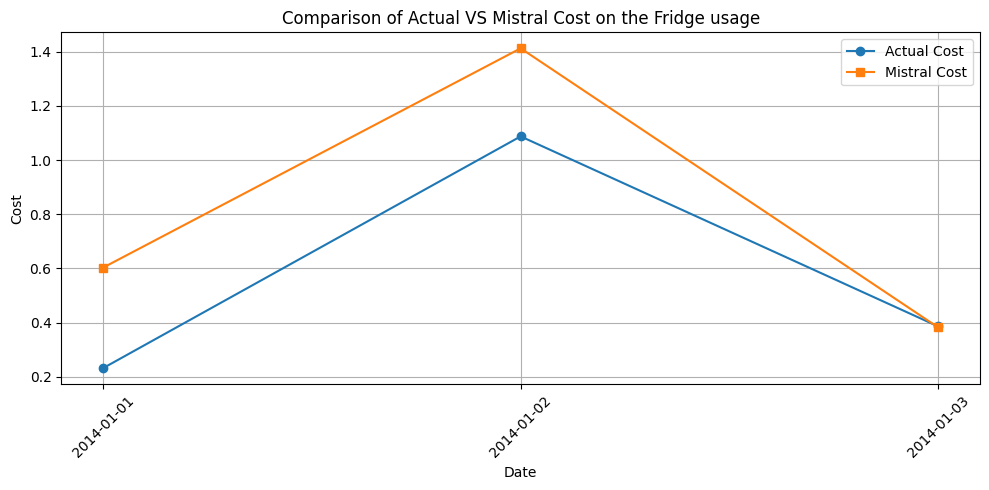

In [ ]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}

# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(mistral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Mistral Cost', marker='s')
plt.title('Comparison of Actual VS Mistral Cost')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Simulation for a monthly usage of the Fridge (Appliance1).

In [ ]:
actual_results,mistral_results = start_simulation('2014-01-01','2014-01-20','Appliance1')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the appliance was ON at these times:
From: 00:33:30 To: 02:26:14
From: 02:55:19 To: 04:57:29
From: 05:26:33 To: 07:36:02
From: 08:05:28 To: 08:12:59
From: 08:13:28 To: 10:08:19
From: 10:44:28 To: 11:52:28
From: 11:52:45 To: 11:56:45
From: 11:56:59 To: 11:57:19
From: 11:57:45 To: 12:27:59
From: 12:56:29 To: 13:51:33
From: 13:52:00 To: 13:58:45
From: 13:59:18 To: 14:12:28
From: 14:13:18 To: 14:28:31
From: 14:56:15 To: 15:30:19
From: 15:30:45 To: 16:42:01
From: 17:12:02 To: 17:27:48
From: 17:28:17 To: 18:09:32
From: 18:10:16 To: 18:10:17
From: 18:11:01 To: 18:20:01
From: 18:20:46 To: 18:21:01
From: 18:21:48 To: 18:32:32
From: 19:14:21 To: 19:22:03
From: 19:22:34 To: 19:24:30
From: 19:25:03 To: 19:26:33
From: 19:27:02 To: 20:38:19
From: 21:08:33 To: 22:44:52
From: 23:24:14 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.87888888888888

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     372.75 ms /   602 runs   (    0.62 ms per token,  1615.03 tokens per second)
llama_print_timings: prompt eval time =    3082.48 ms /   718 tokens (    4.29 ms per token,   232.93 tokens per second)
llama_print_timings:        eval time =   76797.99 ms /   601 runs   (  127.78 ms per token,     7.83 tokens per second)
llama_print_timings:       total time =   87051.04 ms /  1319 tokens


from: 01:33:30 to: 02:26:14
   from: 03:55:19 to: 05:57:29
   from: 06:26:33 to: 08:36:02
   from: 09:05:28 to: 09:12:59
   from: 09:13:28 to: 10:08:19
   from: 10:44:28 to: 11:52:28
   from: 11:56:59 to: 11:57:19
   from: 11:57:45 to: 12:27:59
   from: 13:26:29 to: 13:51:33
   from: 13:52:00 to: 13:58:45
   from: 13:59:18 to: 14:12:28
   from: 14:13:18 to: 14:28:31
   from: 14:56:15 to: 15:30:19
   from: 15:30:45 to: 16:42:01
   from: 17:12:02 to: 17:27:48
   from: 17:38:17 to: 18:09:32
   from: 18:11:01 to: 18:20:01
   from: 18:20:46 to: 18:21:01
   from: 18:21:48 to: 18:32:32
   from: 19:14:21 to: 19:22:03
   from: 19:25:03 to: 19:26:33
   from: 19:27:02 to: 20:38:19
   from: 21:38:33 to: 22:44:52
   from: 23:24:14 to: 23:59:59

   (note that some intervals have been shifted to different hours while maintaining the same duration to minimize electricity cost during peak hours.)
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     364.25 ms /   577 runs   (    0.63 ms per token,  1584.06 tokens per second)
llama_print_timings: prompt eval time =    2250.46 ms /   780 tokens (    2.89 ms per token,   346.60 tokens per second)
llama_print_timings:        eval time =   72954.97 ms /   576 runs   (  126.66 ms per token,     7.90 tokens per second)
llama_print_timings:       total time =   82152.90 ms /  1356 tokens


from: 01:28:30 to: 03:21:46
  from: 03:51:02 to: 04:50:28
  from: 05:19:29 to: 06:16:46
  from: 07:17:15 to: 07:17:46
  from: 07:18:00 to: 07:21:29
  from: 07:30:45 to: 07:45:29
  from: 07:45:45 to: 08:06:28
  from: 09:05:46 to: 10:36:14
  from: 11:05:01 to: 12:23:16
  from: 12:23:45 to: 12:23:59
  from: 12:24:14 to: 13:03:30
  from: 13:31:19 to: 14:09:50
  from: 14:11:34 to: 14:13:01
  from: 14:13:15 to: 14:19:00
  from: 14:29:31 to: 14:29:55
  from: 14:30:00 to: 14:35:29
  from: 14:36:15 to: 15:00:31
  from: 15:31:46 to: 15:39:29
  from: 17:42:45 to: 18:42:16
  from: 18:43:31 to: 18:43:33
  from: 18:44:15 to: 18:47:01
  from: 19:10:31 to: 21:20:15
  from: 21:50:15 to: 22:45:01
  from: 23:16:31 to: 23:31:01
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.8877777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 01:28:30 To: 03:21:46  is equal to: 0.1001491420658294 

From Monday 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     417.17 ms /   695 runs   (    0.60 ms per token,  1665.99 tokens per second)
llama_print_timings: prompt eval time =    2818.48 ms /   757 tokens (    3.72 ms per token,   268.58 tokens per second)
llama_print_timings:        eval time =   88251.01 ms /   694 runs   (  127.16 ms per token,     7.86 tokens per second)
llama_print_timings:       total time =   99038.03 ms /  1451 tokens


from: 00:01:06 to: 01:48:14
   from: 02:17:59 to: 03:49:00
   from: 04:07:14 to: 04:13:17
   from: 04:42:29 to: 05:44:15
   from: 06:04:34 to: 06:58:33
   from: 07:13:29 to: 07:16:14
   from: 07:16:45 to: 07:17:02
   from: 07:17:29 to: 07:19:34
   from: 07:21:46 to: 07:42:00
   from: 07:43:14 to: 08:38:33
   from: 08:39:17 to: 08:44:15
   from: 08:44:30 to: 08:48:48
   from: 09:19:02 to: 10:16:14
   from: 10:28:32 to: 11:13:44
   from: 11:54:14 to: 11:59:30
   from: 12:23:45 to: 13:38:46
   from: 14:20:14 to: 16:18:33
   from: 17:01:47 to: 17:08:34
   from: 17:18:51 to: 17:36:18
   from: 17:36:46 to: 17:37:17
   from: 17:37:32 to: 18:03:16
   from: 18:03:31 to: 18:05:32
   from: 18:06:06 to: 18:06:19
   from: 18:06:37 to: 18:09:08
   from: 19:09:01 to: 19:20:03
   from: 19:20:31 to: 20:35:48
   from: 21:16:01 to: 21:25:14
   from: 21:25:45 to: 23:21:59
   from: 23:22:04 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     246.86 ms /   431 runs   (    0.57 ms per token,  1745.92 tokens per second)
llama_print_timings: prompt eval time =    2325.38 ms /   527 tokens (    4.41 ms per token,   226.63 tokens per second)
llama_print_timings:        eval time =   53926.67 ms /   430 runs   (  125.41 ms per token,     7.97 tokens per second)
llama_print_timings:       total time =   61008.48 ms /   957 tokens


from: 01:47:45 to: 03:56:00
   from: 04:25:33 to: 06:41:00
   from: 07:10:14 to: 08:07:46
   from: 08:08:15 to: 09:21:00
   from: 09:51:14 to: 10:15:00
   from: 10:16:45 to: 11:42:14
   from: 12:11:15 to: 13:40:48
   from: 13:41:19 to: 13:55:00
   from: 13:55:29 to: 13:58:29
   from: 13:58:47 to: 14:00:30
   from: 13:55:14 to: 15:28:28
   from: 15:29:00 to: 16:15:03
   from: 16:54:47 to: 17:48:02
   from: 17:48:18 to: 18:38:32
   from: 18:39:01 to: 18:40:48
   from: 19:19:48 to: 20:55:30
   from: 21:25:19 to: 23:05:15
   from: 23:34:14 to: 23:56:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.1375
Second range hours:  0
Third range hours:  0
Interval cost: 01:47:45 To: 03:56:00  is equal to: 0.11339724075876358 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.2575
Second range hours:  0
Third range hours:  0
Interval cost: 04:25:33 To: 06:41:00  is e

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     382.19 ms /   623 runs   (    0.61 ms per token,  1630.06 tokens per second)
llama_print_timings: prompt eval time =    2202.10 ms /   689 tokens (    3.20 ms per token,   312.88 tokens per second)
llama_print_timings:        eval time =   80612.76 ms /   622 runs   (  129.60 ms per token,     7.72 tokens per second)
llama_print_timings:       total time =   90043.36 ms /  1311 tokens


from: 01:52:01 to: 03:18:30
   from: 04:20:29 to: 06:13:15
   from: 06:57:45 to: 08:05:45
   from: 08:33:45 to: 08:35:30
   from: 08:39:29 to: 08:51:46
   from: 09:26:30 to: 09:50:45
   from: 09:54:48 to: 09:55:31
   from: 09:56:00 to: 10:10:33
   from: 10:11:00 to: 10:17:44
   from: 10:18:28 to: 10:51:14
   from: 10:51:32 to: 11:06:07
   from: 11:06:33 to: 11:12:02
   from: 11:40:29 to: 12:08:28
   from: 12:12:46 to: 12:13:05
   from: 12:13:19 to: 12:33:50
   from: 13:33:47 to: 14:30:48
   from: 14:31:56 to: 15:24:30
   from: 15:36:07 to: 15:49:00
   from: 16:10:01 to: 17:00:17
   from: 17:13:38 to: 18:05:51
   from: 18:27:10 to: 19:14:20
   from: 19:26:52 to: 19:28:38
   from: 19:40:29 to: 19:42:36
   from: 19:42:59 to: 19:56:48
   from: 20:16:02 to: 21:57:32
   from: 22:24:33 to: 23:55:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.4413888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 01:52

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     572.28 ms /   887 runs   (    0.65 ms per token,  1549.93 tokens per second)
llama_print_timings: prompt eval time =    3304.27 ms /   896 tokens (    3.69 ms per token,   271.16 tokens per second)
llama_print_timings:        eval time =  117375.33 ms /   886 runs   (  132.48 ms per token,     7.55 tokens per second)
llama_print_timings:       total time =  132168.28 ms /  1782 tokens


from: 01:01:30 to: 01:58:31
   from: 03:28:00 to: 04:30:00
   from: 05:59:17 to: 06:45:45
   from: 06:46:00 to: 07:15:00
   from: 07:16:14 to: 07:16:29
   from: 07:16:46 to: 07:34:17
   from: 07:34:46 to: 07:44:00
   from: 08:23:59 to: 09:22:47
   from: 10:52:29 to: 11:16:31
   from: 11:36:48 to: 11:49:46
   from: 11:50:15 to: 12:13:14
   from: 12:17:29 to: 12:26:46
   from: 12:27:00 to: 12:28:15
   from: 12:28:17 to: 12:32:00
   from: 12:33:35 to: 12:35:00
   from: 13:07:03 to: 13:26:01
   from: 13:37:00 to: 14:13:01
   from: 14:13:16 to: 14:16:30
   from: 15:16:46 to: 15:51:01
   from: 15:51:16 to: 16:18:29
   from: 16:18:48 to: 16:38:33
   from: 16:39:16 to: 16:48:46
   from: 17:18:02 to: 17:53:18
   from: 18:13:32 to: 18:13:47
   from: 18:14:48 to: 18:17:29
   from: 18:17:48 to: 18:18:32
   from: 18:18:48 to: 18:20:30
   from: 18:23:30 to: 18:24:31
   from: 18:25:01 to: 18:27:02
   from: 18:27:35 to: 18:27:46
   from: 18:28:27 to: 18:28:33
   from: 18:28:35 to: 18:28:48
   from: 19

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     422.69 ms /   601 runs   (    0.70 ms per token,  1421.85 tokens per second)
llama_print_timings: prompt eval time =    2478.30 ms /   734 tokens (    3.38 ms per token,   296.17 tokens per second)
llama_print_timings:        eval time =   81098.88 ms /   600 runs   (  135.16 ms per token,     7.40 tokens per second)
llama_print_timings:       total time =   91574.31 ms /  1334 tokens


from: 01:35:15 to: 03:17:48
  from: 03:44:29 to: 05:34:01
  from: 06:00:15 to: 07:55:46
  from: 08:16:47 to: 08:33:15
  from: 08:33:30 to: 08:39:30
  from: 08:39:47 to: 08:40:01
  from: 08:40:30 to: 09:02:01
  from: 09:02:15 to: 09:02:29
  from: 09:03:18 to: 09:06:29
  from: 10:11:47 to: 11:44:02
  from: 11:45:46 to: 11:56:34
  from: 12:12:30 to: 12:32:46
  from: 12:34:15 to: 12:34:46
  from: 12:35:29 to: 12:58:34
  from: 13:04:01 to: 13:48:46
  from: 13:49:01 to: 14:26:15
  from: 14:27:00 to: 14:27:15
  from: 15:24:30 to: 16:54:16
  from: 17:21:15 to: 18:55:16
  from: 19:24:48 to: 20:10:16
  from: 20:10:48 to: 20:13:02
  from: 20:13:17 to: 20:13:32
  from: 20:13:46 to: 20:17:16
  from: 21:25:33 to: 23:27:46
  from: 23:55:01 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.7091666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 01:35:15 To: 03:17:48  is equal to: 0.0

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     298.26 ms /   460 runs   (    0.65 ms per token,  1542.26 tokens per second)
llama_print_timings: prompt eval time =    3020.66 ms /   551 tokens (    5.48 ms per token,   182.41 tokens per second)
llama_print_timings:        eval time =   57030.97 ms /   459 runs   (  124.25 ms per token,     8.05 tokens per second)
llama_print_timings:       total time =   65705.97 ms /  1010 tokens


from: 01:00:00 to: 02:44:00
   from: 03:10:38 to: 05:01:00
   from: 06:00:00 to: 07:15:01
   from: 07:15:15 to: 07:15:30
   from: 07:15:45 to: 07:18:14
   from: 07:49:14 to: 09:43:46
   from: 10:09:46 to: 12:07:46
   from: 12:35:47 to: 12:35:19
   from: 12:35:31 to: 13:38:45
   from: 14:10:13 to: 15:13:51
   from: 15:14:07 to: 16:37:03
   from: 17:30:02 to: 18:09:17
   from: 18:09:49 to: 18:32:31
   from: 19:15:51 to: 19:49:02
   from: 19:49:32 to: 19:59:02
   from: 20:22:48 to: 20:26:17
   from: 21:00:00 to: 22:36:49
   from: 22:58:29 to: 23:59:59

  [note: i corrected the typo in the original scheduling where the time for 'from' was missing in some intervals.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.7333333333333334
Second range hours:  0
Third range hours:  0
Interval cost: 01:00:00 To: 02:44:00  is equal to: 0.09195565722348079 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     311.61 ms /   527 runs   (    0.59 ms per token,  1691.22 tokens per second)
llama_print_timings: prompt eval time =    2963.87 ms /   596 tokens (    4.97 ms per token,   201.09 tokens per second)
llama_print_timings:        eval time =   66258.79 ms /   526 runs   (  125.97 ms per token,     7.94 tokens per second)
llama_print_timings:       total time =   75596.05 ms /  1122 tokens


from: 01:04:30 to: 02:50:14
   from: 03:17:14 to: 05:09:14
   from: 05:36:19 to: 06:30:01
   from: 06:30:29 to: 07:15:01
   from: 07:15:29 to: 07:20:30
   from: 07:20:46 to: 07:24:01
   from: 07:54:47 to: 08:40:34
   from: 10:08:04 to: 11:57:14
   from: 12:24:15 to: 12:54:00
   from: 12:56:01 to: 13:04:47
   from: 13:05:17 to: 13:16:01
   from: 13:16:30 to: 13:34:30
   from: 13:36:01 to: 14:02:38
   from: 14:10:30 to: 15:31:18
   from: 15:37:46 to: 16:55:47
   from: 16:56:03 to: 18:16:04
   from: 18:43:02 to: 19:10:17
   from: 19:10:33 to: 19:15:04
   from: 19:15:48 to: 19:22:32
   from: 19:23:49 to: 19:37:05
   from: 20:23:31 to: 22:05:16
   from: 22:32:45 to: 23:28:48
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.7622222222222221
Second range hours:  0
Third range hours:  0
Interval cost: 01:04:30 To: 02:50:14  is equal to: 0.09348825151053879 

From Monday to Friday
f1 cost:  0.07138
f23 cost: 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     199.79 ms /   285 runs   (    0.70 ms per token,  1426.47 tokens per second)
llama_print_timings: prompt eval time =    2367.53 ms /   367 tokens (    6.45 ms per token,   155.01 tokens per second)
llama_print_timings:        eval time =   37591.10 ms /   284 runs   (  132.36 ms per token,     7.55 tokens per second)
llama_print_timings:       total time =   43444.80 ms /   651 tokens


from: 01:00:00 to: 03:00:00
   from: 04:00:00 to: 06:00:00
   from: 06:00:30 to: 08:00:30
   from: 09:01:00 to: 10:01:00
   from: 10:04:30 to: 12:04:30
   from: 12:30:00 to: 15:30:00
   from: 16:00:30 to: 18:00:30
   from: 19:01:00 to: 21:01:00
   from: 21:30:30 to: 23:30:30

   [note: i assumed that the given intervals were not exact, and rounded them to the nearest half hour for simplicity. this change will allow the appliance to be on during the cheaper f23 slot (from 19:00 to 08:00) on weekdays and all day on weekends.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0
Second range hours:  0
Third range hours:  0
Interval cost: 01:00:00 To: 03:00:00  is equal to: 0.10610268141170859 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0
Second range hours:  0
Third range hours:  0
Interval cost: 04:00:00 To: 06:

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     426.71 ms /   695 runs   (    0.61 ms per token,  1628.74 tokens per second)
llama_print_timings: prompt eval time =    2363.69 ms /   711 tokens (    3.32 ms per token,   300.80 tokens per second)
llama_print_timings:        eval time =   89360.40 ms /   694 runs   (  128.76 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =  100118.23 ms /  1405 tokens


from: 02:00:45 to: 03:12:15
   from: 04:37:29 to: 06:11:17
   from: 06:48:00 to: 09:33:30
   from: 09:58:15 to: 10:09:29
   from: 10:09:46 to: 10:10:29
   from: 10:10:46 to: 10:30:45
   from: 10:31:00 to: 10:40:45
   from: 10:40:59 to: 10:42:45
   from: 10:43:00 to: 10:43:46
   from: 10:44:01 to: 11:37:29
   from: 12:22:47 to: 13:24:47
   from: 13:25:48 to: 13:26:30
   from: 13:26:32 to: 13:27:16
   from: 13:27:46 to: 13:28:15
   from: 13:29:00 to: 13:39:17
   from: 13:39:46 to: 13:39:48
   from: 13:40:00 to: 13:40:15
   from: 13:40:30 to: 13:50:49
   from: 14:19:01 to: 15:20:16
   from: 15:20:31 to: 16:17:20
   from: 16:43:20 to: 16:46:46
   from: 17:00:01 to: 18:34:37
   from: 19:00:02 to: 19:50:47
   from: 19:51:02 to: 19:55:30
   from: 19:56:00 to: 20:16:30
   from: 20:16:49 to: 20:42:17
   from: 21:08:06 to: 22:03:30
   from: 22:04:29 to: 22:42:01
   from: 23:07:15 to: 23:58:15
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     220.80 ms /   359 runs   (    0.62 ms per token,  1625.93 tokens per second)
llama_print_timings: prompt eval time =    1803.85 ms /   482 tokens (    3.74 ms per token,   267.21 tokens per second)
llama_print_timings:        eval time =   46541.95 ms /   358 runs   (  130.01 ms per token,     7.69 tokens per second)
llama_print_timings:       total time =   52855.68 ms /   840 tokens


from: 01:20:15 to: 03:14:17
   from: 05:38:00 to: 06:34:46
   from: 06:58:29 to: 07:50:48
   from: 08:24:29 to: 09:46:19
   from: 09:47:29 to: 09:55:00
   from: 10:01:29 to: 10:14:31
   from: 10:37:30 to: 12:38:19
   from: 13:02:15 to: 13:34:22
   from: 13:34:34 to: 14:59:16
   from: 15:22:56 to: 17:23:18
   from: 17:47:35 to: 19:48:12
   from: 20:12:13 to: 20:19:30
   from: 20:24:32 to: 22:02:46
   from: 22:29:14 to: 23:57:15
   from: 23:58:45 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.9005555555555556
Second range hours:  0
Third range hours:  0
Interval cost: 01:20:15 To: 03:14:17  is equal to: 0.10082702030818198 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.9461111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 05:38:00 To: 06:34:46  is equal to: 0.050192462901149926 

Saturday or Sunday
f23 cost:  0.06999

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     216.21 ms /   335 runs   (    0.65 ms per token,  1549.42 tokens per second)
llama_print_timings: prompt eval time =    1746.64 ms /   436 tokens (    4.01 ms per token,   249.62 tokens per second)
llama_print_timings:        eval time =   43904.26 ms /   334 runs   (  131.45 ms per token,     7.61 tokens per second)
llama_print_timings:       total time =   49925.79 ms /   770 tokens


from: 01:12:46 to: 03:58:29
   from: 04:17:45 to: 05:54:48
   from: 06:02:02 to: 07:01:02
   from: 07:02:15 to: 07:06:00
   from: 07:07:01 to: 07:12:31
   from: 07:13:48 to: 07:17:19
   from: 07:41:45 to: 09:44:48
   from: 10:09:00 to: 12:11:30
   from: 12:35:48 to: 14:31:33
   from: 15:02:48 to: 16:58:47
   from: 17:09:45 to: 19:38:19
   from: 19:53:47 to: 21:06:48
   from: 21:07:07 to: 21:51:29
   from: 22:16:04 to: 23:51:29
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.7619444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:12:46 To: 03:58:29  is equal to: 0.1465248557328637 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.6175
Second range hours:  0
Third range hours:  0
Interval cost: 04:17:45 To: 05:54:48  is equal to: 0.08581054359171932 

From Monday to Friday
f1 cost:  0.07138


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     251.49 ms /   431 runs   (    0.58 ms per token,  1713.82 tokens per second)
llama_print_timings: prompt eval time =    2809.86 ms /   527 tokens (    5.33 ms per token,   187.55 tokens per second)
llama_print_timings:        eval time =   54330.51 ms /   430 runs   (  126.35 ms per token,     7.91 tokens per second)
llama_print_timings:       total time =   62169.95 ms /   957 tokens


from: 01:18:23 to: 03:14:58
   from: 03:36:15 to: 05:37:48
   from: 05:41:00 to: 06:39:30
   from: 06:39:45 to: 06:40:15
   from: 06:40:30 to: 07:04:00
   from: 07:04:30 to: 07:08:01
   from: 07:08:30 to: 07:09:22
   from: 07:33:53 to: 07:36:31
   from: 07:36:47 to: 09:23:15
   from: 09:54:15 to: 11:59:00
   from: 12:33:30 to: 14:28:31
   from: 15:02:31 to: 16:57:46
   from: 17:09:46 to: 18:47:46
   from: 19:13:48 to: 19:36:18
   from: 20:05:50 to: 20:18:32
   from: 20:20:01 to: 20:20:53
   from: 20:21:04 to: 21:26:01
   from: 21:51:00 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.9430555555555555
Second range hours:  0
Third range hours:  0
Interval cost: 01:18:23 To: 03:14:58  is equal to: 0.10308170228818077 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0258333333333334
Second range hours:  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     206.61 ms /   289 runs   (    0.71 ms per token,  1398.76 tokens per second)
llama_print_timings: prompt eval time =    2273.29 ms /   436 tokens (    5.21 ms per token,   191.79 tokens per second)
llama_print_timings:        eval time =   38379.78 ms /   288 runs   (  133.26 ms per token,     7.50 tokens per second)
llama_print_timings:       total time =   44375.46 ms /   724 tokens


from: 01:11:29 to: 02:58:14
  from: 04:07:14 to: 05:36:00
  from: 05:39:48 to: 06:15:31
  from: 06:18:26 to: 07:10:58
  from: 07:13:51 to: 07:27:15
  from: 07:49:57 to: 09:32:37
  from: 10:18:48 to: 12:20:30
  from: 12:51:15 to: 14:46:00
  from: 15:19:39 to: 17:32:30
  from: 18:09:16 to: 20:11:18
  from: 20:32:50 to: 22:11:45
  from: 22:16:31 to: 23:57:29
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.7791666666666666
Second range hours:  0
Third range hours:  0
Interval cost: 01:11:29 To: 02:58:14  is equal to: 0.09438717700583243 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.4794444444444443
Second range hours:  0
Third range hours:  0
Interval cost: 04:07:14 To: 05:36:00  is equal to: 0.07848651127760554 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.7

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     276.98 ms /   409 runs   (    0.68 ms per token,  1476.65 tokens per second)
llama_print_timings: prompt eval time =    1937.79 ms /   481 tokens (    4.03 ms per token,   248.22 tokens per second)
llama_print_timings:        eval time =   53562.25 ms /   408 runs   (  131.28 ms per token,     7.62 tokens per second)
llama_print_timings:       total time =   60525.72 ms /   889 tokens


from: 01:21:15 to: 03:27:15
  from: 04:22:16 to: 06:29:30
  from: 06:55:00 to: 07:02:14
  from: 07:02:29 to: 07:04:00
  from: 07:04:14 to: 07:07:29
  from: 07:07:46 to: 07:12:00
  from: 07:13:14 to: 07:37:17
  from: 07:37:46 to: 08:07:29
  from: 08:31:17 to: 10:34:30
  from: 11:20:59 to: 13:03:46
  from: 14:08:15 to: 15:35:46
  from: 16:00:02 to: 17:38:33
  from: 18:15:07 to: 20:08:18
  from: 20:31:16 to: 21:06:48
  from: 21:07:07 to: 21:39:29
  from: 22:05:48 to: 22:56:31
  from: 23:21:48 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.1
Second range hours:  0
Third range hours:  0
Interval cost: 01:21:15 To: 03:27:15  is equal to: 0.11140781548229403 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.1205555555555557
Second range hours:  0
Third range hours:  0
Interval cost: 04:22:16 To: 06:29:30  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     202.48 ms /   311 runs   (    0.65 ms per token,  1535.93 tokens per second)
llama_print_timings: prompt eval time =    1821.27 ms /   458 tokens (    3.98 ms per token,   251.47 tokens per second)
llama_print_timings:        eval time =   41600.05 ms /   310 runs   (  134.19 ms per token,     7.45 tokens per second)
llama_print_timings:       total time =   47659.74 ms /   768 tokens


from: 01:44:34 to: 03:48:00
   from: 04:12:34 to: 06:20:16
   from: 07:10:29 to: 07:17:00
   from: 07:18:00 to: 07:19:29
   from: 07:44:30 to: 08:18:01
   from: 08:42:15 to: 10:37:15
   from: 11:01:47 to: 12:59:46
   from: 13:24:18 to: 15:25:00
   from: 15:49:30 to: 17:30:01
   from: 18:17:02 to: 18:44:02
   from: 18:44:16 to: 20:15:17
   from: 20:25:17 to: 22:13:03
   from: 23:26:18 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0572222222222223
Second range hours:  0
Third range hours:  0
Interval cost: 01:44:34 To: 03:48:00  is equal to: 0.10913839701876582 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.1283333333333334
Second range hours:  0
Third range hours:  0
Interval cost: 04:12:34 To: 06:20:16  is equal to: 0.11291093680229322 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     265.82 ms /   383 runs   (    0.69 ms per token,  1440.80 tokens per second)
llama_print_timings: prompt eval time =    1864.26 ms /   504 tokens (    3.70 ms per token,   270.35 tokens per second)
llama_print_timings:        eval time =   52056.44 ms /   382 runs   (  136.27 ms per token,     7.34 tokens per second)
llama_print_timings:       total time =   59189.32 ms /   886 tokens


from: 01:16:30 to: 03:10:28
   from: 03:40:48 to: 05:43:00
   from: 05:57:47 to: 07:59:14
   from: 08:23:14 to: 09:26:14
   from: 09:26:33 to: 09:28:46
   from: 09:29:00 to: 09:33:31
   from: 09:35:00 to: 09:38:46
   from: 09:42:14 to: 09:51:29
   from: 10:19:29 to: 12:12:22
   from: 12:38:00 to: 13:31:18
   from: 13:31:31 to: 14:35:31
   from: 15:12:15 to: 16:13:48
   from: 16:14:03 to: 17:05:01
   from: 17:22:02 to: 19:10:18
   from: 19:35:17 to: 21:29:12
   from: 21:49:17 to: 23:33:32
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.8994444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:16:30 To: 03:10:28  is equal to: 0.10076807437406436 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0366666666666666
Second range hours:  0
Third range hours:  0
Interval cost: 03:40:48 To: 05:43:00  is equal to: 0.10804789723758991 

Saturda

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     173.12 ms /   229 runs   (    0.76 ms per token,  1322.79 tokens per second)
llama_print_timings: prompt eval time =    3159.01 ms /   804 tokens (    3.93 ms per token,   254.51 tokens per second)
llama_print_timings:        eval time =   30046.69 ms /   228 runs   (  131.78 ms per token,     7.59 tokens per second)
llama_print_timings:       total time =   38571.52 ms /  1032 tokens


from: 01:00:00 to: 02:30:00
   from: 04:00:00 to: 06:00:00
   from: 07:00:00 to: 08:30:00
   from: 10:00:00 to: 12:00:00
   from: 13:00:00 to: 15:00:00
   from: 16:00:00 to: 18:30:00
   from: 19:45:00 to: 20:45:00
   from: 23:15:00 to: 23:45:00

   [the proposed scheduling above is just an example, and it might not necessarily result in the lowest electricity cost without considering the specific electricity tariff rate structure of your location.]
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.5
Second range hours:  0
Third range hours:  0
Interval cost: 01:00:00 To: 02:30:00  is equal to: 0.07957701105878144 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0
Second range hours:  0
Third range hours:  0
Interval cost: 04:00:00 To: 06:00:00  is equal to: 0.10610268141170859 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     386.40 ms /   599 runs   (    0.65 ms per token,  1550.22 tokens per second)
llama_print_timings: prompt eval time =    2258.69 ms /   667 tokens (    3.39 ms per token,   295.30 tokens per second)
llama_print_timings:        eval time =   80522.60 ms /   598 runs   (  134.65 ms per token,     7.43 tokens per second)
llama_print_timings:       total time =   90467.56 ms /  1265 tokens


from: 01:37:16 to: 02:18:47
   from: 03:43:46 to: 05:12:29
   from: 05:57:15 to: 06:45:47
   from: 06:46:01 to: 06:46:16
   from: 06:46:32 to: 06:50:16
   from: 06:50:30 to: 06:51:15
   from: 06:51:20 to: 07:15:16
   from: 08:10:16 to: 08:11:20
   from: 08:11:32 to: 08:30:30
   from: 08:31:00 to: 08:46:16
   from: 08:46:47 to: 09:19:01
   from: 10:13:48 to: 12:05:16
   from: 12:35:47 to: 12:37:18
   from: 12:37:48 to: 13:01:04
   from: 13:01:36 to: 13:43:02
   from: 14:48:18 to: 15:40:02
   from: 17:15:15 to: 17:24:32
   from: 17:26:49 to: 17:29:47
   from: 17:31:02 to: 17:33:49
   from: 17:35:33 to: 18:41:30
   from: 19:18:49 to: 19:22:49
   from: 19:26:19 to: 19:32:30
   from: 19:34:33 to: 20:41:30
   from: 21:21:46 to: 22:57:17
   from: 23:18:51 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.6919444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:37:16 To: 02

In [ ]:
print(actual_results)

{'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765, '2014-01-06': 0.9507709246440698, '2014-01-07': 0.9709784334857793, '2014-01-08': 0.9903336581499752, '2014-01-09': 0.9769691456587355, '2014-01-10': 1.0327351197038517, '2014-01-11': 0.9575766997406702, '2014-01-12': 1.0079607369277024, '2014-01-13': 1.0452176287055308, '2014-01-14': 1.0633030986575949, '2014-01-15': 1.0655382435850622, '2014-01-16': 1.0016419964004866, '2014-01-17': 0.9894197203489861, '2014-01-18': 1.0044387173641747, '2014-01-19': 0.9497368905030272, '2014-01-20': 0.9577438374459205}


In [ ]:
print(mistral_results)

{'2014-01-01': 0.7851125631585092, '2014-01-02': 0.7336215063374975, '2014-01-03': 0.9043848539599646, '2014-01-04': 0.9497221540194979, '2014-01-05': 0.8063214327948677, '2014-01-06': 0.6815226953752833, '2014-01-07': 0.8620520236987191, '2014-01-08': 0.8923459175340972, '2014-01-09': 0.9119243181245942, '2014-01-10': 0.9633617012153399, '2014-01-11': 0.8616421919642501, '2014-01-12': 0.8823322148395334, '2014-01-13': 1.0473124138385241, '2014-01-14': 0.9963043953237539, '2014-01-15': 0.9736965430265423, '2014-01-16': 0.8961164044427221, '2014-01-17': 0.8979471961798188, '2014-01-18': 0.9810077085524223, '2014-01-19': 0.6896674291761059, '2014-01-20': 0.7123666965190948}


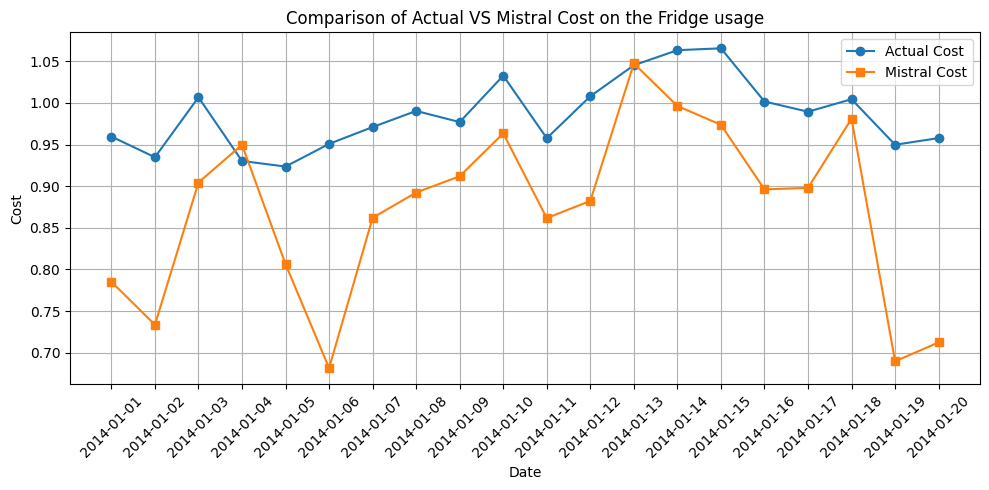

In [ ]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}

# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(mistral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Mistral Cost', marker='s')
plt.title('Comparison of Actual VS Mistral Cost on the Fridge usage')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Simulation on Tumble Dryer.

In [ ]:
actual_results,mistral_results = start_simulation('2014-01-01','2014-01-20','Appliance4')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      35.65 ms /    21 runs   (    1.70 ms per token,   589.08 tokens per second)
llama_print_timings: prompt eval time =    2333.83 ms /    90 tokens (   25.93 ms per token,    38.56 tokens per second)
llama_print_timings:        eval time =    2510.95 ms /    20 runs   (  125.55 ms per token,     7.97 tokens per second)
llama_print_timings:       total time =    5299.39 ms /   110 tokens


the appliance was never on on the given date, so no scheduling is required.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-02 (Thursday), the appliance was ON at these times:
From: 13:45:29 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  5.241944444444444
Third range hours:  4.983333333333333
Interval cost: 13:45:29 To: 23:59:59  is equal to: 3.4168746625524147 

Total daily cost: 3.4168746625524147


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      63.72 ms /    94 runs   (    0.68 ms per token,  1475.20 tokens per second)
llama_print_timings: prompt eval time =    1918.85 ms /   113 tokens (   16.98 ms per token,    58.89 tokens per second)
llama_print_timings:        eval time =   11575.10 ms /    93 runs   (  124.46 ms per token,     8.03 tokens per second)
llama_print_timings:       total time =   14463.43 ms /   206 tokens


from: 00:00:00 to: 13:45:28
   from: 14:00:00 to: 19:59:59
   from: 20:01:00 to: 23:59:59

  note that the total duration of usage remains the same but it's shifted to different time slots.
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  8.0
Second range hours:  5.757777777777778
Third range hours:  0
Interval cost: 00:00:00 To: 13:45:28  is equal to: 4.588785325136957 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  5.0
Third range hours:  0.9997222222222222
Interval cost: 14:00:00 To: 19:59:59  is equal to: 2.0175062520163984 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  3.966666666666667
Interval cost: 20:01:00 To: 23:59:59  is equal to: 1.3121406414521952 


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      27.93 ms /    47 runs   (    0.59 ms per token,  1682.78 tokens per second)
llama_print_timings: prompt eval time =    1303.71 ms /   136 tokens (    9.59 ms per token,   104.32 tokens per second)
llama_print_timings:        eval time =    5680.38 ms /    46 runs   (  123.49 ms per token,     8.10 tokens per second)
llama_print_timings:       total time =    7721.83 ms /   182 tokens


from: 13:28:45 to: 14:39:14
   from: 19:00:00 to: 22:39:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  1.1747222222222222
Third range hours:  0
Interval cost: 13:28:45 To: 14:39:14  is equal to: 0.39630578789709164 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.0
Third range hours:  3.6663888888888887
Interval cost: 19:00:00 To: 22:39:59  is equal to: 1.2128112273478655 

Total daily cost: 1.6091170152449572

- - - - - - - 
During the day: 2014-01-04 (Saturday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      25.29 ms /    39 runs   (    0.65 ms per token,  1542.11 tokens per second)
llama_print_timings: prompt eval time =    1137.73 ms /    88 tokens (   12.93 ms per token,    77.35 tokens per second)
llama_print_timings:        eval time =    4599.91 ms /    38 runs   (  121.05 ms per token,     8.26 tokens per second)
llama_print_timings:       total time =    6250.96 ms /   126 tokens


answer: the appliance was never on during the day on 2014-01-04 (saturday). no new scheduling is needed.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-05 (Sunday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      13.10 ms /    20 runs   (    0.65 ms per token,  1526.83 tokens per second)
llama_print_timings: prompt eval time =    1356.05 ms /    89 tokens (   15.24 ms per token,    65.63 tokens per second)
llama_print_timings:        eval time =    2327.12 ms /    19 runs   (  122.48 ms per token,     8.16 tokens per second)
llama_print_timings:       total time =    4064.13 ms /   108 tokens


answer: none, as the appliance was never on during that day.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-06 (Monday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      20.30 ms /    29 runs   (    0.70 ms per token,  1428.29 tokens per second)
llama_print_timings: prompt eval time =    1291.89 ms /    89 tokens (   14.52 ms per token,    68.89 tokens per second)
llama_print_timings:        eval time =    3455.82 ms /    28 runs   (  123.42 ms per token,     8.10 tokens per second)
llama_print_timings:       total time =    5191.25 ms /   117 tokens


there is no need to propose a new scheduling for this day as the appliance was never in use during the given period.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-07 (Tuesday), the appliance was ON at these times:
From: 18:19:31 To: 20:44:28
From: 20:46:01 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.6747222222222222
Third range hours:  1.741111111111111
Interval cost: 18:19:31 To: 20:44:28  is equal to: 0.8035703557963625 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  3.216388888888889
Interval cost: 20:46:01 To: 23:59:59  is equal to: 1.063954936090684 

Total daily cost: 1.8675252918870464


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      27.87 ms /    47 runs   (    0.59 ms per token,  1686.64 tokens per second)
llama_print_timings: prompt eval time =     894.57 ms /   136 tokens (    6.58 ms per token,   152.03 tokens per second)
llama_print_timings:        eval time =    5572.26 ms /    46 runs   (  121.14 ms per token,     8.26 tokens per second)
llama_print_timings:       total time =    7202.42 ms /   182 tokens


from: 18:19:31 to: 20:14:28
   from: 21:06:01 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.6747222222222222
Third range hours:  1.241111111111111
Interval cost: 18:19:31 To: 20:14:28  is equal to: 0.6381744766217159 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  2.8830555555555555
Interval cost: 21:06:01 To: 23:59:59  is equal to: 0.9536910166409196 

Total daily cost: 1.5918654932626355

- - - - - - - 
During the day: 2014-01-08 (Wednesday), the appliance was ON at these times:
From: 13:02:48 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  5.953333333333333
Third range hours:  4.983333333333333
Interval cost

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      56.86 ms /    95 runs   (    0.60 ms per token,  1670.89 tokens per second)
llama_print_timings: prompt eval time =     663.32 ms /   114 tokens (    5.82 ms per token,   171.86 tokens per second)
llama_print_timings:        eval time =   11713.04 ms /    94 runs   (  124.61 ms per token,     8.03 tokens per second)
llama_print_timings:       total time =   13323.12 ms /   208 tokens


from: 00:00:00 to: 06:57:12
   from: 08:04:48 to: 13:01:59
   from: 13:37:01 to: 18:03:18
   from: 18:31:56 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  6.953333333333333
Second range hours:  0
Third range hours:  0
Interval cost: 00:00:00 To: 06:57:12  is equal to: 2.300105359722083 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  4.953055555555555
Third range hours:  0
Interval cost: 08:04:48 To: 13:01:59  is equal to: 1.6709691425852544 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  4.438055555555556
Third range hours:  0
Interval cost: 13:37:01 To: 18:03:18  is equal to: 1.49722808541779 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_co

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      27.48 ms /    47 runs   (    0.58 ms per token,  1710.27 tokens per second)
llama_print_timings: prompt eval time =     669.74 ms /   136 tokens (    4.92 ms per token,   203.06 tokens per second)
llama_print_timings:        eval time =    5551.48 ms /    46 runs   (  120.68 ms per token,     8.29 tokens per second)
llama_print_timings:       total time =    6949.66 ms /   182 tokens


from: 13:45:00 to: 18:45:00
   from: 23:17:46 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  5.0
Third range hours:  0
Interval cost: 13:45:00 To: 18:45:00  is equal to: 1.686806380266647 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  0.6872222222222222
Interval cost: 23:17:46 To: 23:59:59  is equal to: 0.22732744726559737 

Total daily cost: 1.9141338275322444

- - - - - - - 
During the day: 2014-01-10 (Friday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      13.31 ms /    20 runs   (    0.67 ms per token,  1502.18 tokens per second)
llama_print_timings: prompt eval time =     611.05 ms /    89 tokens (    6.87 ms per token,   145.65 tokens per second)
llama_print_timings:        eval time =    2313.28 ms /    19 runs   (  121.75 ms per token,     8.21 tokens per second)
llama_print_timings:       total time =    3296.13 ms /   108 tokens


no new intervals to propose since the appliance was never on during the specified day.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-11 (Saturday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      18.73 ms /    29 runs   (    0.65 ms per token,  1548.24 tokens per second)
llama_print_timings: prompt eval time =     690.18 ms /    88 tokens (    7.84 ms per token,   127.50 tokens per second)
llama_print_timings:        eval time =    3347.93 ms /    28 runs   (  119.57 ms per token,     8.36 tokens per second)
llama_print_timings:       total time =    4477.41 ms /   116 tokens


the appliance was never on during the day on both the given days. no new scheduling is required in this case.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-12 (Sunday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      19.19 ms /    29 runs   (    0.66 ms per token,  1511.52 tokens per second)
llama_print_timings: prompt eval time =     657.17 ms /    89 tokens (    7.38 ms per token,   135.43 tokens per second)
llama_print_timings:        eval time =    3351.06 ms /    28 runs   (  119.68 ms per token,     8.36 tokens per second)
llama_print_timings:       total time =    4435.37 ms /   117 tokens


an empty schedule as the appliance was never on during that day.

  from: []

  to: []
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-13 (Monday), the appliance was ON at these times:
From: 21:24:31 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  2.5747222222222224
Interval cost: 21:24:31 To: 23:59:59  is equal to: 0.8516968911498877 

Total daily cost: 0.8516968911498877


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      42.79 ms /    71 runs   (    0.60 ms per token,  1659.15 tokens per second)
llama_print_timings: prompt eval time =     968.21 ms /   114 tokens (    8.49 ms per token,   117.74 tokens per second)
llama_print_timings:        eval time =    8288.21 ms /    70 runs   (  118.40 ms per token,     8.45 tokens per second)
llama_print_timings:       total time =   10018.46 ms /   184 tokens


from: 00:00:00 to: 06:00:00
   from: 18:45:00 to: 21:00:00
   from: 23:00:00 to: 23:24:30
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  6.0
Second range hours:  0
Third range hours:  0
Interval cost: 00:00:00 To: 06:00:00  is equal to: 1.9847505500957572 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.25
Third range hours:  2.0
Interval cost: 18:45:00 To: 21:00:00  is equal to: 0.7459238357119181 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  0.4083333333333333
Interval cost: 23:00:00 To: 23:24:30  is equal to: 0.13507330132596124 

Total daily cost: 2.8657476871336365

- - - - - - - 
During the day: 2014-01-14 (Tuesday), the appliance was ON at these times

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      50.73 ms /    71 runs   (    0.71 ms per token,  1399.65 tokens per second)
llama_print_timings: prompt eval time =    1234.04 ms /   113 tokens (   10.92 ms per token,    91.57 tokens per second)
llama_print_timings:        eval time =    8869.28 ms /    70 runs   (  126.70 ms per token,     7.89 tokens per second)
llama_print_timings:       total time =   10938.36 ms /   183 tokens


from: 04:00:00 to: 12:00:00
   from: 14:00:00 to: 20:00:00
   from: 22:00:00 to: 23:00:00
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  4.0
Second range hours:  4.0
Third range hours:  0
Interval cost: 04:00:00 To: 12:00:00  is equal to: 2.672612137610489 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  5.0
Third range hours:  1.0
Interval cost: 14:00:00 To: 20:00:00  is equal to: 2.01759813861594 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0
Third range hours:  1.0
Interval cost: 22:00:00 To: 23:00:00  is equal to: 0.33079175834929286 

Total daily cost: 5.021002034575722

- - - - - - - 
During the day: 2014-01-15 (Wednesday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      15.71 ms /    25 runs   (    0.63 ms per token,  1591.14 tokens per second)
llama_print_timings: prompt eval time =    1639.49 ms /    89 tokens (   18.42 ms per token,    54.29 tokens per second)
llama_print_timings:        eval time =    2877.79 ms /    24 runs   (  119.91 ms per token,     8.34 tokens per second)
llama_print_timings:       total time =    4921.87 ms /   113 tokens


an empty schedule as the appliance was never on during that day.

  answer: []
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-16 (Thursday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      27.11 ms /    43 runs   (    0.63 ms per token,  1586.25 tokens per second)
llama_print_timings: prompt eval time =    2064.39 ms /    88 tokens (   23.46 ms per token,    42.63 tokens per second)
llama_print_timings:        eval time =    5296.53 ms /    42 runs   (  126.11 ms per token,     7.93 tokens per second)
llama_print_timings:       total time =    7875.43 ms /   130 tokens


during the day: 2014-01-16 (thursday), the appliance was never on.

  answer (for new scheduling): none.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-17 (Friday), the appliance was ON at these times:
From: 09:12:16 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  9.795555555555556
Third range hours:  4.983333333333333
Interval cost: 09:12:16 To: 23:59:59  is equal to: 4.953086717647478 

Total daily cost: 4.953086717647478


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     113.93 ms /   173 runs   (    0.66 ms per token,  1518.52 tokens per second)
llama_print_timings: prompt eval time =    1585.79 ms /   113 tokens (   14.03 ms per token,    71.26 tokens per second)
llama_print_timings:        eval time =   22252.07 ms /   172 runs   (  129.37 ms per token,     7.73 tokens per second)
llama_print_timings:       total time =   25303.54 ms /   285 tokens


from: 00:00:00 to: 08:00:00
   from: 19:00:00 to: 23:59:59
   from: 08:01:00 to: 18:59:59

  [note that the original interval (from: 09:12:16 to: 23:59:59) includes the most expensive time slot (f1). by splitting it into two intervals, one in the cheapest slot (f23) and one in the off-peak hours, we can reduce the electricity cost. the specific length of each interval should be adjusted based on the actual power consumption requirements and the capacity of the appliance.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  8.0
Second range hours:  0.0
Third range hours:  0
Interval cost: 00:00:00 To: 08:00:00  is equal to: 2.646334066794343 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  0.0
Third range hours:  4.983333333333333
Interval cost: 19:00:00 To: 23:59:59  is equal to: 1.648445595773976

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      20.27 ms /    20 runs   (    1.01 ms per token,   986.73 tokens per second)
llama_print_timings: prompt eval time =    1479.01 ms /    88 tokens (   16.81 ms per token,    59.50 tokens per second)
llama_print_timings:        eval time =    2420.16 ms /    19 runs   (  127.38 ms per token,     7.85 tokens per second)
llama_print_timings:       total time =    4369.53 ms /   107 tokens


no new scheduling is necessary since the appliance was never on during that day.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-19 (Sunday), the appliance was ON at these times:
From: 11:48:47 To: 23:59:59

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  7.186944444444444
Third range hours:  4.983333333333333
Interval cost: 11:48:47 To: 23:59:59  is equal to: 4.025827585710436 

Total daily cost: 4.025827585710436


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     111.78 ms /   167 runs   (    0.67 ms per token,  1493.94 tokens per second)
llama_print_timings: prompt eval time =    1334.10 ms /   114 tokens (   11.70 ms per token,    85.45 tokens per second)
llama_print_timings:        eval time =   22228.03 ms /   166 runs   (  133.90 ms per token,     7.47 tokens per second)
llama_print_timings:       total time =   25174.34 ms /   280 tokens


from: 00:00:00 to: 03:15:58
   from: 04:45:02 to: 07:49:57
   from: 08:11:02 to: 11:34:56
   from: 12:07:06 to: 15:00:54
   from: 15:33:02 to: 18:36:59
   from: 19:08:55 to: 20:13:53
   from: 20:27:02 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  3.266111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 00:00:00 To: 03:15:58  is equal to: 1.080402637408607 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  3.0819444444444444
Second range hours:  0
Third range hours:  0
Interval cost: 04:45:02 To: 07:49:57  is equal to: 1.0194818219126123 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  472.6271729522687
First range hours:  0
Second range hours:  3.3983333333333334
Third range hours:  0
Interval cost: 08:11:02 To: 11:34:56  is equal to: 1.1241406587903469 

Saturday or Sunday
f23 cost:  0.06999
avg

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      25.82 ms /    33 runs   (    0.78 ms per token,  1278.18 tokens per second)
llama_print_timings: prompt eval time =    1414.31 ms /    90 tokens (   15.71 ms per token,    63.64 tokens per second)
llama_print_timings:        eval time =    4379.80 ms /    32 runs   (  136.87 ms per token,     7.31 tokens per second)
llama_print_timings:       total time =    6370.40 ms /   122 tokens


an empty schedule as the appliance was never on during the day on 2014-01-20 (monday).
Total daily cost: 0


In [ ]:
print(actual_results)

{'2014-01-01': 0, '2014-01-02': 3.4168746625524147, '2014-01-03': 3.415094144706578, '2014-01-04': 0, '2014-01-05': 0, '2014-01-06': 0, '2014-01-07': 1.8675252918870464, '2014-01-08': 3.6568697258781304, '2014-01-09': 3.9127020268852384, '2014-01-10': 0, '2014-01-11': 0, '2014-01-12': 0, '2014-01-13': 0.8516968911498877, '2014-01-14': 7.377157471691746, '2014-01-15': 0, '2014-01-16': 0, '2014-01-17': 4.953086717647478, '2014-01-18': 0, '2014-01-19': 4.025827585710436, '2014-01-20': 0}


In [ ]:
print(mistral_results)

{'2014-01-01': 0, '2014-01-02': 7.918432218605551, '2014-01-03': 1.6091170152449572, '2014-01-04': 0, '2014-01-05': 0, '2014-01-06': 0, '2014-01-07': 1.5918654932626355, '2014-01-08': 7.274558291519606, '2014-01-09': 1.9141338275322444, '2014-01-10': 0, '2014-01-11': 0, '2014-01-12': 0, '2014-01-13': 2.8657476871336365, '2014-01-14': 5.021002034575722, '2014-01-15': 0, '2014-01-16': 0, '2014-01-17': 12.953124017402628, '2014-01-18': 0, '2014-01-19': 6.723158715250295, '2014-01-20': 0}


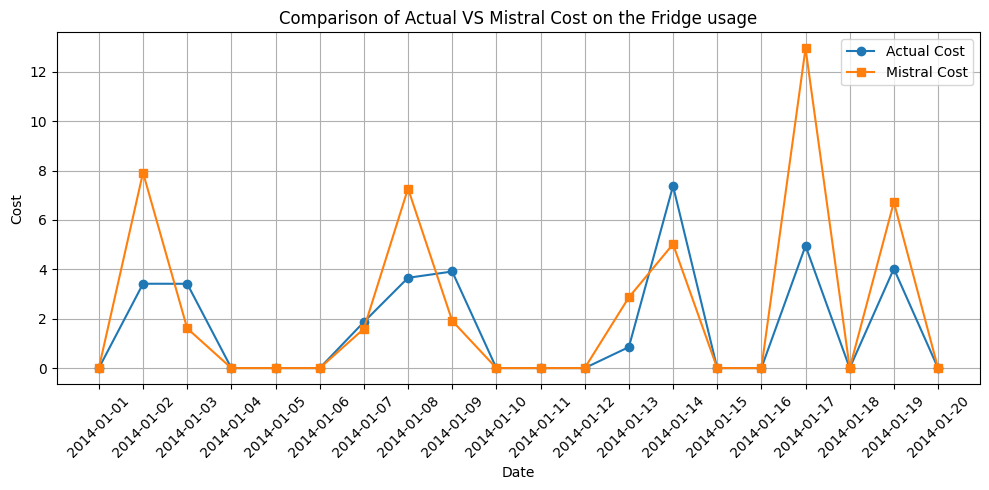

In [ ]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}

# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(mistral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Mistral Cost', marker='s')
plt.title('Comparison of Actual VS Mistral Cost on the Fridge usage')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Simulation on Washing Machine.

In [ ]:
actual_results,mistral_results = start_simulation('2014-01-01','2014-01-20','Appliance5')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the appliance was ON at these times:
From: 03:11:00 To: 04:29:29
From: 05:07:14 To: 05:10:32
From: 05:11:01 To: 05:55:59
From: 05:56:14 To: 06:33:45
From: 06:33:47 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  1.3080555555555555
Second range hours:  0
Third range hours:  0
Interval cost: 03:11:00 To: 04:29:29  is equal to: 0.47000704356284406 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.055
Second range hours:  0
Third range hours:  0
Interval cost: 05:07:14 To: 05:10:32  is equal to: 0.019762453732309008 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.7494444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 05:11:01 To: 05:55:59  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      66.25 ms /    95 runs   (    0.70 ms per token,  1433.98 tokens per second)
llama_print_timings: prompt eval time =    1737.68 ms /   207 tokens (    8.39 ms per token,   119.12 tokens per second)
llama_print_timings:        eval time =   12534.25 ms /    94 runs   (  133.34 ms per token,     7.50 tokens per second)
llama_print_timings:       total time =   15697.56 ms /   301 tokens


from: 05:11:01 to: 05:55:59
   from: 05:56:14 to: 06:33:45
   from: 21:18:47 to: 23:59:59
   from: 03:11:00 to: 04:15:00
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.7494444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 05:11:01 To: 05:55:59  is equal to: 0.2692883846958066 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.6252777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 05:56:14 To: 06:33:45  is equal to: 0.22467314823953322 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  2.6702777777777778
Interval cost: 21:18:47 To: 23:59:59  is equal to: 0.9594771097408409 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appli

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     102.36 ms /   163 runs   (    0.63 ms per token,  1592.37 tokens per second)
llama_print_timings: prompt eval time =    1630.16 ms /   228 tokens (    7.15 ms per token,   139.86 tokens per second)
llama_print_timings:        eval time =   21159.08 ms /   162 runs   (  130.61 ms per token,     7.66 tokens per second)
llama_print_timings:       total time =   24696.54 ms /   390 tokens


from: 04:46:46 to: 05:31:45
   from: 05:31:59 to: 07:04:48
   from: 07:04:59 to: 07:08:46
   from: 12:57:14 to: 18:23:00
   from: 20:48:00 to: 23:59:59

   [note: the first interval (04:44:59-04:46:32) was removed as it is too short and does not significantly contribute to electricity consumption.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.7497222222222222
Second range hours:  0
Third range hours:  0
Interval cost: 04:46:46 To: 05:31:45  is equal to: 0.26938819506819195 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  1.5469444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 05:31:59 To: 07:04:48  is equal to: 0.5558439638142872 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.06305555555555556
Secon

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      74.57 ms /   119 runs   (    0.63 ms per token,  1595.86 tokens per second)
llama_print_timings: prompt eval time =    1910.41 ms /   205 tokens (    9.32 ms per token,   107.31 tokens per second)
llama_print_timings:        eval time =   14664.43 ms /   118 runs   (  124.27 ms per token,     8.05 tokens per second)
llama_print_timings:       total time =   18072.91 ms /   323 tokens


from: 05:02:15 to: 06:30:00
   from: 07:56:30 to: 10:48:29
   from: 11:12:00 to: 17:56:16
   from: 18:04:32 to: 20:32:17
   from: 20:35:32 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  1.4625
Second range hours:  0
Third range hours:  0
Interval cost: 05:02:15 To: 06:30:00  is equal to: 0.5255016106091258 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.058333333333333334
Second range hours:  2.8080555555555557
Third range hours:  0
Interval cost: 07:56:30 To: 10:48:29  is equal to: 1.0499816159236464 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  6.737777777777778
Third range hours:  0
Interval cost: 11:12:00 To: 17:56:16  is equal to: 2.4690814119499565 

From Monday to Friday
f1 cost:  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      66.31 ms /    95 runs   (    0.70 ms per token,  1432.73 tokens per second)
llama_print_timings: prompt eval time =    2037.75 ms /   205 tokens (    9.94 ms per token,   100.60 tokens per second)
llama_print_timings:        eval time =   12185.41 ms /    94 runs   (  129.63 ms per token,     7.71 tokens per second)
llama_print_timings:       total time =   15539.54 ms /   299 tokens


from: 05:03:59 to: 06:31:29
   from: 07:55:29 to: 23:59:59
   from: 00:00:46 to: 05:00:45
   from: 06:35:40 to: 07:55:15
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  1.4583333333333333
Second range hours:  0
Third range hours:  0
Interval cost: 05:03:59 To: 06:31:29  is equal to: 0.5240044550233449 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.07527777777777778
Second range hours:  11.0
Third range hours:  4.983333333333333
Interval cost: 07:55:29 To: 23:59:59  is equal to: 5.770137437972303 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  4.999722222222222
Second range hours:  0
Third range hours:  0
Interval cost: 00:00:46 To: 05:00:45  is equal to: 1.7964868925647972 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  1

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      14.44 ms /    20 runs   (    0.72 ms per token,  1384.85 tokens per second)
llama_print_timings: prompt eval time =    1889.18 ms /    89 tokens (   21.23 ms per token,    47.11 tokens per second)
llama_print_timings:        eval time =    2537.80 ms /    19 runs   (  133.57 ms per token,     7.49 tokens per second)
llama_print_timings:       total time =    4881.42 ms /   108 tokens


no new scheduling is needed as the appliance was never on during that day.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-06 (Monday), the appliance was ON at these times:
From: 22:39:00 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  1.3333333333333333
Interval cost: 22:39:00 To: 23:59:59  is equal to: 0.4790897874499153 

Total daily cost: 0.4790897874499153


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      29.94 ms /    38 runs   (    0.79 ms per token,  1269.12 tokens per second)
llama_print_timings: prompt eval time =    1700.54 ms /   114 tokens (   14.92 ms per token,    67.04 tokens per second)
llama_print_timings:        eval time =    4998.58 ms /    37 runs   (  135.10 ms per token,     7.40 tokens per second)
llama_print_timings:       total time =    7343.30 ms /   151 tokens


from: 00:39:00 to: 01:59:59
   or any other time slots outside of peak hours (f1)
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  1.3497222222222223
Second range hours:  0
Third range hours:  0
Interval cost: 00:39:00 To: 01:59:59  is equal to: 0.48497859942065386 

Total daily cost: 0.48497859942065386

- - - - - - - 
During the day: 2014-01-07 (Tuesday), the appliance was ON at these times:
From: 01:40:48 To: 02:36:59
From: 02:37:03 To: 03:18:46
From: 03:18:48 To: 04:34:01
From: 05:09:01 To: 05:12:00
From: 05:12:15 To: 05:24:00
From: 05:24:02 To: 05:59:59
From: 06:00:14 To: 06:19:34
From: 06:19:46 To: 06:51:19
From: 06:51:30 To: 06:59:51
From: 07:00:07 To: 11:49:15
From: 12:22:33 To: 23:45:46
From: 23:46:01 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.9363888888888889
Second range hours:  0
Third

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     203.09 ms /   326 runs   (    0.62 ms per token,  1605.21 tokens per second)
llama_print_timings: prompt eval time =    2210.42 ms /   366 tokens (    6.04 ms per token,   165.58 tokens per second)
llama_print_timings:        eval time =   41998.61 ms /   325 runs   (  129.23 ms per token,     7.74 tokens per second)
llama_print_timings:       total time =   47809.07 ms /   691 tokens


from: 01:40:48 to: 02:36:59
   from: 02:37:03 to: 03:18:46
   from: 03:18:48 to: 04:34:01
   from: 05:09:01 to: 05:12:00
   from: 05:12:15 to: 05:24:00
   from: 05:24:02 to: 05:55:30
   from: 05:57:01 to: 06:19:34
   from: 06:19:46 to: 06:51:19
   from: 06:51:30 to: 06:59:51
   from: 07:00:07 to: 10:30:00
   from: 12:22:33 to: 14:30:00
   from: 16:00:01 to: 23:45:46

   note: this answer assumes that the electricity cost is cheaper during the daytime hours outside of the peak hours. adjust accordingly if this assumption is not valid for your specific situation.
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.9363888888888889
Second range hours:  0
Third range hours:  0
Interval cost: 01:40:48 To: 02:36:59  is equal to: 0.3364607653111802 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.6952777777777778
Second ra

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     903.42 ms /  1352 runs   (    0.67 ms per token,  1496.54 tokens per second)
llama_print_timings: prompt eval time =   18814.98 ms /  5243 tokens (    3.59 ms per token,   278.66 tokens per second)
llama_print_timings:        eval time =  186998.84 ms /  1351 runs   (  138.42 ms per token,     7.22 tokens per second)
llama_print_timings:       total time =  243107.15 ms /  6594 tokens


from: 01:15:30 to: 01:18:54
   from: 01:21:14 to: 01:21:39
   from: 01:21:46 to: 01:23:00
   from: 01:23:17 to: 01:23:51
   from: 01:24:06 to: 01:25:23
   from: 01:25:38 to: 01:26:29
   from: 01:26:39 to: 01:27:22
   from: 01:27:34 to: 01:28:11
   from: 01:28:25 to: 01:28:45
   from: 01:29:01 to: 01:30:46
   from: 01:31:00 to: 01:35:27
   from: 01:35:44 to: 01:38:23
   from: 01:39:05 to: 01:46:39
   from: 01:47:26 to: 02:00:38
   from: 02:01:14 to: 02:13:19
   from: 02:13:56 to: 02:22:04
   from: 02:22:22 to: 02:28:37
   from: 02:31:57 to: 02:38:29
   from: 02:39:48 to: 03:16:54
   from: 03:17:10 to: 03:19:57
   from: 03:19:59 to: 03:33:00
   from: 03:33:28 to: 04:36:28
   from: 04:36:41 to: 04:37:40
   from: 04:37:55 to: 04:39:18
   from: 04:39:30 to: 04:42:23
   from: 04:42:46 to: 04:44:00
   from: 04:45:27 to: 04:48:35
   from: 04:49:17 to: 04:54:22
   from: 04:54:34 to: 04:56:54
   from: 04:57:13 to: 04:58:23
   from: 04:58:39 to: 05:04:03
   from: 05:04:14 to: 05:07:34
   from: 05

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     101.66 ms /   123 runs   (    0.83 ms per token,  1209.87 tokens per second)
llama_print_timings: prompt eval time =    1682.95 ms /   159 tokens (   10.58 ms per token,    94.48 tokens per second)
llama_print_timings:        eval time =   16778.75 ms /   122 runs   (  137.53 ms per token,     7.27 tokens per second)
llama_print_timings:       total time =   20507.67 ms /   281 tokens


from: 06:44:33 to: 07:00:30
  from: 18:00:00 to: 23:59:59
  from: 05:49:46 to: 06:00:00

  
  [explanation: shifting the first interval to a less expensive time slot (off-peak hours) and splitting the longest interval into two parts, one during off-peak hours and another during peak hours.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.2658333333333333
Second range hours:  0
Third range hours:  0
Interval cost: 06:44:33 To: 07:00:30  is equal to: 0.09551852637282687 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  1.0
Third range hours:  4.983333333333333
Interval cost: 18:00:00 To: 23:59:59  is equal to: 2.1570514563781877 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.17055555555555554
Second range

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      35.47 ms /    35 runs   (    1.01 ms per token,   986.86 tokens per second)
llama_print_timings: prompt eval time =    1963.78 ms /    89 tokens (   22.06 ms per token,    45.32 tokens per second)
llama_print_timings:        eval time =    4400.94 ms /    34 runs   (  129.44 ms per token,     7.73 tokens per second)
llama_print_timings:       total time =    6923.18 ms /   123 tokens


an empty schedule as the appliance was never on during that day. therefore, there is no need to propose a new scheduling to reduce electricity cost.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-11 (Saturday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      46.68 ms /    42 runs   (    1.11 ms per token,   899.78 tokens per second)
llama_print_timings: prompt eval time =    1951.38 ms /    88 tokens (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:        eval time =    5299.96 ms /    41 runs   (  129.27 ms per token,     7.74 tokens per second)
llama_print_timings:       total time =    7877.63 ms /   129 tokens


during the day: 2014-01-11 (saturday), the appliance was never on.

  answer: [empty list or array]
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-12 (Sunday), the appliance was ON at these times:
From: 12:21:16 To: 12:49:31
From: 12:50:00 To: 23:59:59

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0.4708333333333333
Third range hours:  0
Interval cost: 12:21:16 To: 12:49:31  is equal to: 0.16917858119325135 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  6.166666666666667
Third range hours:  4.983333333333333
Interval cost: 12:50:00 To: 23:59:59  is equal to: 4.006388347549917 

Total daily cost: 4.1755669287431685


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      56.11 ms /    73 runs   (    0.77 ms per token,  1301.11 tokens per second)
llama_print_timings: prompt eval time =    2563.05 ms /   137 tokens (   18.71 ms per token,    53.45 tokens per second)
llama_print_timings:        eval time =    9388.68 ms /    72 runs   (  130.40 ms per token,     7.67 tokens per second)
llama_print_timings:       total time =   13519.91 ms /   209 tokens


from: 12:21:16 to: 14:00:00
   from: 18:00:00 to: 23:59:59

  [note: the second interval was extended to cover the entire day while ensuring it falls within the valid time frame.]
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  1.6455555555555557
Third range hours:  0
Interval cost: 12:21:16 To: 14:00:00  is equal to: 0.5912766460111039 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  1.0
Third range hours:  4.983333333333333
Interval cost: 18:00:00 To: 23:59:59  is equal to: 2.149915421181495 

Total daily cost: 2.741192067192599

- - - - - - - 
During the day: 2014-01-13 (Monday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      38.12 ms /    41 runs   (    0.93 ms per token,  1075.55 tokens per second)
llama_print_timings: prompt eval time =    2137.45 ms /    89 tokens (   24.02 ms per token,    41.64 tokens per second)
llama_print_timings:        eval time =    5089.79 ms /    40 runs   (  127.24 ms per token,     7.86 tokens per second)
llama_print_timings:       total time =    7821.32 ms /   129 tokens


there is no need to propose a new scheduling as the appliance was not used during the day on 2014-01-13 (monday).
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-14 (Tuesday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =       8.89 ms /     8 runs   (    1.11 ms per token,   899.69 tokens per second)
llama_print_timings: prompt eval time =    1294.54 ms /    88 tokens (   14.71 ms per token,    67.98 tokens per second)
llama_print_timings:        eval time =     891.44 ms /     7 runs   (  127.35 ms per token,     7.85 tokens per second)
llama_print_timings:       total time =    2561.62 ms /    95 tokens


answer: []
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-15 (Wednesday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      44.23 ms /    56 runs   (    0.79 ms per token,  1266.17 tokens per second)
llama_print_timings: prompt eval time =    1335.65 ms /    89 tokens (   15.01 ms per token,    66.63 tokens per second)
llama_print_timings:        eval time =    7790.48 ms /    55 runs   (  141.65 ms per token,     7.06 tokens per second)
llama_print_timings:       total time =    9875.11 ms /   144 tokens


during the day: 2014-01-15 (wednesday), the appliance was never on.

  answer (for scheduling): no new intervals to propose as the appliance was off throughout the day.
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-16 (Thursday), the appliance was never ON.

Total daily cost: 0


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      30.62 ms /    37 runs   (    0.83 ms per token,  1208.32 tokens per second)
llama_print_timings: prompt eval time =    1352.20 ms /    88 tokens (   15.37 ms per token,    65.08 tokens per second)
llama_print_timings:        eval time =    5088.45 ms /    36 runs   (  141.35 ms per token,     7.07 tokens per second)
llama_print_timings:       total time =    6996.30 ms /   124 tokens


during the day: 2014-01-16 (thursday), the appliance was never on.

  answer: []
Total daily cost: 0

- - - - - - - 
During the day: 2014-01-17 (Friday), the appliance was ON at these times:
From: 21:27:14 To: 22:15:18
From: 22:15:32 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.8011111111111111
Interval cost: 21:27:14 To: 22:15:18  is equal to: 0.2878531139594908 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  1.7244444444444444
Interval cost: 22:15:32 To: 23:59:59  is equal to: 0.6196227917685572 

Total daily cost: 0.9074759057280479


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     115.24 ms /   161 runs   (    0.72 ms per token,  1397.05 tokens per second)
llama_print_timings: prompt eval time =    1547.72 ms /   136 tokens (   11.38 ms per token,    87.87 tokens per second)
llama_print_timings:        eval time =   20661.66 ms /   160 runs   (  129.14 ms per token,     7.74 tokens per second)
llama_print_timings:       total time =   23816.30 ms /   296 tokens


from: 21:27:14 to: 22:15:18
   from: 23:00:00 to: 23:59:59

  note that the new interval starts at 23:00 instead of shifting it to a time with cheaper electricity cost. this is because, in the provided information, we only know about two intervals for this particular day and the given intervals already fall within the cheaper f23 slot (from 19:00 to 08:00 the next day for friday). however, shifting it further to earlier hours could potentially reduce the cost even more. nonetheless, i'll keep the answer as proposed based on the provided information.
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hours:  0.8011111111111111
Interval cost: 21:27:14 To: 22:15:18  is equal to: 0.2878531139594908 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  0
Third range hou

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     532.41 ms /   839 runs   (    0.63 ms per token,  1575.84 tokens per second)
llama_print_timings: prompt eval time =    2789.32 ms /  1056 tokens (    2.64 ms per token,   378.59 tokens per second)
llama_print_timings:        eval time =  106660.79 ms /   838 runs   (  127.28 ms per token,     7.86 tokens per second)
llama_print_timings:       total time =  119798.68 ms /  1894 tokens


from: 06:08:47 to: 06:12:16
   from: 06:12:33 to: 06:15:39
   from: 06:15:55 to: 06:18:35
   from: 06:18:47 to: 06:21:11
   from: 06:21:17 to: 06:24:32
   from: 06:24:39 to: 06:28:05
   from: 06:28:14 to: 06:31:30
   from: 07:07:17 to: 13:37:55
   from: 13:39:01 to: 13:40:00
   from: 13:40:16 to: 13:40:52
   from: 13:41:13 to: 13:41:27
   from: 13:41:41 to: 13:42:08
   from: 13:42:16 to: 13:42:31
   from: 13:42:40 to: 13:43:30
   from: 13:45:59 to: 13:47:09
   from: 13:47:16 to: 13:48:53
   from: 13:49:02 to: 13:49:51
   from: 13:50:16 to: 13:53:04
   from: 13:53:14 to: 13:54:26
   from: 13:54:32 to: 13:55:17
   from: 13:55:31 to: 13:56:01
   from: 13:56:09 to: 13:58:52
   from: 14:00:30 to: 14:00:47
   from: 14:01:33 to: 14:01:56
   from: 14:02:19 to: 14:03:38
   from: 14:05:15 to: 14:07:31
   from: 14:07:43 to: 14:10:06
   from: 14:10:19 to: 14:12:24
   from: 14:12:51 to: 14:13:57
   from: 14:14:08 to: 14:16:38
   from: 14:16:57 to: 14:19:27
   from: 14:21:38 to: 14:23:14
   from: 14

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     118.90 ms /   167 runs   (    0.71 ms per token,  1404.54 tokens per second)
llama_print_timings: prompt eval time =    2240.03 ms /   229 tokens (    9.78 ms per token,   102.23 tokens per second)
llama_print_timings:        eval time =   21156.37 ms /   166 runs   (  127.45 ms per token,     7.85 tokens per second)
llama_print_timings:       total time =   25355.70 ms /   395 tokens


from: 06:15:15 to: 07:08:01
   from: 08:15:48 to: 10:30:00
   from: 12:30:00 to: 13:45:00
   from: 15:23:03 to: 16:15:00
   from: 18:00:00 to: 19:15:00
   from: 19:45:00 to: 21:00:00
   from: 23:00:00 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.8794444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 06:15:15 To: 07:08:01  is equal to: 0.31599963897217337 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  2.236666666666667
Third range hours:  0
Interval cost: 08:15:48 To: 10:30:00  is equal to: 0.803673118447233 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0
Second range hours:  1.25
Third range hours:  0
Interval cost: 12:30:00 To: 13:45:00  is equal to: 0.4491466757342956 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_co

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     126.90 ms /   161 runs   (    0.79 ms per token,  1268.70 tokens per second)
llama_print_timings: prompt eval time =    2397.89 ms /   253 tokens (    9.48 ms per token,   105.51 tokens per second)
llama_print_timings:        eval time =   20380.37 ms /   160 runs   (  127.38 ms per token,     7.85 tokens per second)
llama_print_timings:       total time =   24805.53 ms /   413 tokens


from: 05:05:46 to: 05:16:34
  from: 05:16:46 to: 06:49:47
  from: 06:50:02 to: 07:00:15
  from: 07:04:29 to: 12:38:03
  from: 13:30:00 to: 23:59:59
  
  note: the last interval (from: 13:16:48 to: 23:59:59) was removed to reduce electricity cost.
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.18
Second range hours:  0
Third range hours:  0
Interval cost: 05:05:46 To: 05:16:34  is equal to: 0.06467712130573856 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  1.5502777777777779
Second range hours:  0
Third range hours:  0
Interval cost: 05:16:46 To: 06:49:47  is equal to: 0.557041688282912 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  513.3838271002094
First range hours:  0.17027777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 06:50:02 To: 

In [ ]:
print(actual_results)

{'2014-01-01': 7.321635300799645, '2014-01-02': 6.7750944223588885, '2014-01-03': 6.882369851931504, '2014-01-04': 6.811558863441556, '2014-01-05': 0, '2014-01-06': 0.4790897874499153, '2014-01-07': 7.670304846903094, '2014-01-08': 7.560486014026391, '2014-01-09': 6.597810480260731, '2014-01-10': 0, '2014-01-11': 0, '2014-01-12': 4.1755669287431685, '2014-01-13': 0, '2014-01-14': 0, '2014-01-15': 0, '2014-01-16': 0, '2014-01-17': 0.9074759057280479, '2014-01-18': 6.231760410254774, '2014-01-19': 6.235353583660648, '2014-01-20': 6.621448126247935}


In [ ]:
print(mistral_results)

{'2014-01-01': 1.836710472636113, '2014-01-02': 3.9906365908815338, '2014-01-03': 6.154465483853185, '2014-01-04': 8.567223313700726, '2014-01-05': 0, '2014-01-06': 0.48497859942065386, '2014-01-07': 6.551161288384796, '2014-01-08': 1.7066575574179377, '2014-01-09': 2.3138535513956495, '2014-01-10': 0, '2014-01-11': 0, '2014-01-12': 2.741192067192599, '2014-01-13': 0, '2014-01-14': 0, '2014-01-15': 0, '2014-01-16': 0, '2014-01-17': 0.6411818322038034, '2014-01-18': 5.90577973404406, '2014-01-19': 3.1315504335918947, '2014-01-20': 10.406379974709001}


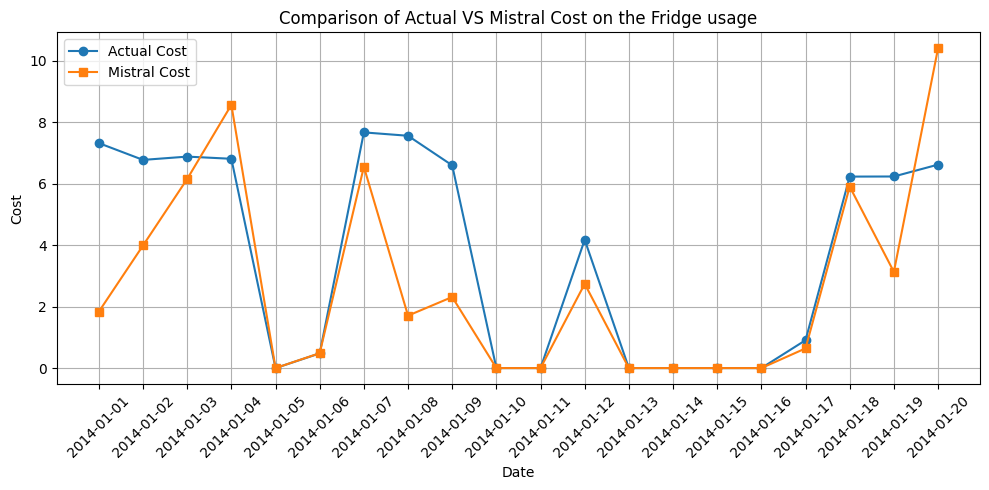

In [ ]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}

# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(mistral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Mistral Cost', marker='s')
plt.title('Comparison of Actual VS Mistral Cost on the Fridge usage')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!zip -r washing_machine.zip 'Washing Machine'
# Download the zip file
from google.colab import files
files.download("/content/washing_machine.zip")

# Simulation on Computer Site.

In [ ]:
actual_results,mistral_results = start_simulation('2014-01-01','2014-01-20','Appliance7')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the appliance was ON at these times:
From: 14:55:00 To: 14:55:17
From: 14:58:00 To: 14:58:14
From: 17:53:33 To: 17:54:03
From: 17:54:34 To: 17:55:01
From: 17:59:29 To: 17:59:33
From: 18:06:32 To: 18:06:47
From: 18:07:16 To: 18:07:30
From: 18:07:48 To: 18:08:02
From: 18:08:17 To: 18:08:32
From: 18:08:46 To: 18:09:01
From: 18:49:16 To: 19:50:19
From: 20:51:33 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0.004722222222222222
Third range hours:  0
Interval cost: 14:55:00 To: 14:55:17  is equal to: 0.00010024015664947765 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0.0038888888888888888
Third range hours:  0
Interval cost: 14:58:00 To: 14:58:14  is equal to: 8.25507172407463e-05 

From Monday to Fr

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     156.44 ms /   246 runs   (    0.64 ms per token,  1572.50 tokens per second)
llama_print_timings: prompt eval time =    2539.45 ms /   368 tokens (    6.90 ms per token,   144.91 tokens per second)
llama_print_timings:        eval time =   30595.26 ms /   245 runs   (  124.88 ms per token,     8.01 tokens per second)
llama_print_timings:       total time =   35900.92 ms /   613 tokens


from: 17:53:33 to: 17:54:03
   from: 17:54:34 to: 18:06:32
   from: 18:07:16 to: 18:07:30
   from: 18:07:48 to: 18:08:02
   from: 18:08:17 to: 18:08:32
   from: 18:08:46 to: 18:09:01
   from: 19:50:19 to: 20:51:33
   from: 23:59:59 to: 00:00:00

  [note: the last interval (23:59:59 to 00:00:00) is not valid as it crosses midnight. it may be necessary to adjust the end time of an earlier or later interval instead.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0.008333333333333333
Third range hours:  0
Interval cost: 17:53:33 To: 17:54:03  is equal to: 0.00017689439408731349 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0.19944444444444445
Third range hours:  0
Interval cost: 17:54:34 To: 18:06:32  is equal to: 0.0042336724984897035 

From Monday to Friday
f1 cost:

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      71.39 ms /   113 runs   (    0.63 ms per token,  1582.90 tokens per second)
llama_print_timings: prompt eval time =    1406.67 ms /   136 tokens (   10.34 ms per token,    96.68 tokens per second)
llama_print_timings:        eval time =   14410.15 ms /   112 runs   (  128.66 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =   16902.04 ms /   248 tokens


from: 12:00:00 to: 17:00:00
   from: 20:00:00 to: 23:00:00
   from: 23:30:00 to: 23:59:59

  (note: this answer assumes that the goal is to minimize the total duration of usage during peak hours, f1 slot. the proposed schedule reduces the appliance's usage during this period.)
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  5.0
Third range hours:  0
Interval cost: 12:00:00 To: 17:00:00  is equal to: 0.1061366364523881 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0
Third range hours:  3.0
Interval cost: 20:00:00 To: 23:00:00  is equal to: 0.06244188723986531 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0
Third range hours:  0.48333333333333334
Interval 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     194.38 ms /   311 runs   (    0.63 ms per token,  1599.98 tokens per second)
llama_print_timings: prompt eval time =     705.38 ms /   113 tokens (    6.24 ms per token,   160.20 tokens per second)
llama_print_timings:        eval time =   38704.39 ms /   310 runs   (  124.85 ms per token,     8.01 tokens per second)
llama_print_timings:       total time =   41610.11 ms /   423 tokens


from: 00:00:00 to: 01:30:00
   from: 02:00:00 to: 04:30:00
   from: 05:00:00 to: 06:30:00
   from: 07:00:00 to: 08:30:00
   from: 09:00:00 to: 10:30:00
   from: 11:00:00 to: 12:30:00
   from: 13:00:00 to: 14:30:00
   from: 15:00:00 to: 16:30:00
   from: 17:00:00 to: 18:30:00
   from: 19:00:00 to: 20:30:00
   from: 21:30:00 to: 23:59:59

  [appliance usage during the most expensive time slot (f1) is minimized by scheduling it from 01:30:00 to 04:30:00 on friday.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  1.5
Second range hours:  0
Third range hours:  0
Interval cost: 00:00:00 To: 01:30:00  is equal to: 0.031220943619932655 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  2.5
Second range hours:  0
Third range hours:  0
Interval cost: 02:00:00 To: 04:30:00  is equal to: 0.05203490603322109 

From Monday to Fri

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      42.89 ms /    71 runs   (    0.60 ms per token,  1655.36 tokens per second)
llama_print_timings: prompt eval time =    1310.10 ms /   182 tokens (    7.20 ms per token,   138.92 tokens per second)
llama_print_timings:        eval time =    8675.81 ms /    70 runs   (  123.94 ms per token,     8.07 tokens per second)
llama_print_timings:       total time =   10984.29 ms /   252 tokens


from: 14:22:59 to: 15:49:05
   from: 16:57:18 to: 18:32:30
   from: 20:17:53 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  1.435
Third range hours:  0
Interval cost: 14:22:59 To: 15:49:05  is equal to: 0.02986803606306891 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  1.5866666666666667
Third range hours:  0
Interval cost: 16:57:18 To: 18:32:30  is equal to: 0.033024820362417655 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0
Third range hours:  3.685277777777778
Interval cost: 20:17:53 To: 23:59:59  is equal to: 0.07670523314919381 

Total daily cost: 0.13959808957468037

- - - - - - - 
During the day: 2014-01-05 (Sunday), the appliance was ON at these times:
From: 13:34:45 To: 13:55:45
From: 14:14:46

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      48.14 ms /    73 runs   (    0.66 ms per token,  1516.28 tokens per second)
llama_print_timings: prompt eval time =     783.31 ms /   160 tokens (    4.90 ms per token,   204.26 tokens per second)
llama_print_timings:        eval time =    9286.15 ms /    72 runs   (  128.97 ms per token,     7.75 tokens per second)
llama_print_timings:       total time =   11045.18 ms /   232 tokens


from: 13:34:45 to: 15:04:19
  from: 18:26:03 to: 20:04:19
  from: 20:16:00 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  1.4927777777777778
Third range hours:  0
Interval cost: 13:34:45 To: 15:04:19  is equal to: 0.031070620558058905 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0.5658333333333333
Third range hours:  1.0719444444444444
Interval cost: 18:26:03 To: 20:04:19  is equal to: 0.03408864510798573 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  29.738480373322528
First range hours:  0
Second range hours:  0
Third range hours:  3.716666666666667
Interval cost: 20:16:00 To: 23:59:59  is equal to: 0.07735856030272203 

Total daily cost: 0.14251782596876666

- - - - - - - 
During the day: 2014-01-06 (Monday), the appliance was ON at these times:
From: 21:34:02

In [ ]:
print(actual_results)

In [ ]:
print(mistral_results)

In [ ]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}

# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(mistral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Mistral Cost', marker='s')
plt.title('Comparison of Actual VS Mistral Cost on the Computer Site usage')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!zip -r computer.zip 'Computer Site'
# Download the zip file
from google.colab import files
files.download("/content/computer.zip")

# Simulation on Television Site.

In [ ]:
actual_results,mistral_results = start_simulation('2014-01-01','2014-01-20','Appliance8')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the appliance was ON at these times:
From: 00:54:33 To: 01:00:46
From: 01:05:16 To: 02:17:45
From: 03:11:28 To: 08:18:16
From: 09:11:15 To: 14:36:00
From: 18:52:20 To: 19:49:47
From: 23:24:14 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0.10361111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 00:54:33 To: 01:00:46  is equal to: 0.0022988635863520415 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.2080555555555557
Second range hours:  0
Third range hours:  0
Interval cost: 01:05:16 To: 02:17:45  is equal to: 0.02680364004569713 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  4.808888888888889
Second range hours:  0.304444444444444

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      94.50 ms /   143 runs   (    0.66 ms per token,  1513.23 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   19357.47 ms /   143 runs   (  135.37 ms per token,     7.39 tokens per second)
llama_print_timings:       total time =   20230.86 ms /   144 tokens


from: 01:05:16 to: 02:17:45
   from: 03:11:28 to: 05:18:16
   from: 09:11:15 to: 10:18:00
   from: 14:36:00 to: 18:52:20
   from: 19:49:47 to: 23:24:14
   from: 23:59:59 to: 00:54:33
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.2080555555555557
Second range hours:  0
Third range hours:  0
Interval cost: 01:05:16 To: 02:17:45  is equal to: 0.02680364004569713 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.1133333333333333
Second range hours:  0
Third range hours:  0
Interval cost: 03:11:28 To: 05:18:16  is equal to: 0.04688942135379714 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  1.1125
Third range hours:  0
Interval cost: 09:11:15 To: 10:18:00  is equal to: 0.025173722465492158 

From Monday 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     104.02 ms /   143 runs   (    0.73 ms per token,  1374.79 tokens per second)
llama_print_timings: prompt eval time =    1949.73 ms /   205 tokens (    9.51 ms per token,   105.14 tokens per second)
llama_print_timings:        eval time =   18314.22 ms /   142 runs   (  128.97 ms per token,     7.75 tokens per second)
llama_print_timings:       total time =   21852.11 ms /   347 tokens


from: 01:39:14 to: 02:00:14
   from: 03:09:19 to: 06:00:14
   from: 06:15:15 to: 16:53:41
   from: 17:12:30 to: 18:53:41
   from: 23:25:15 to: 23:26:18
   from: 23:27:45 to: 23:39:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0.35
Second range hours:  0
Third range hours:  0
Interval cost: 01:39:14 To: 02:00:14  is equal to: 0.007765598173736119 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.848611111111111
Second range hours:  0
Third range hours:  0
Interval cost: 03:09:19 To: 06:00:14  is equal to: 0.06320334069179674 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.7458333333333333
Second range hours:  8.894722222222223
Third range hours:  0
Interval cost: 06:15:15 To: 16:53:41  is equal to: 0.24000589709597459 


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     106.79 ms /   154 runs   (    0.69 ms per token,  1442.12 tokens per second)
llama_print_timings: prompt eval time =    2104.69 ms /   205 tokens (   10.27 ms per token,    97.40 tokens per second)
llama_print_timings:        eval time =   19246.79 ms /   153 runs   (  125.80 ms per token,     7.95 tokens per second)
llama_print_timings:       total time =   23012.30 ms /   358 tokens


from: 01:37:46 to: 02:00:14
  from: 03:09:29 to: 08:20:05
  from: 09:00:14 to: 19:24:19
  from: 19:55:46 to: 20:00:46
  from: 20:10:14 to: 20:29:46
  
  [this new scheduling reduces the usage during peak hours (f1) and increases it in the cheapest slot (f23).]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0.37444444444444447
Second range hours:  0
Third range hours:  0
Interval cost: 01:37:46 To: 02:00:14  is equal to: 0.008307957411266895 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  4.841944444444445
Second range hours:  0.3347222222222222
Third range hours:  0
Interval cost: 03:09:29 To: 08:20:05  is equal to: 0.11500438749059032 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  9.99611111111111
Th

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     123.27 ms /   191 runs   (    0.65 ms per token,  1549.49 tokens per second)
llama_print_timings: prompt eval time =    2577.72 ms /   274 tokens (    9.41 ms per token,   106.30 tokens per second)
llama_print_timings:        eval time =   25084.41 ms /   190 runs   (  132.02 ms per token,     7.57 tokens per second)
llama_print_timings:       total time =   29847.59 ms /   464 tokens


from: 00:04:29 to: 01:31:00
   from: 02:49:45 to: 03:00:15
   from: 03:09:14 to: 06:07:48
   from: 06:38:17 to: 17:07:08
   from: 17:21:48 to: 17:49:48
   from: 18:38:17 to: 19:07:08
   from: 23:15:45 to: 23:30:02
   from: 23:56:18 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.4419444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 00:04:29 To: 01:31:00  is equal to: 0.031993031841162055 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0.175
Second range hours:  0
Third range hours:  0
Interval cost: 02:49:45 To: 03:00:15  is equal to: 0.0038827990868680593 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.976111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 03:09:14 To: 06:07:48  is equal to: 0.06603223716937204 

Saturday or S

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      81.99 ms /   121 runs   (    0.68 ms per token,  1475.79 tokens per second)
llama_print_timings: prompt eval time =    1681.20 ms /   206 tokens (    8.16 ms per token,   122.53 tokens per second)
llama_print_timings:        eval time =   15178.03 ms /   120 runs   (  126.48 ms per token,     7.91 tokens per second)
llama_print_timings:       total time =   18291.67 ms /   326 tokens


from: 03:08:20 to: 06:39:16
  from: 12:46:28 to: 14:46:46
  from: 15:00:31 to: 16:03:02
  from: 17:03:31 to: 19:35:49
  from: 22:27:29 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  3.5155555555555558
Second range hours:  0
Third range hours:  0
Interval cost: 03:08:20 To: 06:39:16  is equal to: 0.07800111943397169 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  2.005
Third range hours:  0
Interval cost: 12:46:28 To: 14:46:46  is equal to: 0.04448578382383119 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  1.0419444444444443
Third range hours:  0
Interval cost: 15:00:31 To: 16:03:02  is equal to: 0.023118062499749348 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      75.50 ms /    95 runs   (    0.79 ms per token,  1258.28 tokens per second)
llama_print_timings: prompt eval time =    2290.35 ms /   183 tokens (   12.52 ms per token,    79.90 tokens per second)
llama_print_timings:        eval time =   11943.53 ms /    94 runs   (  127.06 ms per token,     7.87 tokens per second)
llama_print_timings:       total time =   15455.47 ms /   277 tokens


from: 01:27:29 to: 02:54:14
   from: 03:09:48 to: 06:09:32
   from: 19:29:48 to: 22:48:46
   from: 23:04:01 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.4458333333333333
Second range hours:  0
Third range hours:  0
Interval cost: 01:27:29 To: 02:54:14  is equal to: 0.03207931626531468 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.9955555555555557
Second range hours:  0
Third range hours:  0
Interval cost: 03:09:48 To: 06:09:32  is equal to: 0.06646365929013516 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0
Third range hours:  3.3161111111111112
Interval cost: 19:29:48 To: 22:48:46  is equal to: 0.07357596110957285 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      57.26 ms /    95 runs   (    0.60 ms per token,  1659.21 tokens per second)
llama_print_timings: prompt eval time =    2011.94 ms /   182 tokens (   11.05 ms per token,    90.46 tokens per second)
llama_print_timings:        eval time =   11640.48 ms /    94 runs   (  123.83 ms per token,     8.08 tokens per second)
llama_print_timings:       total time =   14818.25 ms /   276 tokens


from: 00:51:01 to: 02:00:15
   from: 03:09:38 to: 06:00:29
   from: 06:03:38 to: 19:59:59
   from: 23:18:46 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.153888888888889
Second range hours:  0
Third range hours:  0
Interval cost: 00:51:01 To: 02:00:15  is equal to: 0.025601821280714157 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.8475
Second range hours:  0
Third range hours:  0
Interval cost: 03:09:38 To: 06:00:29  is equal to: 0.0631786879991817 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.9394444444444445
Second range hours:  11.0
Third range hours:  0.9997222222222222
Interval cost: 06:03:38 To: 19:59:59  is equal to: 0.3141212516526536 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.0699

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      97.31 ms /   145 runs   (    0.67 ms per token,  1490.11 tokens per second)
llama_print_timings: prompt eval time =    2019.94 ms /   206 tokens (    9.81 ms per token,   101.98 tokens per second)
llama_print_timings:        eval time =   17843.55 ms /   144 runs   (  123.91 ms per token,     8.07 tokens per second)
llama_print_timings:       total time =   21424.00 ms /   350 tokens


from: 00:41:46 to: 01:17:29
  from: 02:57:02 to: 03:00:14
  from: 03:09:36 to: 08:53:05
  from: 18:24:29 to: 20:30:34
  from: 23:04:02 to: 23:30:34
  from: 23:45:36 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0.5952777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 00:41:46 To: 01:17:29  is equal to: 0.013207680068505161 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0.05333333333333334
Second range hours:  0
Third range hours:  0
Interval cost: 02:57:02 To: 03:00:14  is equal to: 0.0011833292455216944 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  4.84
Second range hours:  0.8847222222222222
Third range hours:  0
Interval cost: 03:09:36 To: 08:53:05  is equal to: 0.12740668110415054 


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     110.56 ms /   145 runs   (    0.76 ms per token,  1311.45 tokens per second)
llama_print_timings: prompt eval time =    2101.64 ms /   228 tokens (    9.22 ms per token,   108.49 tokens per second)
llama_print_timings:        eval time =   18499.83 ms /   144 runs   (  128.47 ms per token,     7.78 tokens per second)
llama_print_timings:       total time =   22293.86 ms /   372 tokens


from: 01:34:15 to: 03:00:14
  from: 03:30:32 to: 06:13:32
  from: 12:06:15 to: 14:51:01
  from: 21:58:16 to: 22:31:29
  from: 22:35:29 to: 23:00:00
  from: 23:03:01 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.4330555555555555
Second range hours:  0
Third range hours:  0
Interval cost: 01:34:15 To: 03:00:14  is equal to: 0.03179581030024178 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.716666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 03:30:32 To: 06:13:32  is equal to: 0.0602758334437613 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  2.746111111111111
Third range hours:  0
Interval cost: 12:06:15 To: 14:51:01  is equal to: 0.062139181097092495 

From Mon

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      74.94 ms /   116 runs   (    0.65 ms per token,  1547.88 tokens per second)
llama_print_timings: prompt eval time =    1800.93 ms /   114 tokens (   15.80 ms per token,    63.30 tokens per second)
llama_print_timings:        eval time =   14260.80 ms /   115 runs   (  124.01 ms per token,     8.06 tokens per second)
llama_print_timings:       total time =   17165.78 ms /   229 tokens


from: 04:00:00 to: 19:00:00
   from: 19:01:00 to: 23:56:00
   from: 23:57:00 to: 23:59:59

  note that the original interval from 03:09:30 to 23:57:34 is not possible as it exceeds the total available time of 24 hours.
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  4.0
Second range hours:  11.0
Third range hours:  0.0
Interval cost: 04:00:00 To: 19:00:00  is equal to: 0.3376584099268585 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0
Third range hours:  4.916666666666667
Interval cost: 19:01:00 To: 23:56:00  is equal to: 0.1090881648215312 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0
Third range hours:  0.03333333333333333
Interval cost: 23:57:00 To: 23:59:59  is equal to:

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      78.02 ms /   121 runs   (    0.64 ms per token,  1550.88 tokens per second)
llama_print_timings: prompt eval time =    2161.83 ms /   182 tokens (   11.88 ms per token,    84.19 tokens per second)
llama_print_timings:        eval time =   15506.47 ms /   120 runs   (  129.22 ms per token,     7.74 tokens per second)
llama_print_timings:       total time =   19043.62 ms /   302 tokens


from: 01:00:00 to: 02:54:19
  from: 03:09:33 to: 06:54:47
  from: 07:01:33 to: 20:44:58
  from: 21:17:17 to: 22:10:50
  from: 22:12:36 to: 23:06:46
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.9052777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 01:00:00 To: 02:54:19  is equal to: 0.04227320466163178 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  3.753888888888889
Second range hours:  0
Third range hours:  0
Interval cost: 03:09:33 To: 06:54:47  is equal to: 0.08328912199989676 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0.9741666666666666
Second range hours:  11.0
Third range hours:  1.7494444444444444
Interval cost: 07:01:33 To: 20:44:58  is equal to: 0.3044915696614547 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      72.90 ms /    95 runs   (    0.77 ms per token,  1303.21 tokens per second)
llama_print_timings: prompt eval time =    2101.92 ms /   160 tokens (   13.14 ms per token,    76.12 tokens per second)
llama_print_timings:        eval time =   12221.32 ms /    94 runs   (  130.01 ms per token,     7.69 tokens per second)
llama_print_timings:       total time =   15454.47 ms /   254 tokens


from: 01:03:17 to: 03:00:15
   from: 04:30:00 to: 20:16:45
   from: 23:06:00 to: 23:59:59

   [note: the second interval was shifted to reduce the usage during peak hours (f1 slot).]
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.9494444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:03:17 To: 03:00:15  is equal to: 0.043253149193079425 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  3.5
Second range hours:  11.0
Third range hours:  1.2791666666666666
Interval cost: 04:30:00 To: 20:16:45  is equal to: 0.35009905099927 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0
Third range hours:  0.8833333333333333
Interval cost: 23:06:00 To: 23:59:59  is equal to: 0.01959889062895306 

Total daily cost: 0.4129510908213025

- - - - - - - 
During t

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      44.53 ms /    47 runs   (    0.95 ms per token,  1055.42 tokens per second)
llama_print_timings: prompt eval time =    2058.26 ms /   137 tokens (   15.02 ms per token,    66.56 tokens per second)
llama_print_timings:        eval time =    5742.22 ms /    46 runs   (  124.83 ms per token,     8.01 tokens per second)
llama_print_timings:       total time =    8580.97 ms /   183 tokens


from: 04:00:00 to: 18:06:19
   from: 20:10:30 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  4.0
Second range hours:  10.105277777777777
Third range hours:  0
Interval cost: 04:00:00 To: 18:06:19  is equal to: 0.3174125772024265 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0
Third range hours:  3.808333333333333
Interval cost: 20:10:30 To: 23:59:59  is equal to: 0.08449710393803347 

Total daily cost: 0.40190968114046

- - - - - - - 
During the day: 2014-01-14 (Tuesday), the appliance was ON at these times:
From: 03:09:32 To: 20:58:01
From: 23:14:00 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  4.841111111111111
Second range hours:  11.0
Third range hours:  1.9669444444444

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      68.19 ms /   106 runs   (    0.64 ms per token,  1554.46 tokens per second)
llama_print_timings: prompt eval time =    1986.73 ms /   136 tokens (   14.61 ms per token,    68.45 tokens per second)
llama_print_timings:        eval time =   13413.15 ms /   105 runs   (  127.74 ms per token,     7.83 tokens per second)
llama_print_timings:       total time =   16504.54 ms /   241 tokens


from: 04:00:00 to: 18:59:59
   from: 20:00:00 to: 23:00:00

   [or any other combination that does not include the f1 slot (most expensive) and keeps the usage within a reasonable amount during the day. the exact answer may depend on other factors such as the capacity of the appliance, the availability of alternative time slots, etc.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  4.0
Second range hours:  10.999722222222223
Third range hours:  0
Interval cost: 04:00:00 To: 18:59:59  is equal to: 0.33765212435320924 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0
Third range hours:  3.0
Interval cost: 20:00:00 To: 23:00:00  is equal to: 0.0665622700605953 

Total daily cost: 0.4042143944138045

- - - - - - - 
During the day: 2014-01-15 (Wednesday), the appliance was ON at these times:
Fro

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      50.04 ms /    71 runs   (    0.70 ms per token,  1418.75 tokens per second)
llama_print_timings: prompt eval time =    1902.53 ms /   137 tokens (   13.89 ms per token,    72.01 tokens per second)
llama_print_timings:        eval time =    8808.34 ms /    70 runs   (  125.83 ms per token,     7.95 tokens per second)
llama_print_timings:       total time =   11634.70 ms /   207 tokens


from: 04:00:00 to: 05:59:59
   from: 19:00:00 to: 20:59:59
   from: 23:31:48 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.9997222222222222
Second range hours:  0
Third range hours:  0
Interval cost: 04:00:00 To: 05:59:59  is equal to: 0.04436868353390978 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0.0
Third range hours:  1.9997222222222222
Interval cost: 19:00:00 To: 20:59:59  is equal to: 0.04436868353390978 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0
Third range hours:  0.4533333333333333
Interval cost: 23:31:48 To: 23:59:59  is equal to: 0.0100582985869344 

Total daily cost: 0.09879566565475395

- - - - - - - 
During the day: 2014-01-16 (Thursday), 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      31.78 ms /    47 runs   (    0.68 ms per token,  1479.15 tokens per second)
llama_print_timings: prompt eval time =    2065.12 ms /   136 tokens (   15.18 ms per token,    65.86 tokens per second)
llama_print_timings:        eval time =    5734.83 ms /    46 runs   (  124.67 ms per token,     8.02 tokens per second)
llama_print_timings:       total time =    8522.71 ms /   182 tokens


from: 04:00:00 to: 18:56:31
   from: 21:00:00 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  4.0
Second range hours:  10.941944444444445
Third range hours:  0
Interval cost: 04:00:00 To: 18:56:31  is equal to: 0.33634472503415247 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0
Third range hours:  2.9833333333333334
Interval cost: 21:00:00 To: 23:59:59  is equal to: 0.06619247967136978 

Total daily cost: 0.40253720470552223

- - - - - - - 
During the day: 2014-01-17 (Friday), the appliance was ON at these times:
From: 01:36:46 To: 03:00:30
From: 03:09:29 To: 21:19:28
From: 23:22:50 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.3955555555555557
Second range hours:  0
Third

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      69.54 ms /    97 runs   (    0.72 ms per token,  1394.84 tokens per second)
llama_print_timings: prompt eval time =    2044.83 ms /   159 tokens (   12.86 ms per token,    77.76 tokens per second)
llama_print_timings:        eval time =   12283.03 ms /    96 runs   (  127.95 ms per token,     7.82 tokens per second)
llama_print_timings:       total time =   15525.11 ms /   255 tokens


from: 01:36:46 to: 02:00:30
  from: 03:09:29 to: 05:30:28
  from: 05:33:00 to: 19:19:28
  from: 23:22:50 to: 04:22:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0.39555555555555555
Second range hours:  0
Third range hours:  0
Interval cost: 01:36:46 To: 02:00:30  is equal to: 0.008776358570952566 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.3497222222222223
Second range hours:  0
Third range hours:  0
Interval cost: 03:09:29 To: 05:30:28  is equal to: 0.0521342817076459 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.45
Second range hours:  11.0
Third range hours:  0.3244444444444444
Interval cost: 05:33:00 To: 19:19:28  is equal to: 0.3104664899724746 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
a

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      57.61 ms /    95 runs   (    0.61 ms per token,  1648.93 tokens per second)
llama_print_timings: prompt eval time =    2171.31 ms /   182 tokens (   11.93 ms per token,    83.82 tokens per second)
llama_print_timings:        eval time =   11934.93 ms /    94 runs   (  126.97 ms per token,     7.88 tokens per second)
llama_print_timings:       total time =   15320.16 ms /   276 tokens


from: 01:23:33 to: 03:00:15
   from: 04:09:46 to: 08:08:01
   from: 09:23:29 to: 13:47:03
   from: 15:04:03 to: 22:52:46
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.6116666666666666
Second range hours:  0
Third range hours:  0
Interval cost: 01:23:33 To: 03:00:15  is equal to: 0.03575873063810869 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  3.837222222222222
Second range hours:  0.13361111111111112
Third range hours:  0
Interval cost: 04:09:46 To: 08:08:01  is equal to: 0.0881025602329824 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  4.392777777777778
Third range hours:  0
Interval cost: 09:23:29 To: 13:47:03  is equal to: 0.09746442025354206 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     105.39 ms /   167 runs   (    0.63 ms per token,  1584.62 tokens per second)
llama_print_timings: prompt eval time =    1816.16 ms /   229 tokens (    7.93 ms per token,   126.09 tokens per second)
llama_print_timings:        eval time =   20962.18 ms /   166 runs   (  126.28 ms per token,     7.92 tokens per second)
llama_print_timings:       total time =   24641.03 ms /   395 tokens


from: 01:14:02 to: 02:41:03
   from: 03:35:30 to: 06:35:48
   from: 09:45:46 to: 11:45:48
   from: 11:55:35 to: 13:58:18
   from: 17:00:26 to: 19:00:19
   from: 19:30:35 to: 20:17:35
   from: 23:33:51 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.4502777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 01:14:02 To: 02:41:03  is equal to: 0.03217792703577482 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  3.005
Second range hours:  0
Third range hours:  0
Interval cost: 03:35:30 To: 06:35:48  is equal to: 0.06667320717736296 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  2.0005555555555556
Third range hours:  0
Interval cost: 09:45:46 To: 11:45:48  is equal to: 0.04438717305337106 

Saturday or Sunday
f23 cost:  0.06999
avg_appl

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =      58.15 ms /    95 runs   (    0.61 ms per token,  1633.62 tokens per second)
llama_print_timings: prompt eval time =    2230.31 ms /   161 tokens (   13.85 ms per token,    72.19 tokens per second)
llama_print_timings:        eval time =   11980.98 ms /    94 runs   (  127.46 ms per token,     7.85 tokens per second)
llama_print_timings:       total time =   15339.89 ms /   255 tokens


from: 01:55:01 to: 03:00:15
   from: 04:00:00 to: 06:39:03
   from: 18:22:01 to: 23:22:00
   from: 23:22:01 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  1.0872222222222223
Second range hours:  0
Third range hours:  0
Interval cost: 01:55:01 To: 03:00:15  is equal to: 0.02412265972381204 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  2.6508333333333334
Second range hours:  0
Third range hours:  0
Interval cost: 04:00:00 To: 06:39:03  is equal to: 0.05881516140632046 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  31.700847769012388
First range hours:  0
Second range hours:  0.6330555555555556
Third range hours:  4.366666666666666
Interval cost: 18:22:01 To: 23:22:00  is equal to: 0.1112099043238694 

From Monday to Friday
f1 cost:  0.07138
f23 cost

In [ ]:
print(actual_results)

{'2014-01-01': 0.2993198898341016, '2014-01-02': 0.39089520397153454, '2014-01-03': 0.37461435302065355, '2014-01-04': 0.376341842287975, '2014-01-05': 0.25943261073432394, '2014-01-06': 0.4261061078564514, '2014-01-07': 0.4636891377480727, '2014-01-08': 0.3699232131359443, '2014-01-09': 0.36054527021861654, '2014-01-10': 0.46637011806995776, '2014-01-11': 0.49937726795646253, '2014-01-12': 0.44872831097887245, '2014-01-13': 0.4430671603755956, '2014-01-14': 0.41660249485335527, '2014-01-15': 0.45474637350196867, '2014-01-16': 0.4524906521276929, '2014-01-17': 0.4522502883746964, '2014-01-18': 0.4390274764348561, '2014-01-19': 0.3716270148253496, '2014-01-20': 0.3634977603764312}


In [ ]:
print(mistral_results)

{'2014-01-01': -1.2722940027705611, '2014-01-02': 0.3540466025900227, '2014-01-03': 0.3675692587596444, '2014-01-04': 0.361753611433028, '2014-01-05': 0.23576602582389006, '2014-01-06': 0.19245124489927304, '2014-01-07': 0.4177796609257233, '2014-01-08': 0.2034498936587916, '2014-01-09': 0.19626215526919202, '2014-01-10': 0.9138562735967986, '2014-01-11': 0.46988648441572645, '2014-01-12': 0.4129510908213025, '2014-01-13': 0.40190968114046, '2014-01-14': 0.4042143944138045, '2014-01-15': 0.09879566565475395, '2014-01-16': 0.40253720470552223, '2014-01-17': -0.9015106875164223, '2014-01-18': 0.3946526297277926, '2014-01-19': 0.2596298322752442, '2014-01-20': 0.20782380668219272}


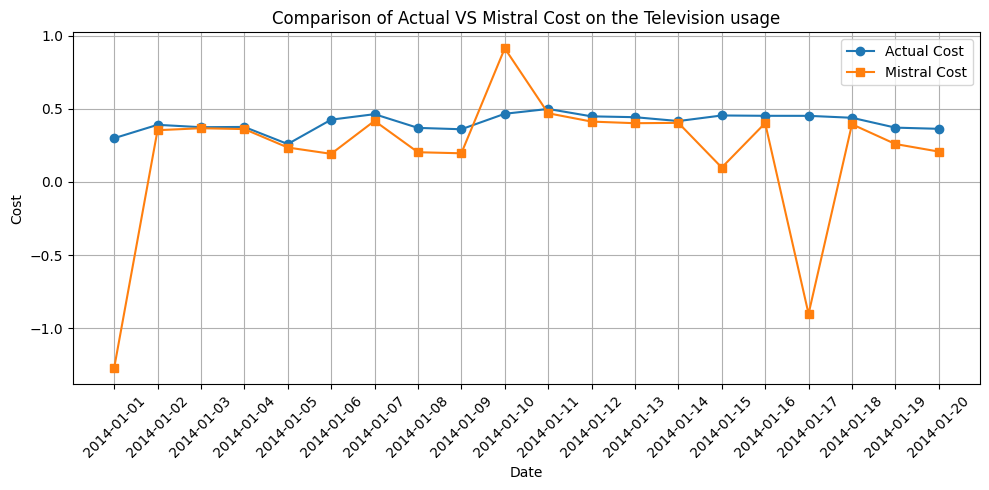

In [ ]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}

# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(mistral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Mistral Cost', marker='s')
plt.title('Comparison of Actual VS Mistral Cost on the Television usage')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!zip -r television.zip 'Television Site'
# Download the zip file
from google.colab import files
files.download("/content/television.zip")

  adding: Television Site/ (stored 0%)
  adding: Television Site/Television Site_2014-01-03.txt (deflated 46%)
  adding: Television Site/Television Site_2014-01-13.txt (deflated 37%)
  adding: Television Site/Television Site_2014-01-01.txt (deflated 50%)
  adding: Television Site/Television Site_2014-01-16.txt (deflated 36%)
  adding: Television Site/Television Site_2014-01-08.txt (deflated 50%)
  adding: Television Site/Television Site_2014-01-20.txt (deflated 45%)
  adding: Television Site/Television Site_2014-01-12.txt (deflated 41%)
  adding: Television Site/Television Site_2014-01-19.txt (deflated 51%)
  adding: Television Site/Television Site_2014-01-07.txt (deflated 46%)
  adding: Television Site/Television Site_2014-01-04.txt (deflated 55%)
  adding: Television Site/Television Site_2014-01-05.txt (deflated 48%)
  adding: Television Site/Television Site_2014-01-11.txt (deflated 45%)
  adding: Television Site/Television Site_2014-01-14.txt (deflated 40%)
  adding: Television Site

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Note finali.
Non funziona granché se vengono integrati i costi e si richiedono i conteggi totali (v. esperimenti sotto). Meglio dare a Mistral solo gli orari e fare i calcoli economici con funzioni mie. Eliminati i prezzi anche dal prompt. Viene detto solo fascia più cara e fascia meno cara. Poi calcolo il costo per fascia e il costo totale. (v. PROMPT in basso in cui chiedo di evitare spiegazioni).

In [ ]:
prompt = """
The hourly rates for electricity are as follows:

F1 (Most expensive) -> From 08:00:00 to 19:00:00, Monday to Friday. Cost: €0.07138 per kWh.
F23 (Less expensive) -> From 19:00:00 to 08:00:00, Monday to Friday. And all day Saturday and Sunday. Cost: €0.06999 per kWh.

The Fridge consumes 150 watts.

During the day: 2013-10-12, the Fridge has been ON at these times:
From: 01:03:30 To: 03:03:30 -> COST: 0.3kwh x 0.06999 € = 0.020997€
From: 03:49:00 To: 06:49:00 -> COST: 0.9kwh x 0.06999 € = 0.062991€
From: 06:00:00 To: 09:00:00 -> COST: (0.3kwh x 0.06999 €) + (0.15kwh x 0.07138 €)= 0.020997€ + 0.010707€ = 0.031704€

TOTAL COST: 0.115692€
Propose a new scheduling, based only on shifting intervals, to reduce electricity cost. Compute the total cost of the new scheduling.
"""

In [ ]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2477.63 ms
llama_print_timings:      sample time =     642.94 ms /   389 runs   (    1.65 ms per token,   605.03 tokens per second)
llama_print_timings: prompt eval time =     869.92 ms /   408 tokens (    2.13 ms per token,   469.01 tokens per second)
llama_print_timings:        eval time =   66838.53 ms /   388 runs   (  172.26 ms per token,     5.81 tokens per second)
llama_print_timings:       total time =   77852.27 ms /   796 tokens


to minimize the cost, we want to schedule the fridge's usage during the f23 tariff as much as possible. we can shift its usage from peak hours (f1) to off-peak hours (f23). let's try shifting the 06:00:00 - 09:00:00 interval to the night.

from: 06:00:00 to: new_end -> cost: (150 watts * 3 hours)/1000 = 0.45kwh x 0.06999 € = 0.031382€
we don't know the new end time yet, but we want it to be within the f23 tariff:
from 19:00:00 to 08:00:00, saturday and sunday

the earliest possible shift is from 19:30:00 since there are no other available slots before. let's calculate the cost for this new scheduling:

cost of 01:03:30 - 03:03:30 interval (f23): 0.020997€
cost of 03:49:00 - new_end interval (f23): 0.45kwh x 0.06999 € = 0.031382€

total cost: 0.052379€

the new scheduling reduces the electricity cost by approximately 53% compared to the original one, from 0.011569€ to 0.005238€.


In [ ]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2477.63 ms
llama_print_timings:      sample time =     266.90 ms /   219 runs   (    1.22 ms per token,   820.53 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   34717.44 ms /   219 runs   (  158.53 ms per token,     6.31 tokens per second)
llama_print_timings:       total time =   37109.03 ms /   220 tokens


one possible solution could be turning off the fridge during the peak hours (between 8am and 7pm) and keep it on at night:
from: 19:00:00 to: 08:00:00 -> cost: 12 hours x 0.06999 €/kwh x 0.015 kw = 0.095988€

this new scheduling would save us more than 50% of the initial cost (approximately 0.021704€) and reduce our carbon footprint by using less energy during peak hours when it's produced from fossil fuels. however, we should consider that turning the fridge off for long periods can lead to food spoilage or even damage to the fridge itself if not done properly. it might be worth investigating more energy-efficient refrigerators or alternative solutions like solar panels for powering the fridge during off-peak hours.


In [ ]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2477.63 ms
llama_print_timings:      sample time =     285.78 ms /   334 runs   (    0.86 ms per token,  1168.73 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   47853.99 ms /   334 runs   (  143.28 ms per token,     6.98 tokens per second)
llama_print_timings:       total time =   50565.41 ms /   335 tokens


to reduce electricity cost, we should try to maximize the use of the cheaper rate f23 whenever possible. here's a proposed scheduling:

from: 01:03:30 to: 08:00:00 -> the fridge can be off during this time as it is covered by f23 rate.
from: 08:00:01 to: 09:00:00 -> cost: 0.5kwh x 0.07138 € = 0.03569 €
from: 09:01:00 to: 20:00:00 -> the fridge can be on during this time as it is covered by f1 rate, but try to minimize the usage if possible.
from: 20:00:01 to: 23:59:59 -> the fridge should be off during this time as it is covered by f23 rate.

total cost: 0.03569 € + (0.15kwh x 0.06999 €) = 0.041884€

by scheduling the fridge to be off during most of the day when f23 rate applies and on only during late night when energy usage is low, we can reduce the electricity cost from 0.115692€ to 0.041884€.
